# Projet 5 : Segmentez des clients d'un site e-commerce
## Partie 2 : Essais

### Sommaire
 
**Partie 1 : Importation du jeu de données**
 - <a href="#C1"> 1. Importation du fichier clients </a>
    - <a href="#C10"> 1.0 Choix de la segmentation et feature engineering </a>
    - <a href="#C11"> 1.1 Data Sampling </a>
    - <a href="#C12"> 1.2 Définition du preprocessing </a>
    - <a href="#C13"> 1.3 Analyse en composante principale </a>
 
**Partie 2 : Essais 1 : K-means**
 - <a href="#C2"> 2. Essais 1 : K-means</a>
     - <a href="#C20"> 2.0 Choix du nombre de classes *k* </a>
     - <a href="#C21"> 2.1 Score et analyses des résultats </a>
     - <a href="#C22"> 2.2 Représentation </a>


**Partie 3 : Essais 2 : Classification ascendant hierarchique + K-means**
 - <a href="#C3">3. Essais 2 :  Classification ascendant hierarchique + K-means </a>
     - <a href="#C31">3.1 Score et analyses résultats </a>
         
**Partie 4 : Essais 3 : DBSCANS**
 - <a href="#C4"> 4. Essais 3 : DBSCANS</a>
     - <a href="#C41">4.1 Score et analyses résultats </a>

**Partie 5 : Bonus, méthode mixte**
 - <a href="#C5">5. Méthode mixte : K_means x CAH </a>
     - <a href="#C51"> 5.1  </a>





In [1]:
#!pip install gower
!pip install yellowbrick
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import clean #mon module de fontions qui me permettent de nettoyer un dataframe
import plot_
import sklearn
import time
### ------------ Clustering ----------------
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
### ------------ Pipeline ------------------
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, RobustScaler,  StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn import set_config
set_config(display="diagram")

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <a name="C1"> 1. Importation du fichier clients </a>

## <a name="C10"> 1.0 Choix de la segmentation et feature engineering </a>







---
En fonction de la segmentation testée, j'importe les features qui m'intéressent. 

* **Set_1** : Segmentation RFM 
* **Set_2** : Segmentation RFM + profil économique
* **Set_3** : Segmentation RFM + préférences


In [2]:
set_ = 3 #1, 2, 3


if set_ ==1 : 
  #Set 1, utilisation des variables RFM uniquement 
  df= pd.read_csv('/content/df_agg.csv', 
                  usecols = ['fréquence', 'récence_j', 'montant_moy'])

elif set_ == 2: 
  #Set 2, RFM ++ , reste d'échéances + pouvoir d'achat
  df= pd.read_csv('/content/df_agg.csv',
                  usecols = ['fréquence', 'récence_j', 'montant_moy', 
                             'nb_echeances', 'etat_client'])
  income = pd.read_csv('/content/Mean_Income_Federal_Brazil.csv', delimiter = ';')

elif set_ ==3:
  #Set 3, segmentation par préférence
  df= pd.read_csv('/content/df_agg.csv',
                  usecols = ['fréquence', 'récence_j','categorie', 'montant_moy', 
                             'critique_note'
                              ]) #'montant_moy'])
  income = pd.read_csv('/content/Mean_Income_Federal_Brazil.csv', delimiter = ';')



Text(0.5, 1.0, 'Distribution de la récence clientèle')

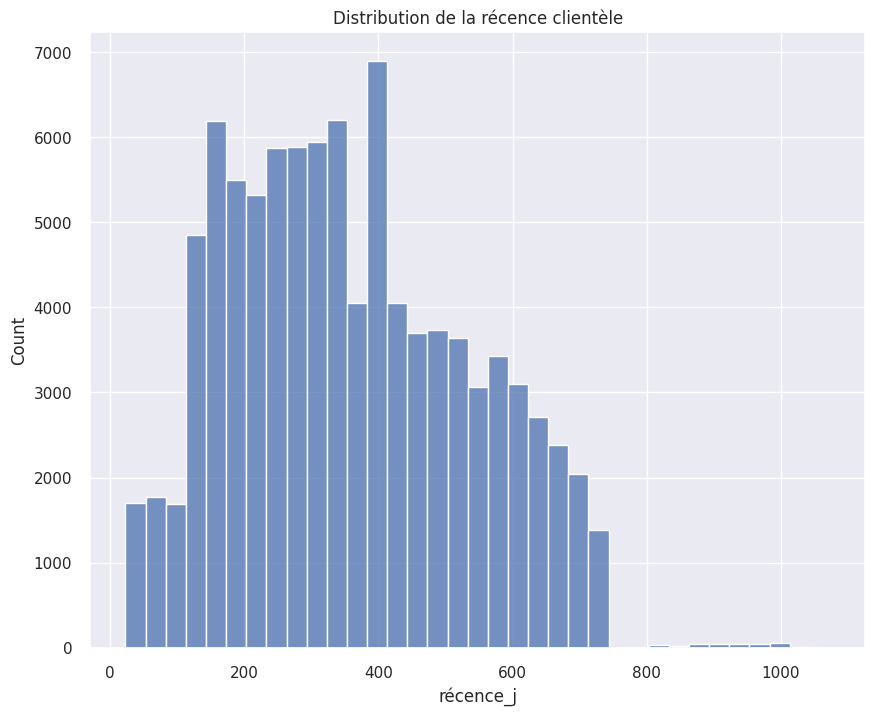

In [3]:
sns.set()
fig,ax = plt.subplots(figsize = (10,8)) 
sns.histplot(data=df, x = 'récence_j', binwidth = 30)
plt.title('Distribution de la récence clientèle')

- ### Feature engineering 



---


1.  Création de la variable **'reste_echeances_mois'**, qui donne une approcimation du nombre de mois restant à payer en considérant le nombre d'échénaces moyen par client et la date de leur dernière commande. On pourra distinguer les clients prêts à acheter à nouveau de ceux qui payent encore leur crédit. Question métier à évaluer avec le personnel compétent. 

In [4]:
if set_ ==2:
  df['reste_echeance_mois']= round(df['nb_echeances']- (df['récence_j']/30))
  df['reste_echeance_mois']
  df = df.drop(columns = ['nb_echeances'])

In [5]:
df.head()

fréquence  récence_j  montant_moy  critique_note               categorie
0         16        133    56.377500       5.000000        SPORTS & LOISIRS
1          9         29   218.175556       2.777778        CUISINE & MAISON
2          7        186   139.012857       5.000000        CUISINE & MAISON
3          6        609    18.453333       5.000000        CUISINE & MAISON
4          6        130   451.745000       4.500000  JOUETS ENFANTS & BÉBÉS

---


2.  Encodage de la variable 'etat_client' par le revenu moyen correspondant de l'année 2020. 

In [6]:
if set_ ==2:
  income = income.groupby('ETAT_CODE')['REVENU_MOYEN_R'].sum()
  income.head()

In [7]:
if set_ ==2:
  income

In [8]:
if set_ ==2:
  mapping = income.to_dict()
  #mapping
  df['etat_client'] = df['etat_client'].replace(mapping)

In [9]:
df.head()

fréquence  récence_j  montant_moy  critique_note               categorie
0         16        133    56.377500       5.000000        SPORTS & LOISIRS
1          9         29   218.175556       2.777778        CUISINE & MAISON
2          7        186   139.012857       5.000000        CUISINE & MAISON
3          6        609    18.453333       5.000000        CUISINE & MAISON
4          6        130   451.745000       4.500000  JOUETS ENFANTS & BÉBÉS

---


3. Remplacement de la variable 'categorie' qui désigne la catégorie préférée du client par la dépense de cette catégorie. 

In [10]:
if set_ ==3: 
  if 'categorie' in df.columns.tolist():
  #Remplacement des variables de type_paiement par la somme des montant moyen totaux. 
  #type_paiement = df.groupby('type_paiement')['montant_moy'].sum()
  #type_paiement = round(type_paiement)
  #mapping = type_paiement.to_dict()
  #df['type_paiement'] = df['type_paiement'].replace(mapping)
  #Remplacement des variables de catégorie par la somme des montant moyen totaux. 
    categorie = df.groupby('categorie')['montant_moy'].mean()
    categorie = round(categorie,2)
    mapping = categorie.to_dict()
    df['categorie'] = df['categorie'].replace(mapping)

## <a name="C11"> 1.1 Data Sampling </a>



---
Stratégie : Sélection d'un échantillon aléatoire. Vérification des distributions pour chacune des variables choisies pour adapter le type d'échantillonnage si besoin. 


In [11]:
#Échantillonage aléatoire
df_sample = df.sample(frac = 0.1, random_state = 38)

In [12]:
col = df.dtypes[df.dtypes != object].index
col
col_cat = df.dtypes[df.dtypes == object].index

In [13]:
col

Index(['fréquence', 'récence_j', 'montant_moy', 'critique_note', 'categorie'], dtype='object')

In [14]:
df.describe()

fréquence     récence_j    montant_moy  critique_note     categorie
count  95417.000000  95417.000000   95417.000000   95417.000000  95417.000000
mean       1.034019    356.794680     206.064813       4.072580    206.064310
std        0.211237    177.120359     620.616511       1.367151     58.912746
min        1.000000     23.000000       9.590000       0.000000    131.030000
25%        1.000000    216.000000      63.270000       4.000000    181.280000
50%        1.000000    339.000000     111.030000       5.000000    199.650000
75%        1.000000    488.000000     196.370000       5.000000    205.130000
max       16.000000   1055.000000  109312.640000       5.000000    675.400000

In [15]:
dic_param_plot = {'fréquence' :  [0,10,1], 
                  'récence_j' :  [0,800,30],
                  'montant_moy': [0,2000,100],
                  'categorie': [130, 700, 50],
                  'etat_client': [662, 1800, 100],
                  'critique_note': [0,5,1],
                  'nb_echeances' : [1,24,1],
                  'reste_echeance_mois': [-34,21,1]}

#dic_param_plot_cat = {col_cat[0] :  }

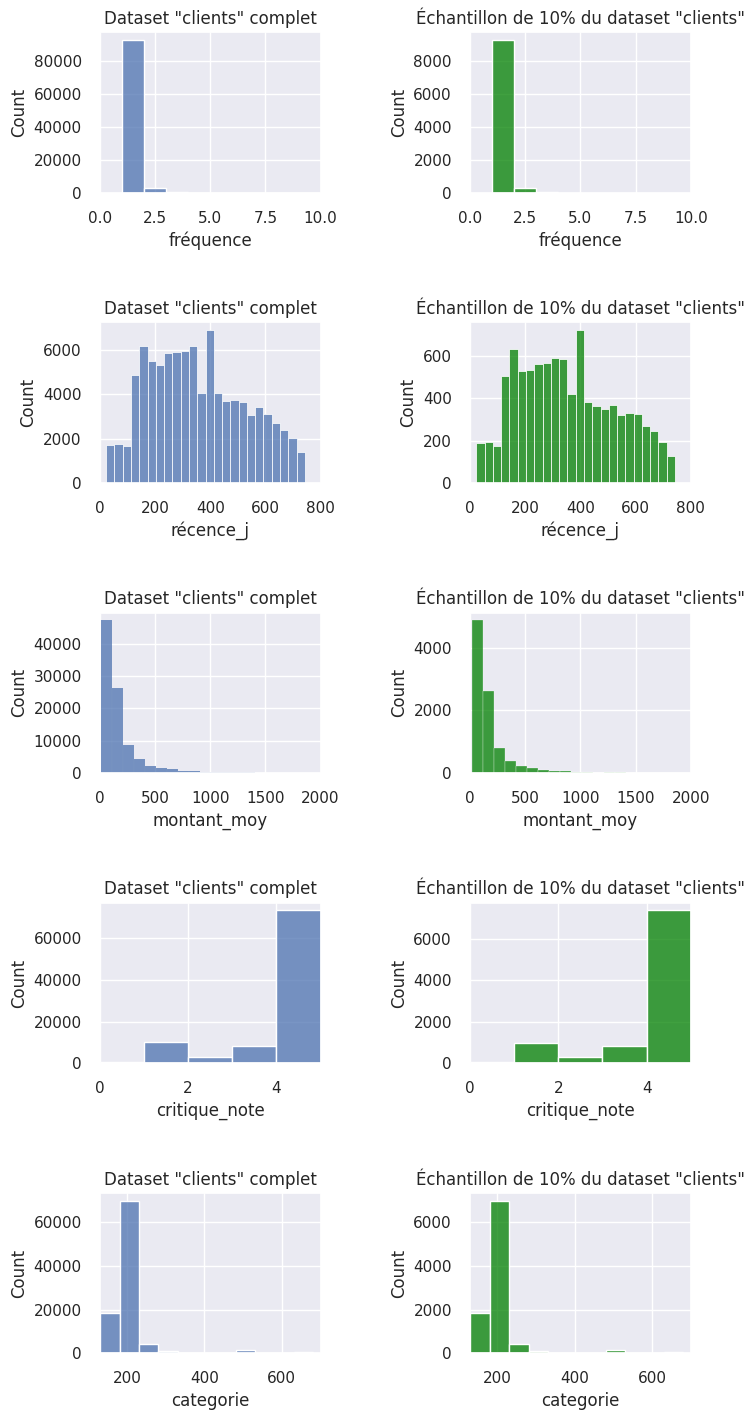

In [16]:
fig, ax = plt.subplots(len(col),2, figsize=(8,15))
sns.set()
for count,feat in enumerate(col):
  sns.histplot(data = df , x = feat, binwidth = dic_param_plot[feat][2], ax = ax[count,0])
  ax[count,0].set_xlim(dic_param_plot[feat][0], dic_param_plot[feat][1])
  ax[count,0].title.set_text('Dataset "clients" complet')
#_--------------------------------------
  sns.histplot(data = df_sample , x = feat, binwidth = dic_param_plot[feat][2], ax = ax[count,1], color = 'green')
  ax[count,1].set_xlim(dic_param_plot[feat][0], dic_param_plot[feat][1])
  ax[count,1].title.set_text('Échantillon de 10% du dataset "clients"')
fig.tight_layout(pad=3.0)
if len(col_cat) !=0 : 
  fig1, ax1 = plt.subplots(len(col_cat),2, figsize=(12,6))
  sns.set()
  for count,feat in enumerate(col_cat):
    order_= df['categorie'].value_counts().index
    sns.countplot(data = df, y = feat, orient = 'h', order = order_,
                  ax = ax1[0])
    sns.countplot(data = df_sample, y = feat, orient = 'h', order = order_,
                  ax = ax1[1])                 
plt.savefig('/content/Fichier_N2/P5_N2_11_0_set'+str(set_)+'.png', bbox_inches = 'tight')

In [17]:
#Random Sampling 
df = df.sample(frac = 0.1, random_state = 38)

## <a name="C12"> 1.2 Définition du pre-processing </a>

In [18]:
from sklearn.metrics import homogeneity_score, make_scorer, silhouette_score as sc

numeric_transformer =  StandardScaler()
num_features = df.dtypes[df.dtypes != 'object'].index.tolist()
preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, num_features)], remainder='passthrough')

## <a name="C13"> 1.3 Analyse en composantes principales </a>

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [20]:
var_quant = df.dtypes[df.dtypes != object].index

In [21]:
var_quant

Index(['fréquence', 'récence_j', 'montant_moy', 'critique_note', 'categorie'], dtype='object')

In [22]:
set_

3

In [23]:
#Data ------------------
X = df.values
feature = var_quant
ind = df.index
#Scaling ---------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#Vérification-----------
idx = ["mean", "std"]
print(pd.DataFrame(X_scaled).describe().round(2).loc[idx, :])
#ACP -------------------- 
if set_ == 1 : 
  n_components = 3
elif set_ == 2: 
  n_components = 4
elif set_ == 3:
  n_components = 4
pca = PCA(n_components=n_components)
pca.fit(X_scaled) 
pca.explained_variance_ratio_

        0    1    2    3    4
mean -0.0 -0.0 -0.0  0.0 -0.0
std   1.0  1.0  1.0  1.0  1.0


array([0.23952789, 0.20898042, 0.19367147, 0.18835693])

[24. 45. 64. 83.]


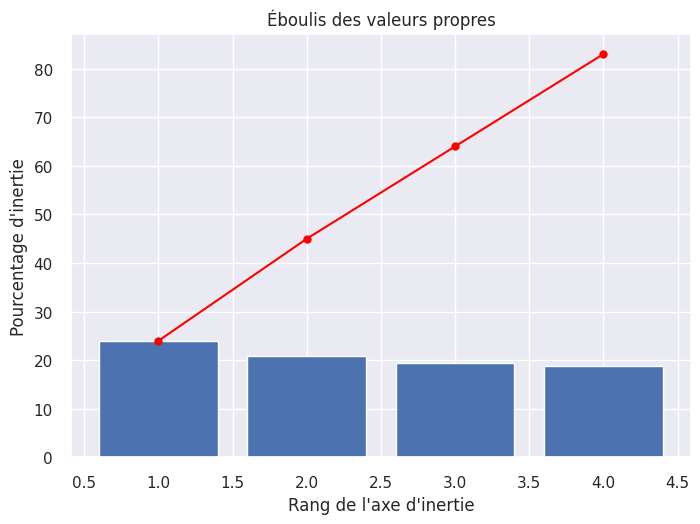

In [24]:
#Éboulis des valeurs propres
scree = (pca.explained_variance_ratio_*100).round(2) #on stocke les contributions dans la variable scree
scree_cum = scree.cumsum().round()
print(scree_cum)

#Définisons ensuite une variable avec la liste de nos composantes :
x_list = range(1, n_components+1)
list(x_list)

fig = plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Éboulis des valeurs propres")
plt.savefig('/content/Fichier_N2/P5_N2_13a_set'+str(set_)+'.png',dpi = 150,bbox_inches = 'tight')


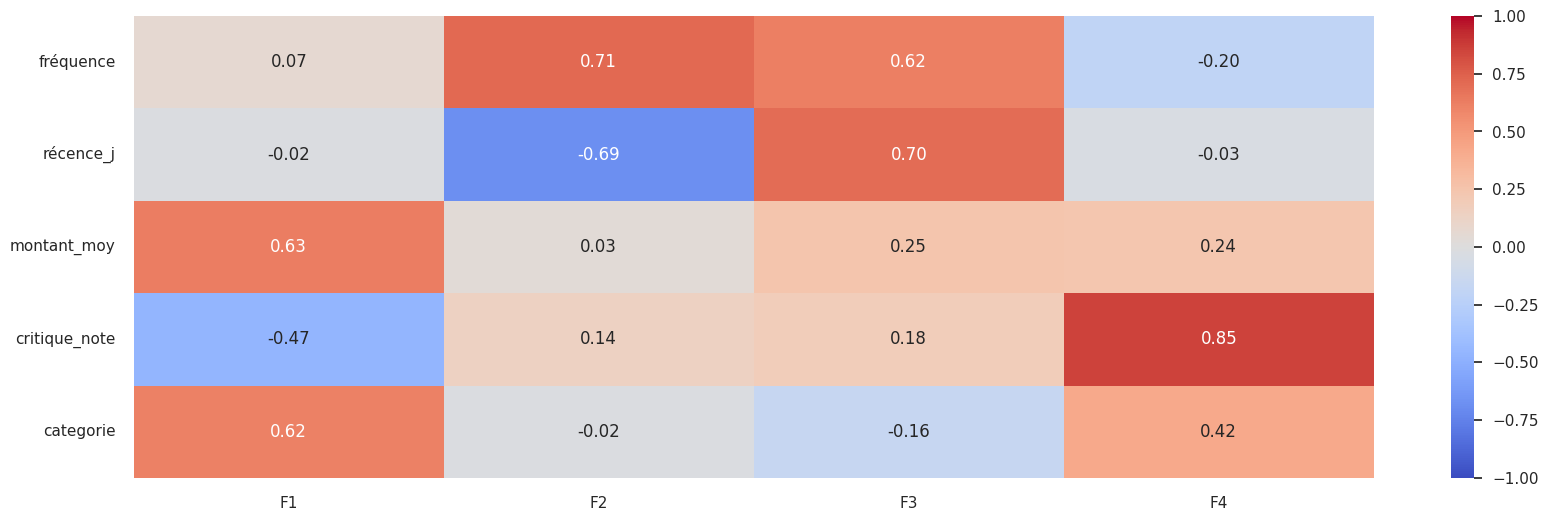

In [25]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = feature
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.savefig('/content/Fichier_N2/P5_N2_13b_set'+str(set_)+'.png',dpi = 150,bbox_inches = 'tight')

In [26]:
X_proj = pca.transform(X_scaled) #Apply dimensionality reduction to X.
X_proj[:5]

array([[-0.51410604,  0.71590068, -0.82588432,  0.56492935],
       [-0.54895193, -0.48925425,  0.45072714,  0.48970647],
       [ 1.09791476, -1.25909001,  0.18527089, -1.85483899],
       [-0.29389897,  0.34833055, -0.34721742,  0.6348272 ],
       [ 0.2130082 , -1.10935003,  0.3899718 , -1.57317685]])

Pour le set_1 := Variables RFM

```
F1 = 'Fidélité récente' 
F2 = 'Dépenses anciennes'
F3 = 'Ancienneté clientèle'
```

---

Pour le set_2 := Variables RFM + profil clients

```
  F1 = 'Trésorerie'
  F2 = '(-) Pouvoir d\'achat'
  F3 = 'Fréquence'
  F4 = 'Dépenses'
```

---

Pour le set_3 := Variables RFM + préférences

```
  F1 = 'Dépenses et catégorie'
  F2 = 'Fidélité récente'
  F3 = 'Fidélité ancienne'
  F4 = 'Note'
```




# <a name="C2"> 2. Essais 1 : K-means</a>

## <a name="C20"> 2.0 Choix du nombre de classes *k* </a>

In [27]:
df.head()

fréquence  récence_j  montant_moy  critique_note  categorie
5054           1        160        80.31            5.0     205.13
37580          1        476       113.45            5.0     199.65
51563          1        565       105.89            1.0     227.55
81880          1        259       216.38            5.0     205.13
56353          1        557        71.14            2.0     181.28



---
Stratégie : Calculer la somme des inerties intra-classe et choisir le nombre de classe *k* pour laquelle la somme des inerties chute radicalement (technique du coude).


In [28]:
#### Initialisation des variables et dataframe de sortie 
ls_nb_clusters = np.arange(2, 20)
inertie = pd.DataFrame(columns = ['k','Inertie totale', 'Silhouette'])
####------------------------------------
#### Boucles sur le nombre de classes k
for count, k in enumerate(ls_nb_clusters):
  inertie.loc[len(inertie), 'k'] = k
  ######------------ Feature Engineering set_ 1 / Variable RFM uniquement. 
  K_means_pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('K_means_1', sklearn.cluster.KMeans(n_clusters=k))])
  K_means_pipe.fit(df)
  clusters = K_means_pipe.named_steps.K_means_1.labels_
  inertie.loc[count, 'Inertie totale'] = K_means_pipe.named_steps.K_means_1.inertia_
  inertie.loc[count, 'Silhouette'] = metrics.silhouette_score(X_scaled, clusters, metric = 'euclidean') 

In [29]:
inertie.head()

k Inertie totale Silhouette
0  2   39834.657281   0.389626
1  3   31172.415932   0.462341
2  4   23954.429752    0.40517
3  5   18645.847134   0.369371
4  6   14159.643745   0.381474

- ### Elbow technique 

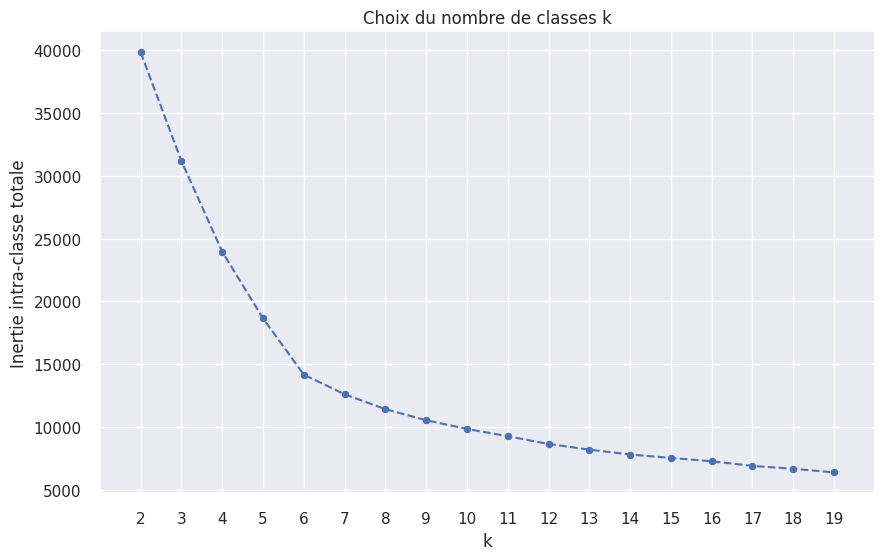

In [30]:
sns.set()
g, ax = plt.subplots(figsize=(10,6))
g = sns.lineplot(data = inertie, x = 'k', y = 'Inertie totale',ls = '--')
h = sns.scatterplot(data = inertie, x = 'k', y = 'Inertie totale')
g.set(xlim=(1,20),xticks=ls_nb_clusters)
ax.set_ylabel('Inertie intra-classe totale')
plt.title("Choix du nombre de classes k")
plt.savefig('/content/Fichier_N2/P5_N2_20a_set_'+str(set_)+'.png', bbox_inches = 'tight')

- ### Score silhouette 

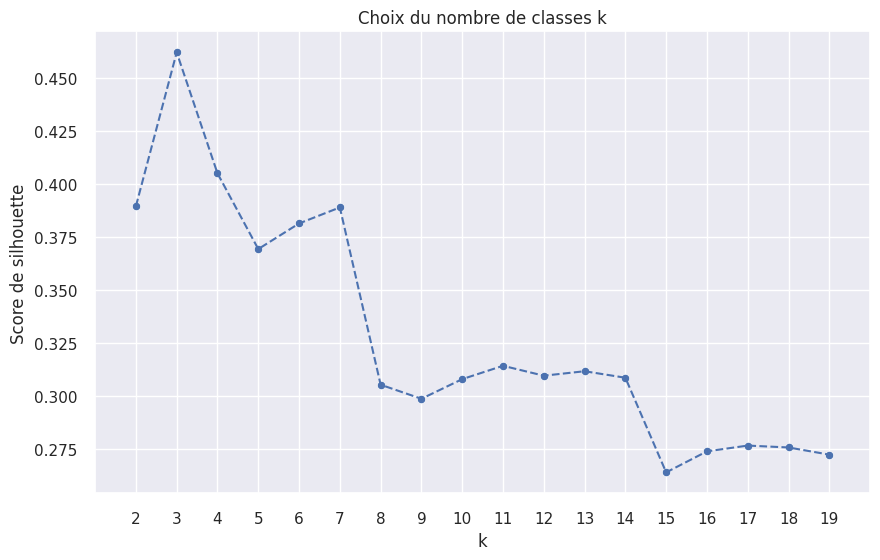

In [31]:
sns.set()
g, ax = plt.subplots(figsize=(10,6))
g = sns.lineplot(data = inertie, x = 'k', y = 'Silhouette',ls = '--')
h = sns.scatterplot(data = inertie, x = 'k', y = 'Silhouette')
g.set(xlim=(1,20),xticks=ls_nb_clusters)
ax.set_ylabel('Score de silhouette')
plt.title("Choix du nombre de classes k")
plt.savefig('/content/Fichier_N2/P5_N2_20b_set_'+str(set_)+'.png', bbox_inches = 'tight')

## <a name="C21"> 2.1 Grille de recherche des hyperparamètres optimaux </a>

In [32]:
df.head()

fréquence  récence_j  montant_moy  critique_note  categorie
5054           1        160        80.31            5.0     205.13
37580          1        476       113.45            5.0     199.65
51563          1        565       105.89            1.0     227.55
81880          1        259       216.38            5.0     205.13
56353          1        557        71.14            2.0     181.28

In [33]:
##Grille de paramamètre -- Définition par le produit caratésien des paramètres que l'on veut tester
if set_== 1:
  ls_nb_clusters = np.arange(4, 5) #valeurs testées aussi : 3
elif set_ == 2:
  ls_nb_clusters = np.arange(5,6) #valeurs testées aussi : 3, 5, 6
elif set_ == 3:
  ls_nb_clusters = np.arange(4, 5) #valeurs testées aussi : 3, 5, 6, 7, 8
import itertools
param_grid = {'n_clusters' : ls_nb_clusters,
              'init': ['k-means++', 'random'],
              'algorithm' :['lloyd', 'elkan'],
              'n_init' : ['auto', 1,5]} #10, 50, 100]}
param = [] 
for i in itertools.product(param_grid['n_clusters'],param_grid['init'], param_grid['algorithm'], param_grid['n_init']):
    param.append(i)

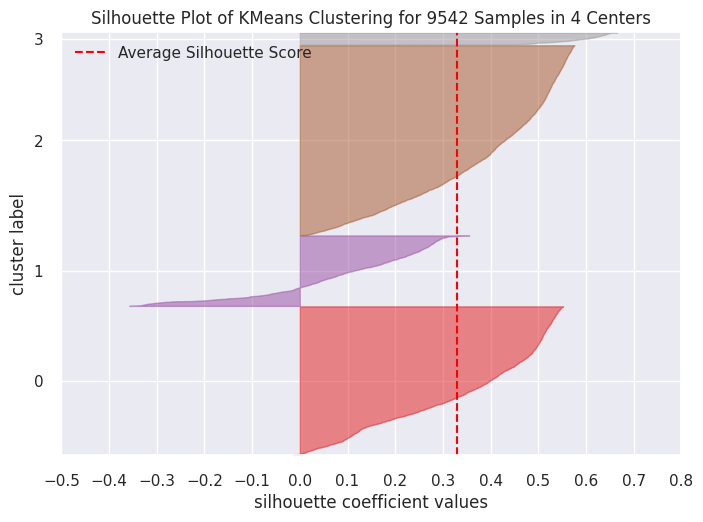

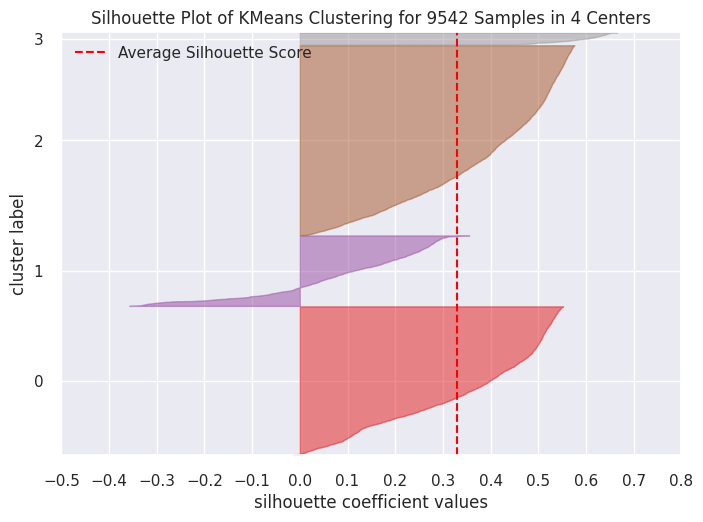

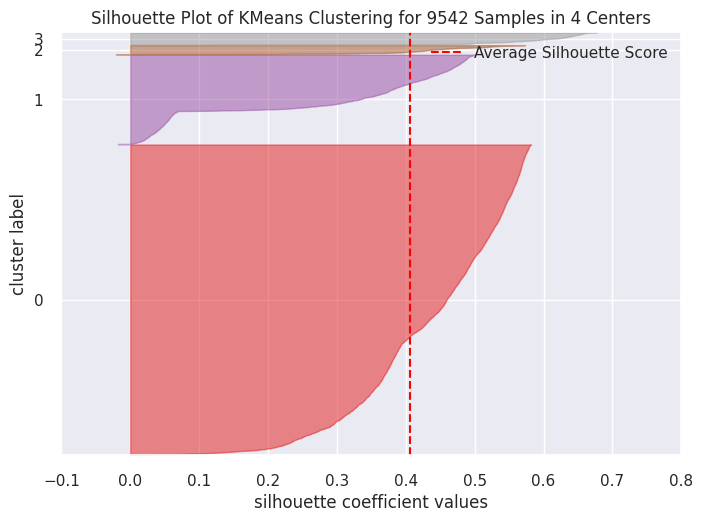

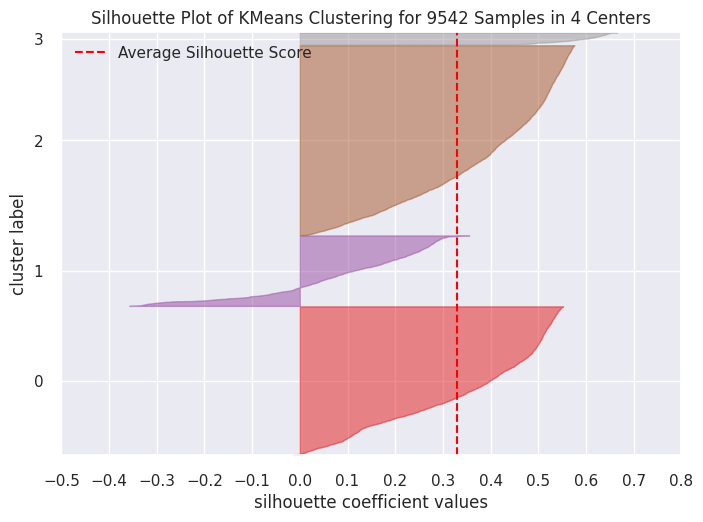

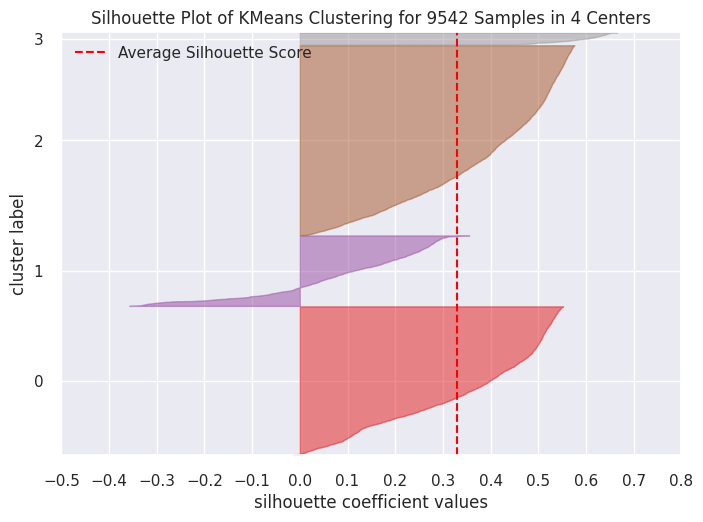

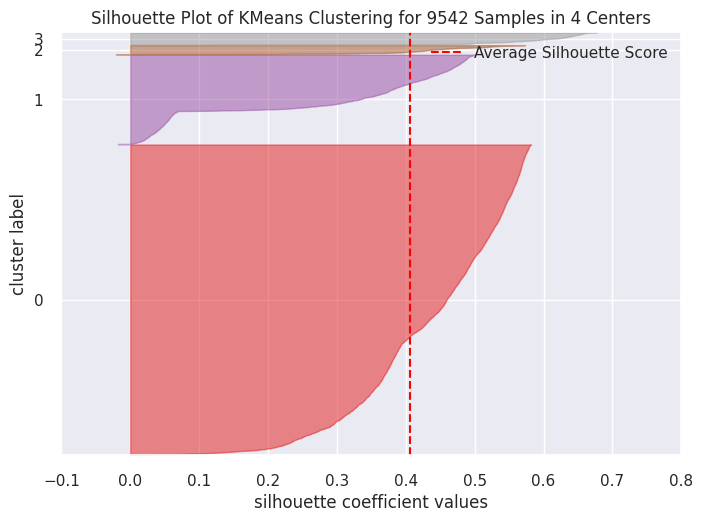

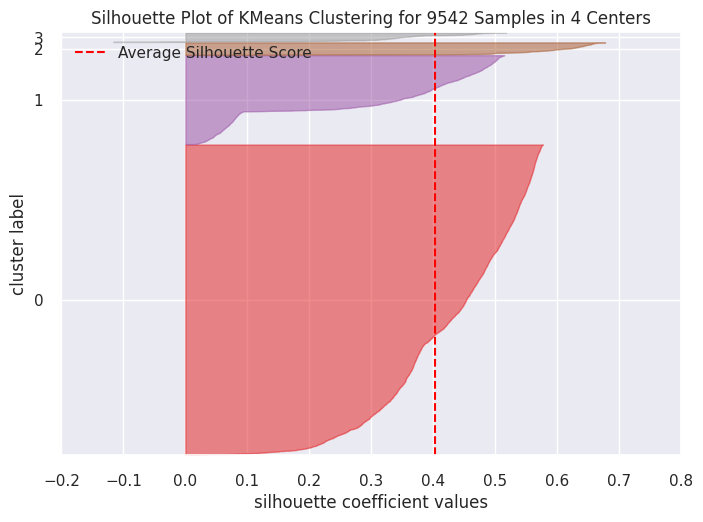

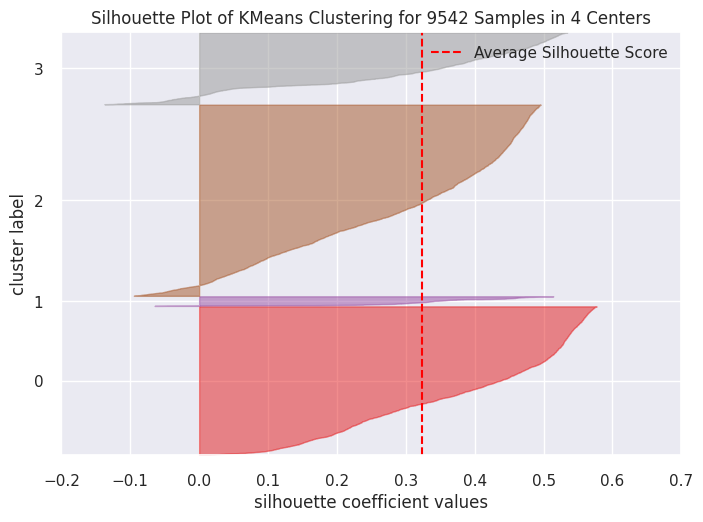

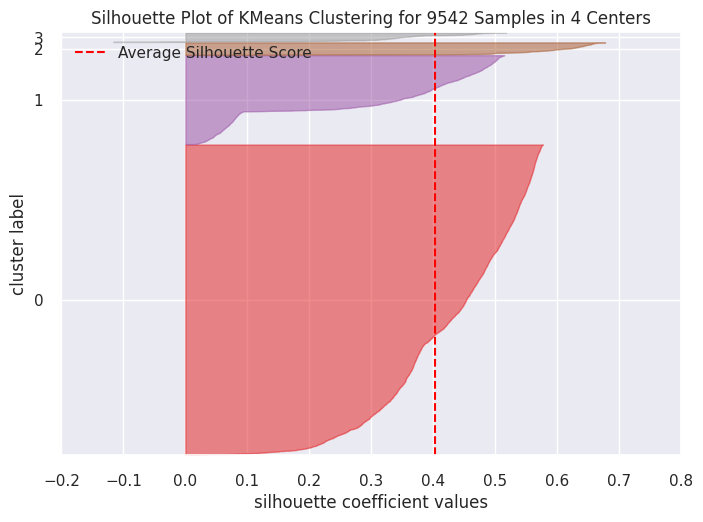

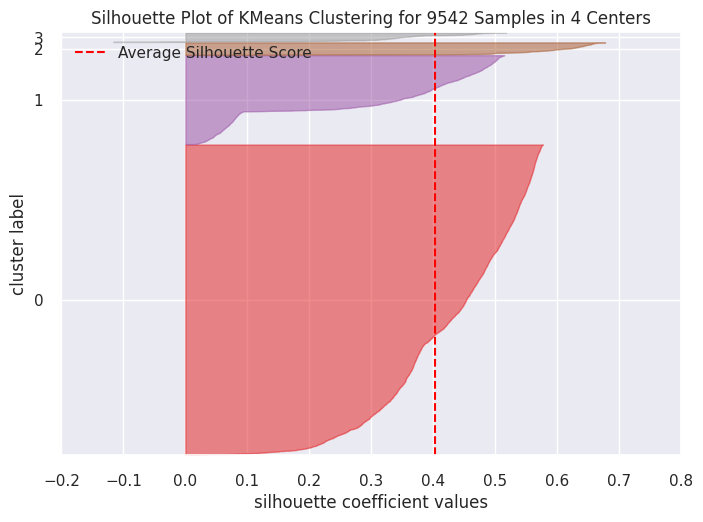

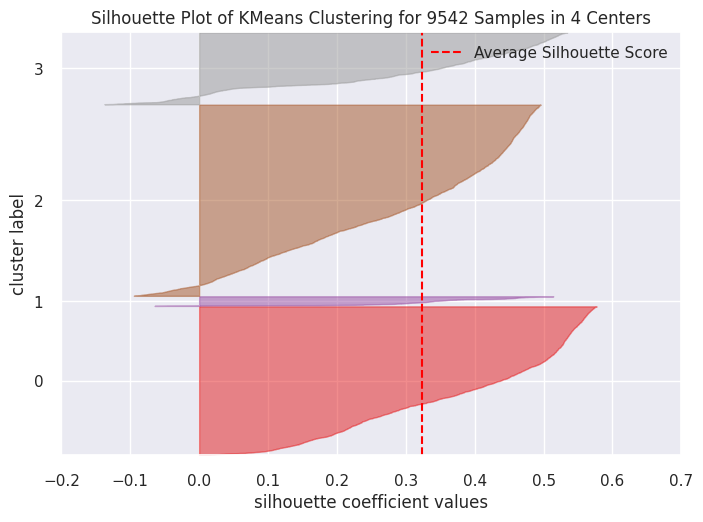

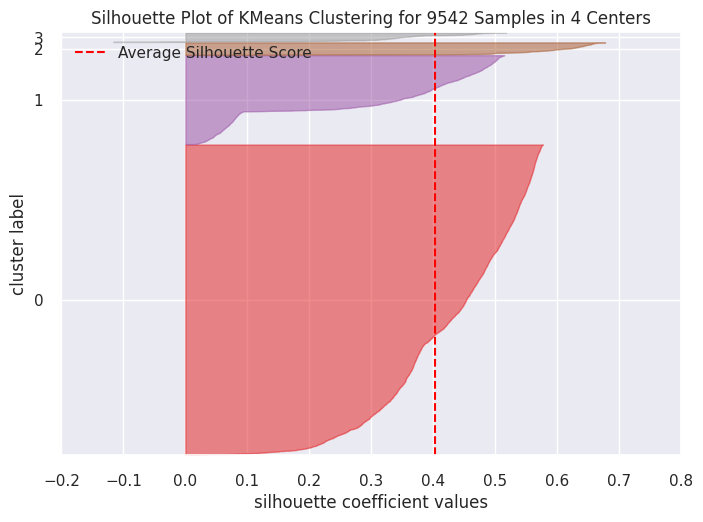

In [34]:
state = 38
score_grid = pd.DataFrame(columns = ['param', 'score'])
columns = ['k='+str(i) for i in ls_nb_clusters] #défnition nom de colonnes de score_sil
score_sil = pd.DataFrame(columns = columns) #Dataframe comprenant pour chaque observation les scores silhouette 
cluster_df = pd.DataFrame(columns = columns)
for comb in param:
  score_grid.loc[len(score_grid), 'param'] = comb 
  K_means_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('K_means_1', sklearn.cluster.KMeans(random_state = state,
                                             n_clusters=comb[0],   
                                             init = comb[1],
                                             algorithm = comb[2],
                                             n_init = comb[3]))])
  K_means_pipe.fit(df)
  clusters = K_means_pipe.named_steps.K_means_1.labels_
  sil = metrics.silhouette_score(X_scaled, clusters, metric = 'euclidean')    
  score_grid.loc[score_grid['param'] == comb, 'score'] = sil
  ### Plot de silhouette 
  cluster_df['k='+str(comb[0])] = clusters
  score_sil['k='+str(comb[0])] = metrics.silhouette_samples(X_scaled, clusters, metric='euclidean') 
  #plot_silhouette([comb[0]], score_sil, cluster_df)
  visualizer = SilhouetteVisualizer(K_means_pipe.named_steps.K_means_1)
  visualizer.fit(X_scaled)    # Fit the data to the visualizer
  visualizer.poof()    # Draw/show/poof the data

In [35]:
score_grid[score_grid['score'] == score_grid['score'].max() ]

param     score
2  (4, k-means++, lloyd, 5)  0.405964
5  (4, k-means++, elkan, 5)  0.405964

In [36]:
score_grid

param     score
0   (4, k-means++, lloyd, auto)  0.330198
1      (4, k-means++, lloyd, 1)  0.330198
2      (4, k-means++, lloyd, 5)  0.405964
3   (4, k-means++, elkan, auto)  0.330198
4      (4, k-means++, elkan, 1)  0.330198
5      (4, k-means++, elkan, 5)  0.405964
6      (4, random, lloyd, auto)  0.402536
7         (4, random, lloyd, 1)  0.323811
8         (4, random, lloyd, 5)  0.402536
9      (4, random, elkan, auto)  0.402536
10        (4, random, elkan, 1)  0.323811
11        (4, random, elkan, 5)  0.402536



---
set_ == 1


Pour le choix du nombre de classe, je choisis *k=4*. 
Je choisie la série de paramètre la moins coûteuse : 


*   Nombre de cluster = 4
*   Initialisation ***random***
*   paramètre lloyd (paramètre par défaut)
*   Nombre d'initialisation = auto
*   La représentation 3D a orienté mon choix 


---
set_ == 2

*   Nombre de cluster = 4
*   Initialisation ***random***
*   paramètre lloyd (paramètre par défaut)
*   Nombre d'initialisation = 1
*   Visuellement la répartition des scores de silhouette m'indique que le clustering avec k = 4 est le plus adapté.

---
set_ == 3

*   Nombre de cluster = 4
*   Initialisation ***k_means++***
*   paramètre lloyd (paramètre par défaut)
*   Nombre d'initialisation = 5
*   Visuellement la répartition des scores de silhouette m'indique que le clustering avec  k = 4 est le plus adapté.

## <a name="C22"> 2.2 Résultats </a>

In [37]:
#df = df.drop(columns = ['clusters'])

In [38]:
if set_==1:
  best_param = score_grid.loc[6,'param']
  best_param = (4, 'random', 'lloyd', 1)
elif set_==2:
  best_param = score_grid.loc[0,'param']
  best_param = (5, 'random', 'elkan', 1)
elif set_==3:
  best_param = score_grid.loc[2,'param']
  best_param = (4, 'k-means++', 'lloyd', 5)


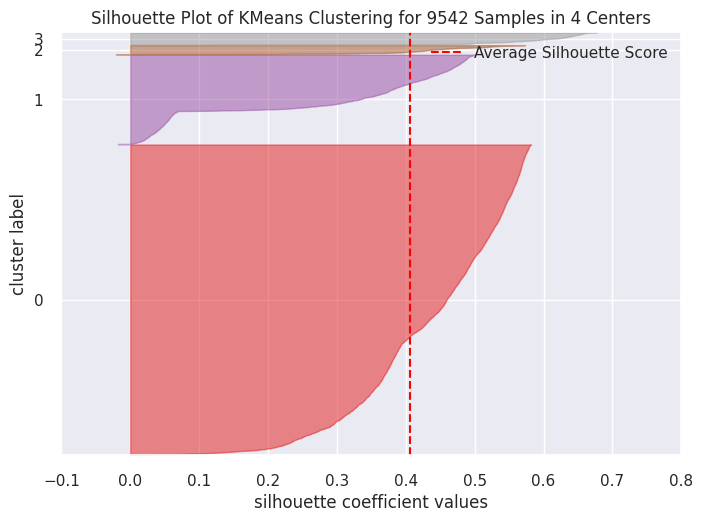

In [39]:
state = 38
sil = 0
K_means_pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('K_means_1', sklearn.cluster.KMeans(n_clusters=best_param[0],
                                             random_state = state,
                                             init = best_param[1],
                                             algorithm = best_param[2],
                                             n_init = best_param[3]))])

start_time = time.time()
K_means_pipe.fit(df)
end_time = time.time()
fit_time = end_time-start_time
clusters = K_means_pipe.named_steps.K_means_1.labels_
visualizer = SilhouetteVisualizer(K_means_pipe.named_steps.K_means_1)
visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show(outpath='/content/Fichier_N2/P5_N2_22_0_set_'+str(set_)+'.png')
sil = metrics.silhouette_score(X_scaled, clusters)
df['clusters'] = clusters


For n_clusters = 4 The average silhouette_score is : 0.40596373126677787


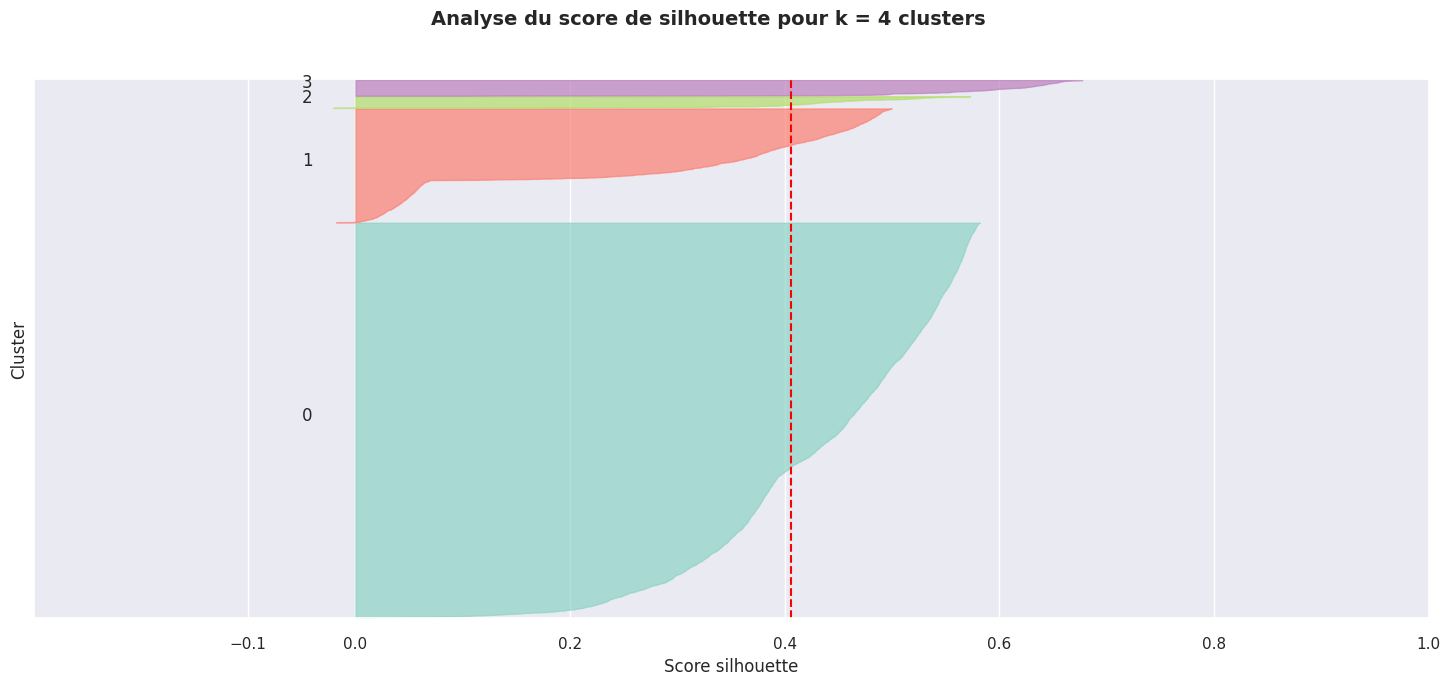

<Figure size 800x550 with 0 Axes>

In [40]:
## Test fonction plot_silhouette implémentée dans mon module plot_
## À utiliser dans la suite car package yellow brick ne fonctionne pas avec CAH et DBSCAN qui n'ont pas de fonction .predict()
k = best_param[0]
plot_.plot_silhouette(X_scaled,clusters,k,'/content/Fichier_N2/P5_N2_22_0_set_'+str(set_)+'bis.png')

In [41]:
df.groupby('clusters')['clusters'].value_counts()

clusters  clusters
0         0           7031
1         1           2024
2         2            207
3         3            280
Name: clusters, dtype: int64

In [42]:
df[df['clusters'] == 3].describe()

fréquence   récence_j  montant_moy  critique_note   categorie  \
count  280.000000  280.000000   280.000000     280.000000  280.000000   
mean     2.085714  316.453571   224.270619       4.124702  200.364286   
std      0.316471  162.023931   516.760429       1.070052   34.827430   
min      2.000000   23.000000    19.620000       1.000000  131.030000   
25%      2.000000  185.000000    78.227500       3.500000  181.280000   
50%      2.000000  301.000000   126.280000       4.500000  205.130000   
75%      2.000000  431.000000   203.662500       5.000000  205.130000   
max      4.000000  727.000000  6983.865000       5.000000  499.840000   

       clusters  
count     280.0  
mean        3.0  
std         0.0  
min         3.0  
25%         3.0  
50%         3.0  
75%         3.0  
max         3.0

- ### Représentation univariée

In [43]:
df.columns

Index(['fréquence', 'récence_j', 'montant_moy', 'critique_note', 'categorie',
       'clusters'],
      dtype='object')

In [44]:
k = best_param[0]

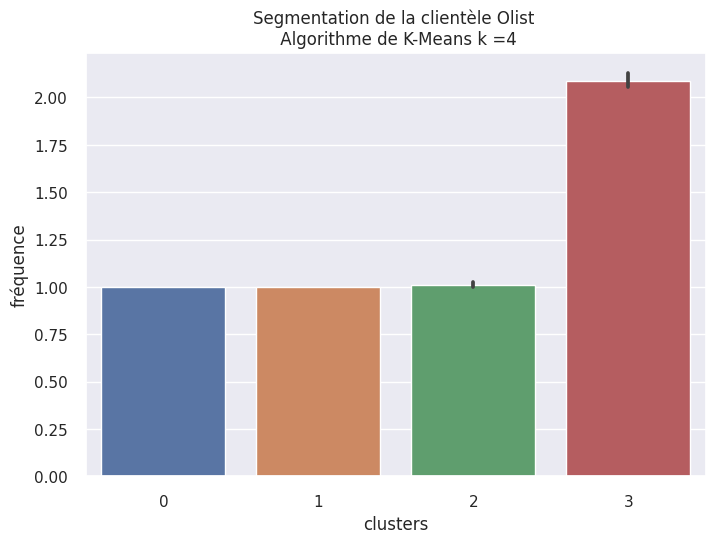

In [45]:
sns.set()
sns.barplot(data = df, x = 'clusters', y= 'fréquence')
plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k ='+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_22a_set'+str(set_)+'.png', bbox_inches = 'tight')


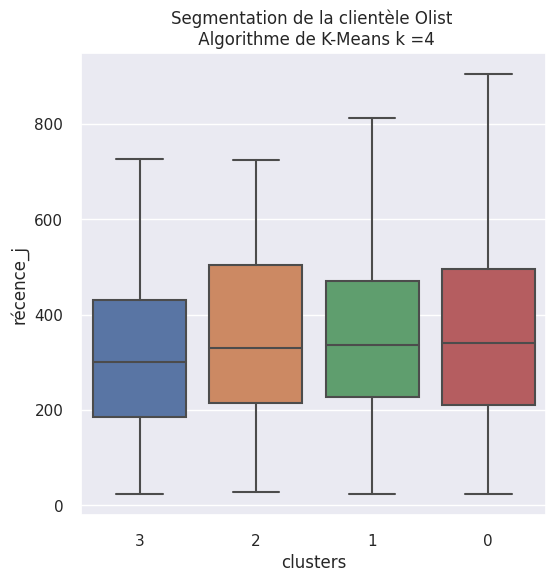

In [46]:
order_ = df.groupby('clusters')['récence_j'].median().sort_values().index
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(data = df, x = 'clusters', y= 'récence_j', showfliers = False, order = order_)
plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k ='+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_22b_set'+str(set_)+'.png', bbox_inches = 'tight')


Text(0.5, 1.0, 'Segmentation de la clientèle Olist \n Algorithme de K-Means k =4')

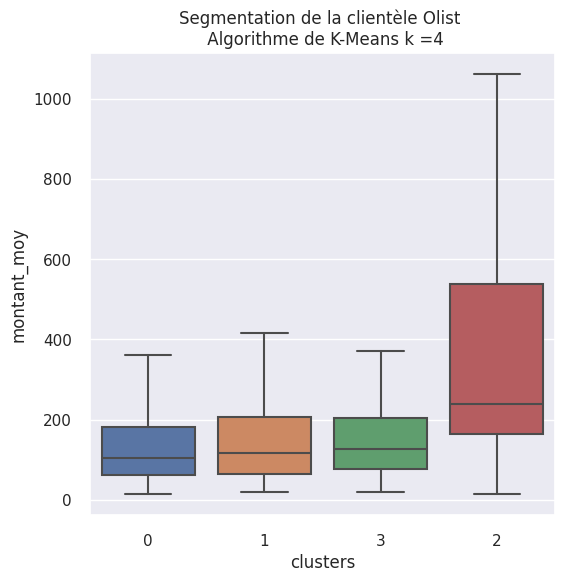

In [47]:
order_ = df.groupby('clusters')['montant_moy'].median().sort_values().index
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(data = df, x = 'clusters', y= 'montant_moy', showfliers = False, order = order_)
plt.savefig('/content/Fichier_N2/P5_N2_22c_set'+str(set_)+'.png', bbox_inches = 'tight')
plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k ='+str(k))

In [48]:
if set_ ==2:
  order_ = df.groupby('clusters')['etat_client'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'etat_client', showfliers = False, order = order_)
  ax.set_ylabel('Revenus moyen mensuel par personne')
  plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_22d_set'+str(set_)+'.png', bbox_inches = 'tight')


In [49]:
if set_ == 2: 
  order_ = df.groupby('clusters')['reste_echeance_mois'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'reste_echeance_mois', showfliers = False,order = order_)
  ax.set_ylabel('Nombre d\'échéances de paiement restant') 
  plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_22e_set'+str(set_)+'.png', bbox_inches = 'tight')

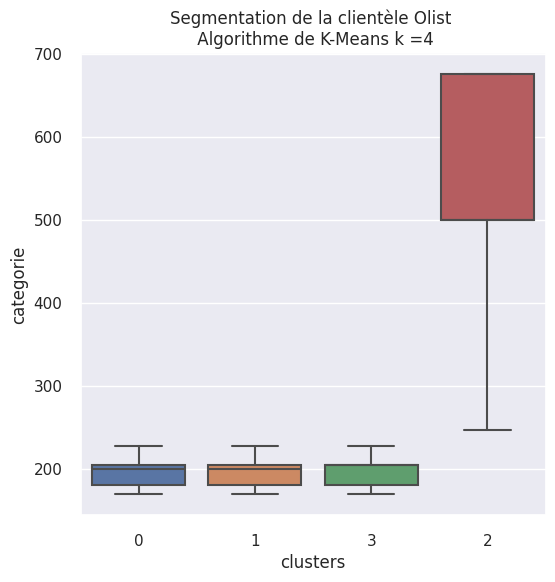

In [50]:
if set_ == 3:
  order_ = df.groupby('clusters')['categorie'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'categorie', showfliers = False, order = order_)
  plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_22d_set'+str(set_)+'.png', bbox_inches = 'tight')


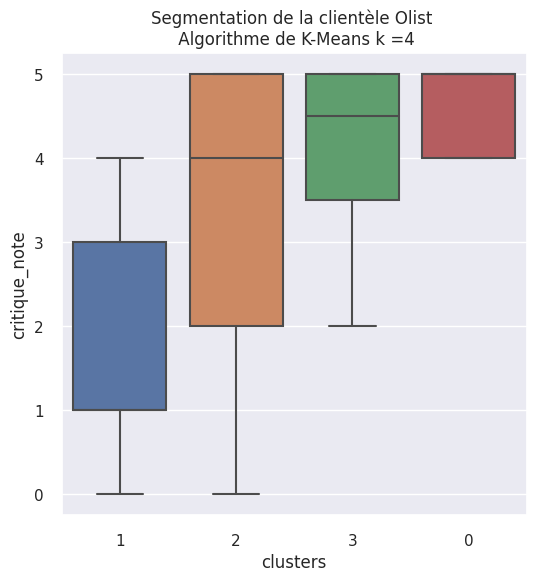

In [51]:
if set_ == 3:
  order_ = df.groupby('clusters')['critique_note'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'critique_note', showfliers = False, order = order_)
  plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_22e_set'+str(set_)+'.png', bbox_inches = 'tight')


In [52]:
df[df['clusters']== 0].describe()

fréquence    récence_j  montant_moy  critique_note    categorie  \
count     7031.0  7031.000000  7031.000000    7031.000000  7031.000000   
mean         1.0   357.405632   172.763266       4.746551   198.028700   
std          0.0   180.454851   244.681035       0.435017    25.016031   
min          1.0    23.000000    13.780000       4.000000   131.030000   
25%          1.0   211.000000    61.600000       4.000000   181.280000   
50%          1.0   341.000000   105.360000       5.000000   199.650000   
75%          1.0   496.000000   181.670000       5.000000   205.130000   
max          1.0   995.000000  4539.960000       5.000000   289.460000   

       clusters  
count    7031.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0

---
set_ ==1 

La répartition des clusters semble convenable : 
Les 282 individus du clusters 1, sont les individus qui passent commande fréquemment. La distinction est cohérente. Les 282/9500 représente bien 3% du dataset. 
```
clusters  clusters
0         0           4040
1         1            282
2         2           5220
```



---
set_ ==2 

```
clusters  clusters
0         0           3208
1         1            282
2         2           1989
3         3           4063
```








In [53]:
centroids = K_means_pipe.named_steps.K_means_1.cluster_centers_
centroids

array([[-1.67398566e-01,  9.66759395e-03, -6.89734808e-02,
         4.90335849e-01, -1.32901831e-01],
       [-1.67398566e-01, -2.17515572e-03,  1.29265559e-01,
        -1.66080184e+00, -1.27826432e-01],
       [-1.16471829e-01, -1.07256621e-02,  9.93259856e-01,
        -4.45590083e-01,  5.94906316e+00],
       [ 5.50001978e+00, -2.19168667e-01,  6.94366115e-02,
         3.06398042e-02, -9.33886423e-02]])

- ### Représentation dans l'espace des composantes principales

Pour le set_1 := Variables RFM

```
F1 = 'Fidélité récente' 
F2 = 'Dépenses anciennes'
F3 = 'Ancienneté clientèle'
```

---

Pour le set_2 := Variables RFM + profil clients

```
  F1 = 'Trésorerie'
  F2 = '(-) Pouvoir d\'achat'
  F3 = 'Fréquence'
  F4 = 'Dépenses'
```

---

Pour le set_3 := Variables RFM + préférences

```
  F1 = 'Dépenses et catégorie'
  F2 = 'Fidélité récente'
  F3 = 'Fidélité ancienne'
  F4 = 'Note'
```










In [54]:
centroid_proj = pca.transform(centroids)
centroid_proj
if set_ ==1 :
  centroid_df = pd.DataFrame(data = centroid_proj, columns = ['F1', 'F2', 'F3'])
else:
  centroid_df = pd.DataFrame(data = centroid_proj, columns = ['F1', 'F2', 'F3','F4'])


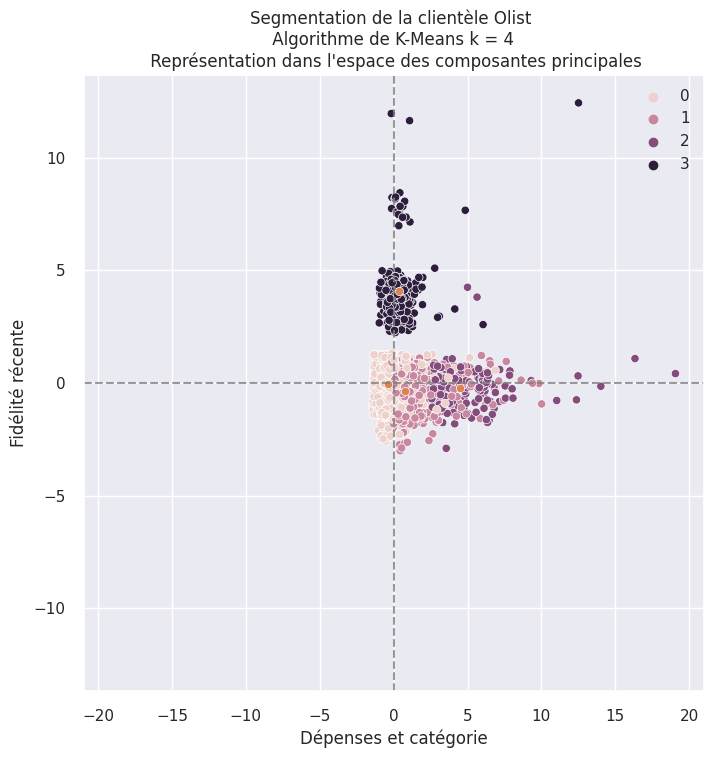

In [55]:
if set_ == 1:
  F1 = 'Fidélité récente' 
  F2 = 'Dépenses anciennes'
  F3 = 'Ancienneté clientèle'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3], index = ind)
elif set_== 2 :
  F1 = 'Trésorerie'
  F2 = '(-) Pouvoir d\'achat'
  F3 = 'Fréquence'
  F4 = 'Dépenses'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
elif set_==3:
  F1 = 'Dépenses et catégorie'
  F2 = 'Fidélité récente'
  F3 = 'Fidélité ancienne'
  F4 = 'Note'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
data_proj['clusters'] = df['clusters']
data_proj

fig, ax = plt.subplots(figsize=(8,8))
sns.set()
sns.scatterplot(data = data_proj,x = F1, y =  F2, hue = 'clusters')
sns.scatterplot(data = centroid_df, x = 'F1', y = 'F2', markers = '^')
# Valeur x max et y max
x_max = np.abs(data_proj[F1]).max() *1.1
y_max = np.abs(data_proj[F2]).max() *1.1

# On borne x et y 
ax.set_xlim(left=-x_max, right=x_max)
ax.set_ylim(bottom= -y_max, top=y_max)

# Affichage des lignes horizontales et verticales
plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')

plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k = '+str(k)+' \n Représentation dans l\'espace des composantes principales')
plt.savefig('/content/Fichier_N2/P5_N2_22_ACP1_set'+str(set_)+'.png', bbox_inches = 'tight')

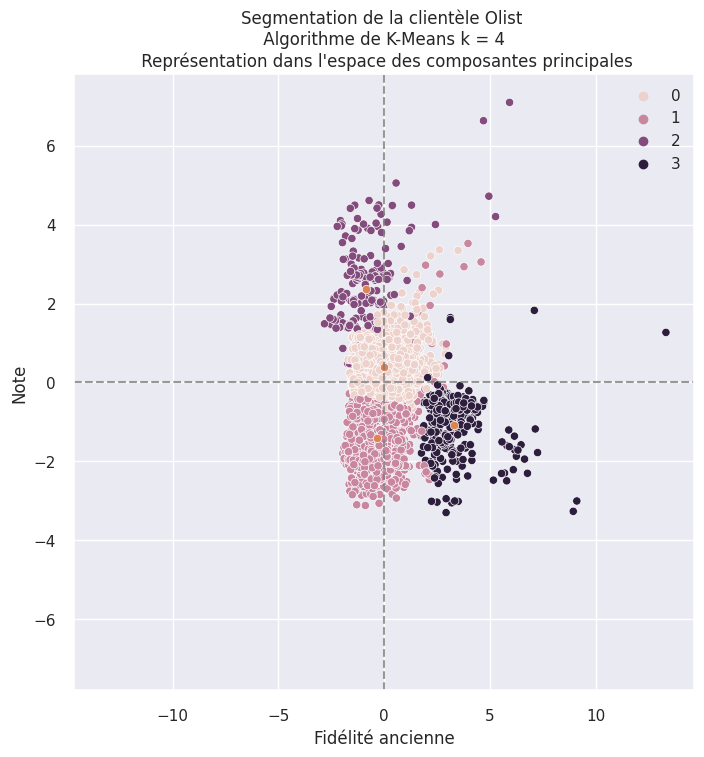

In [56]:
if set_ == 1:
  F1 = 'Fidélité récente' 
  F2 = 'Dépenses anciennes'
  F3 = 'Ancienneté clientèle'
  data_proj = pd.DataFrame(data = X_proj,  columns = [F1, F2, F3], index = ind)
  data_proj['clusters'] = df['clusters']
  fig, ax = plt.subplots(figsize=(8,8))
  sns.set()
  sns.scatterplot(data = data_proj,  x = F2, y = F3, hue = 'clusters')
  sns.scatterplot(data = centroid_df, x = 'F2', y = 'F3', markers = '^')
  # Valeur x max et y max
  x_max = np.abs(data_proj[F2]).max() *1.1
  y_max = np.abs(data_proj[F3]).max() *1.1

  # On borne x et y 
  ax.set_xlim(left=-x_max, right=x_max)
  ax.set_ylim(bottom= -y_max, top=y_max)

  # Affichage des lignes horizontales et verticales
  plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
  plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')
else:
  if set_ == 2:
    F1 = 'Trésorerie'
    F2 = '(-) Pouvoir d\'achat'
    F3 = 'Fréquence'
    F4 = 'Dépenses'
  elif set_==3:
    F1 = 'Dépenses et catégorie'
    F2 = 'Fidélité récente'
    F3 = 'Fidélité ancienne'
    F4 = 'Note'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
  data_proj['clusters'] = df['clusters']
  data_proj
  fig, ax = plt.subplots(figsize=(8,8))
  sns.set()
  data_proj['clusters'] = df['clusters']
  sns.scatterplot(data = data_proj, x = F3, y = F4, hue = 'clusters')
  sns.scatterplot(data = centroid_df, x = 'F3', y = 'F4', markers = '^')
  # Valeur x max et y max
  x_max = np.abs(data_proj[F3]).max() *1.1
  y_max = np.abs(data_proj[F4]).max() *1.1

  # On borne x et y 
  ax.set_xlim(left=-x_max, right=x_max)
  ax.set_ylim(bottom= -y_max, top=y_max)

  # Affichage des lignes horizontales et verticales
  plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
  plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')
  
plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k = '+str(k)+' \n Représentation dans l\'espace des composantes principales')
plt.savefig('/content/Fichier_N2/P5_N2_22_ACP2_set'+str(set_)+'.png', bbox_inches = 'tight')

- ### Représentation 3D

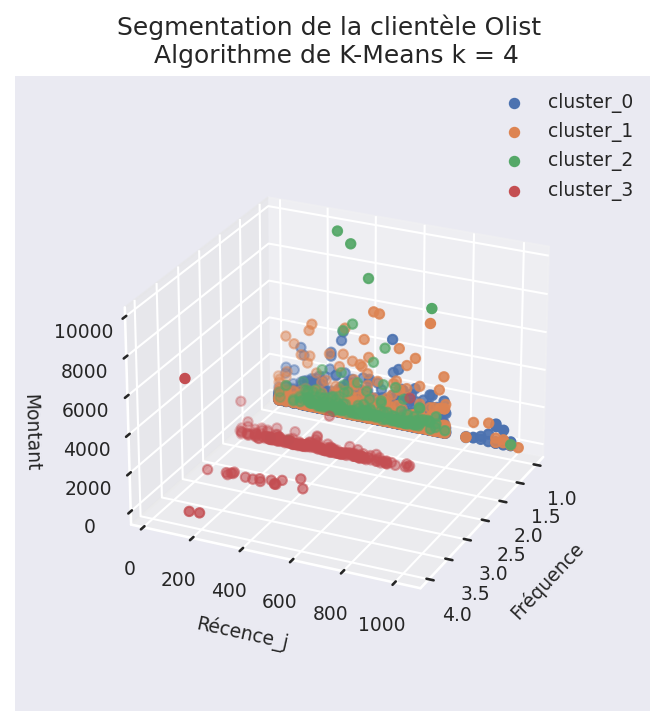

In [57]:
#Plot3D

fig = plt.figure(dpi =150)
ax = fig.add_subplot(projection='3d')
for clust in range(k):
    df_tamp = df[df['clusters']== clust]
    xs = df_tamp['fréquence']
    ys = df_tamp['récence_j']
    zs = df_tamp['montant_moy']
    ax.scatter(xs, ys, zs, marker='o', label = 'cluster_'+str(clust))
ax.legend(fontsize = 9)
ax.set_xlabel('Fréquence', labelpad = 14, fontsize = 9)
ax.set_ylabel('Récence_j',labelpad = 14, fontsize = 9)
ax.set_zlabel('Montant',labelpad = 14, fontsize = 9)
ax.tick_params(labelsize=9)
ax.view_init(elev=25., azim=25, roll=0)
ax.dist = 13
plt.title('Segmentation de la clientèle Olist \n Algorithme de K-Means k = '+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_22_3D_a_set'+str(set_)+'.png', bbox_inches = 'tight')

In [58]:
df

fréquence  récence_j  montant_moy  critique_note  categorie  clusters
5054           1        160        80.31            5.0     205.13         0
37580          1        476       113.45            5.0     199.65         0
51563          1        565       105.89            1.0     227.55         1
81880          1        259       216.38            5.0     205.13         0
56353          1        557        71.14            2.0     181.28         1
...          ...        ...          ...            ...        ...       ...
34112          1        491        47.59            4.0     205.13         0
40015          1         54        30.13            3.0     183.83         1
67763          1        332        34.75            4.0     169.58         0
18137          1        723       135.92            5.0     198.68         0
42206          1         56       220.03            4.0     199.65         0

[9542 rows x 6 columns]

In [59]:
df['clusters'].unique().tolist()

[0, 1, 3, 2]

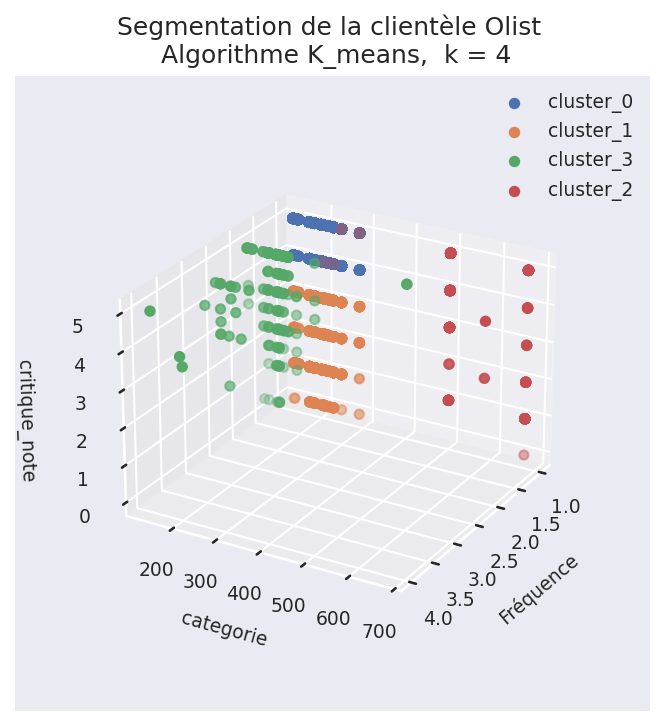

In [60]:
if set_!=1:
  fig = plt.figure(dpi =150)
  ax = fig.add_subplot(projection='3d')
  ls_clust = df['clusters'].unique().tolist()
  for clust in ls_clust:
    df_tamp = df[df['clusters']== clust]
    xs = df_tamp['fréquence']
    ys = df_tamp[num_features[-1]]
    zs = df_tamp[num_features[-2]]
    ax.scatter(xs, ys, zs, marker='o', label = 'cluster_'+str(clust))
  ax.legend(fontsize = 9)
  ax.set_xlabel('Fréquence', labelpad = 14, fontsize = 9)
  ax.set_ylabel(str(num_features[-1]),labelpad = 14, fontsize = 9)
  ax.set_zlabel(str(num_features[-2]),labelpad = 14, fontsize = 9)
  ax.tick_params(labelsize=9)
  ax.view_init(elev=25., azim=30, roll=0)
  ax.dist = 13
  plt.title('Segmentation de la clientèle Olist \n Algorithme K_means,  k = '+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_22_3D_b_set'+str(set_)+'.png', bbox_inches = 'tight')

- ### Tableau comparatif

In [61]:
score_model = pd.DataFrame(index = ['K_means', 'CAH', 'DBSCAN', 'MIXTE'], columns = ['Silhouette','Temps_calcul'])
score_model.loc['K_means','Silhouette'] = sil
score_model.loc['K_means','Temps_calcul'] = fit_time

In [62]:
score_model

Silhouette Temps_calcul
K_means   0.405964      0.32703
CAH            NaN          NaN
DBSCAN         NaN          NaN
MIXTE          NaN          NaN

# <a name="C3">3. Essais 2 :  Classification ascendant hierarchique </a>

## <a name="C30"> 3.0 Choix du nombre de classes *k* </a>

In [63]:
df = df.drop(columns = ['clusters'])

In [64]:
def cal_inertia(clusters, df, X_scaled):
  df_scaled = pd.DataFrame(columns = df.columns.tolist(), data = X_scaled)
  sse = 0
  df_tamp = df_scaled[num_features]
  df_tamp['clusters'] = clusters
  ls_clus = df_tamp['clusters'].unique().tolist()
  #print(ls_clus)
  mobe = df_tamp.groupby('clusters')[num_features].mean()
  for count,clus in enumerate(ls_clus):
    mobe__ = mobe.loc[clus]
    centroid_ = mobe__.values
    #print(centroid_)
    inertie_ic= np.sum(np.square((df_tamp[df_tamp['clusters']==clus][num_features])- centroid_), axis = 1)
    #print(inertie_ic)
    sse += np.sum(inertie_ic)
  #print(sse)
  return sse


In [65]:
#### Initialisation des variables et dataframe de sortie 
inertie = pd.DataFrame(columns = ['k','Inertie totale'])
ls_nb_clusters = np.arange(2, 15)
columns = ['k='+str(i) for i in ls_nb_clusters] #défnition nom de colonnes de score_sil
score_sil = pd.DataFrame(columns = columns) #Dataframe comprenant pour chaque observation les scores silhouette 
cluster_df = pd.DataFrame(columns = columns)
####------------------------------------
#### Boucles sur le nombre de classes k
for count, k in enumerate(ls_nb_clusters):
  inertie.loc[len(inertie), 'k'] = k
  ######------------ Feature Engineering set_ 1 / Variable RFM uniquement. 
  CAH_pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('CAH', sklearn.cluster.AgglomerativeClustering(n_clusters=k))])
  CAH_pipe.fit(df)
  clusters = CAH_pipe.named_steps.CAH.labels_
  inertia_ = cal_inertia(clusters,df,X_scaled)
  inertie.loc[count, 'Inertie totale'] = inertia_

  #plot_.plot_silhouette(X_scaled,clusters,k,'/content/Fichier_N2/P5_N2_TEST.png')

- ### Elbow technique 

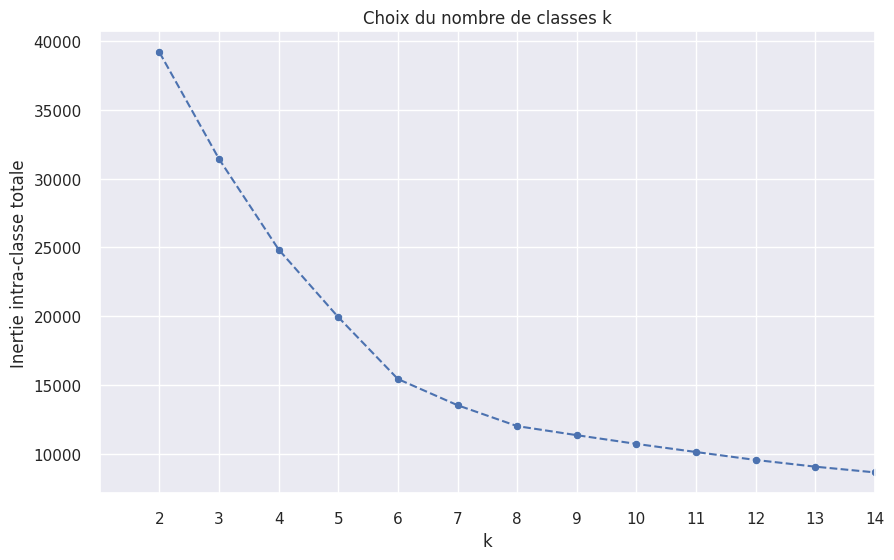

In [66]:
sns.set()
g, ax = plt.subplots(figsize=(10,6))
g = sns.lineplot(data = inertie, x = 'k', y = 'Inertie totale',ls = '--')
h = sns.scatterplot(data = inertie, x = 'k', y = 'Inertie totale')
g.set(xlim=(1,10),xticks=ls_nb_clusters)
ax.set_ylabel('Inertie intra-classe totale')
plt.title("Choix du nombre de classes k")
plt.savefig('/content/Fichier_N2/P5_N2_30a_set_'+str(set_)+'.png', bbox_inches = 'tight')

## <a name="C31"> 3.1 Grille de recherche, des hyperparamètres optimaux </a>

In [67]:
##Grille de paramamètre -- Définition par le produit caratésien des paramètres que l'on veut tester
import itertools
if set_ == 1:
  ls_nb_clusters = [4] #3,4 Hésitation sur le nombre de classes
elif set_ == 2:
  ls_nb_clusters = [4] #3,4,5 Hésitation sur le nombre de classes
elif set_ == 3:
  ls_nb_clusters = [3, 4, 5, 6] #Hésitation sur le nombre de classes

param_grid = {'n_clusters': ls_nb_clusters,
              'linkage': ['ward', 'complete', 'average', 'single']}
param = [] 
for i in itertools.product(param_grid['n_clusters'], param_grid['linkage']):
    param.append(i)

For n_clusters = 3 The average silhouette_score is : 0.6570544816360837


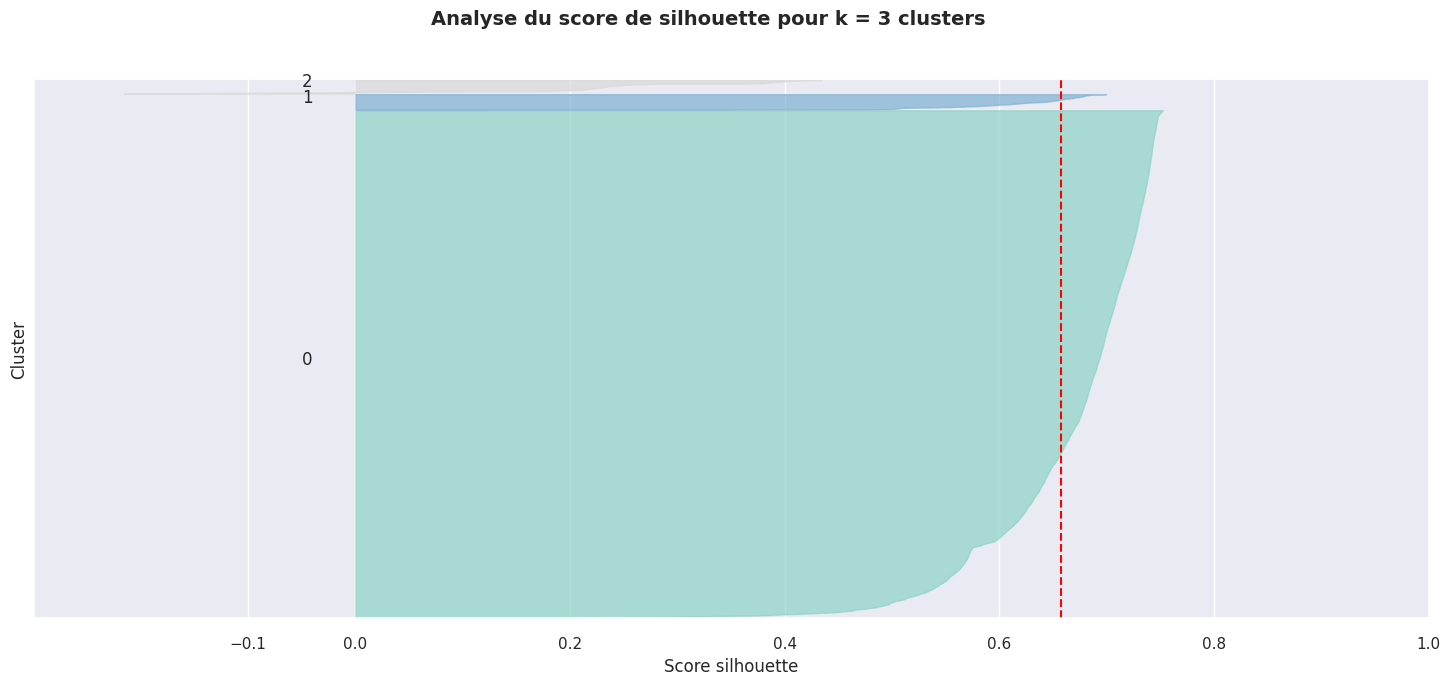

For n_clusters = 3 The average silhouette_score is : 0.7664997802076535


<Figure size 800x550 with 0 Axes>

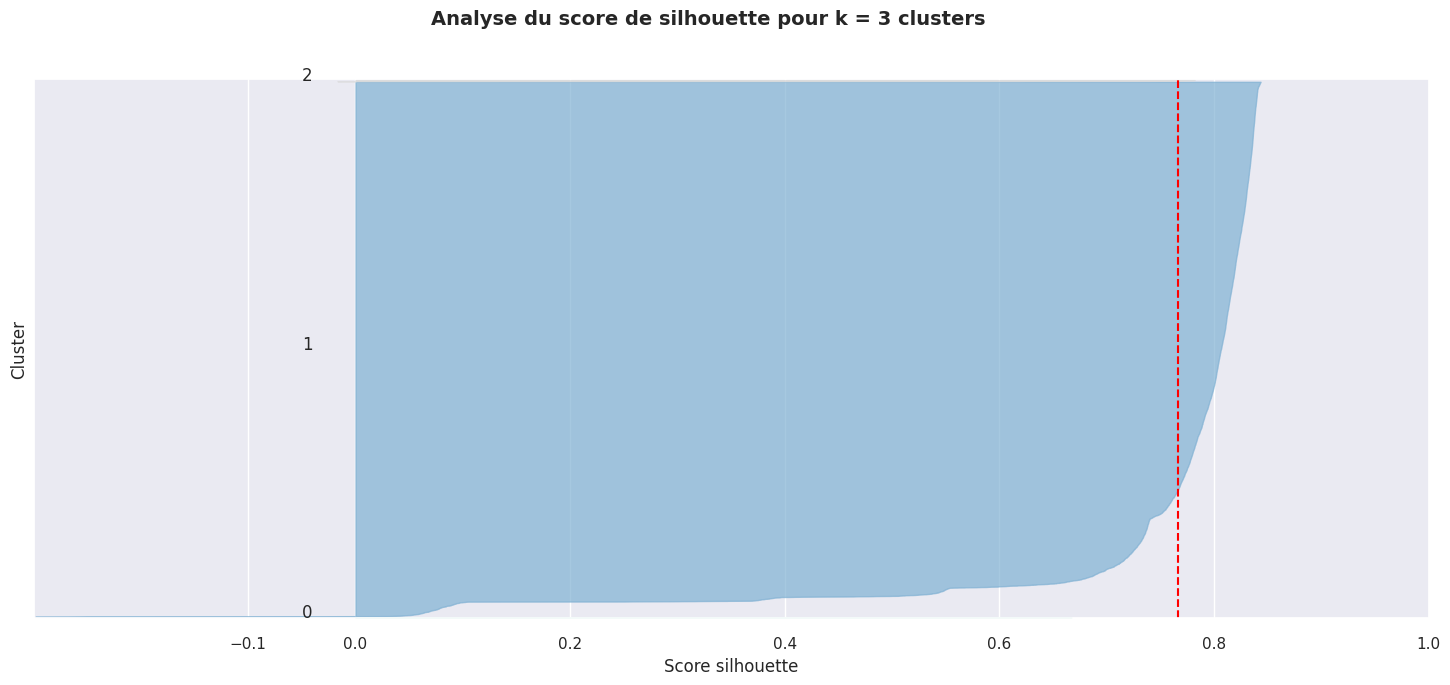

For n_clusters = 3 The average silhouette_score is : 0.8942013990463663


<Figure size 800x550 with 0 Axes>

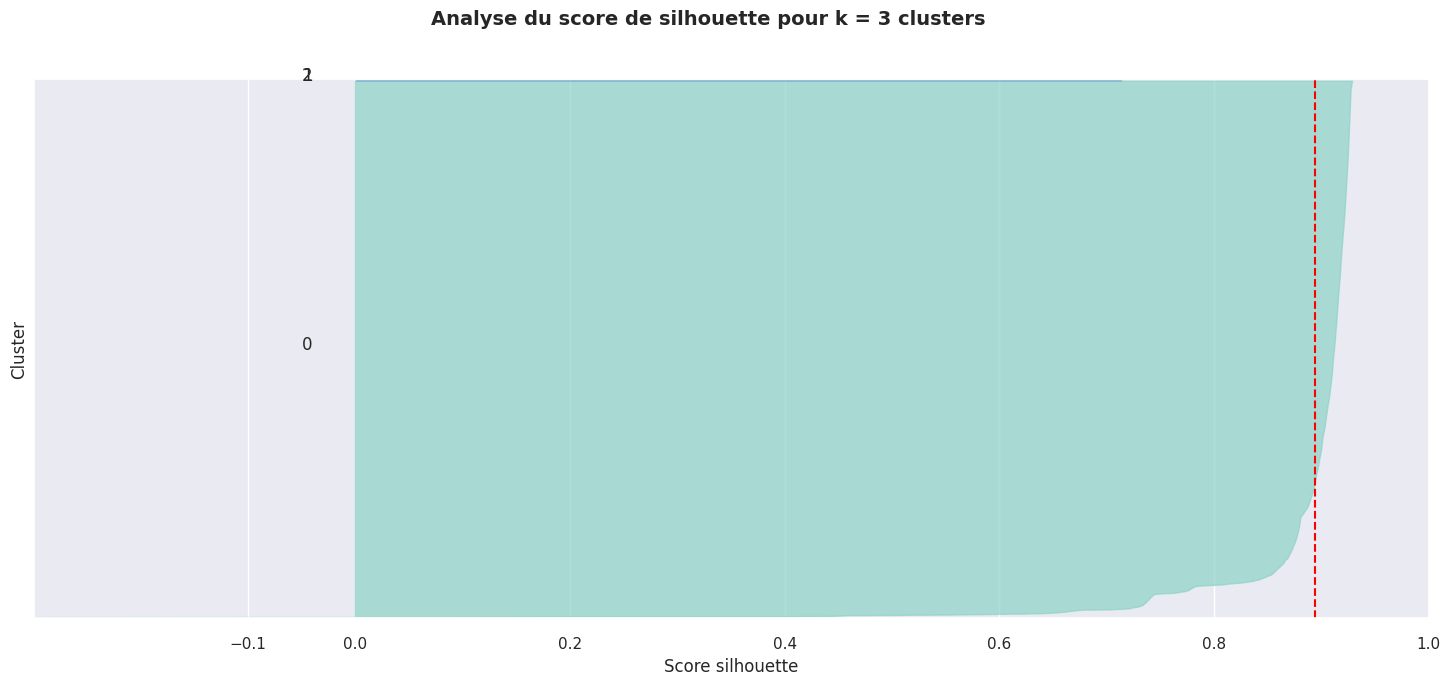

For n_clusters = 3 The average silhouette_score is : 0.8942013990463663


<Figure size 800x550 with 0 Axes>

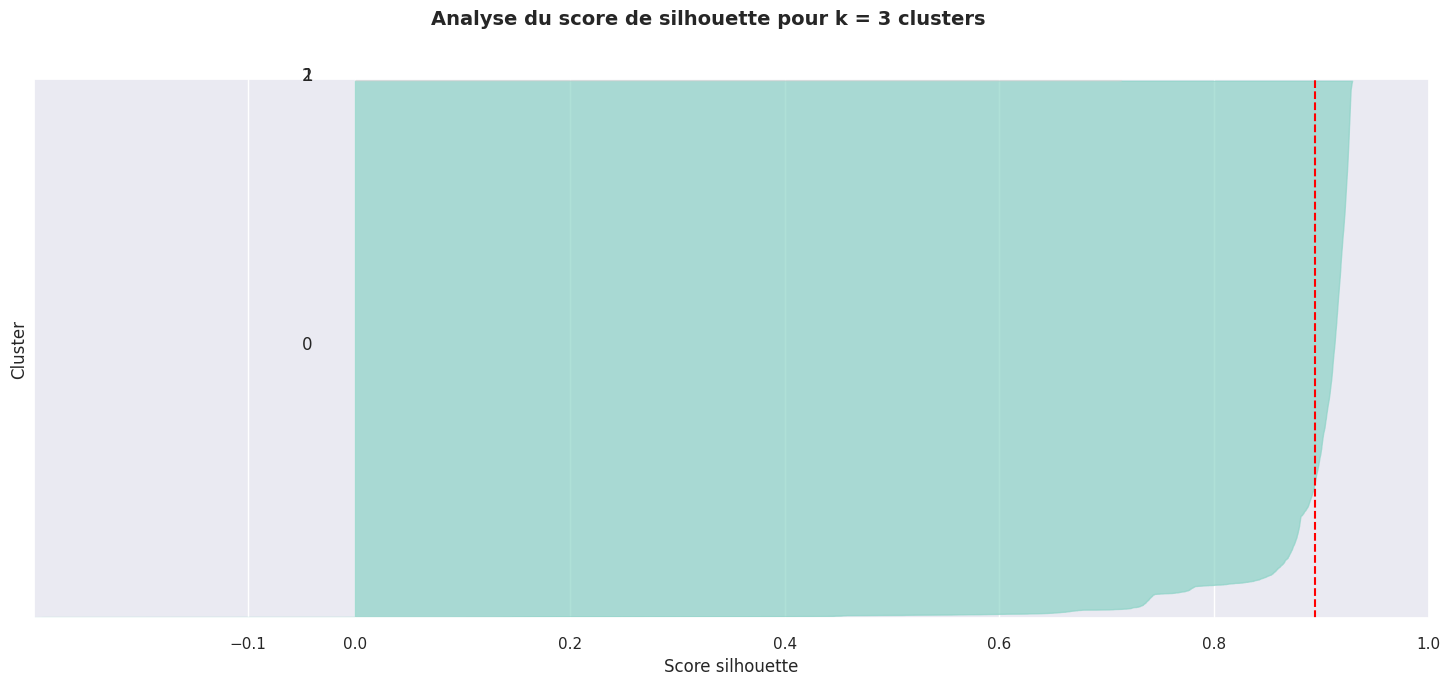

For n_clusters = 4 The average silhouette_score is : 0.43346474298928606


<Figure size 800x550 with 0 Axes>

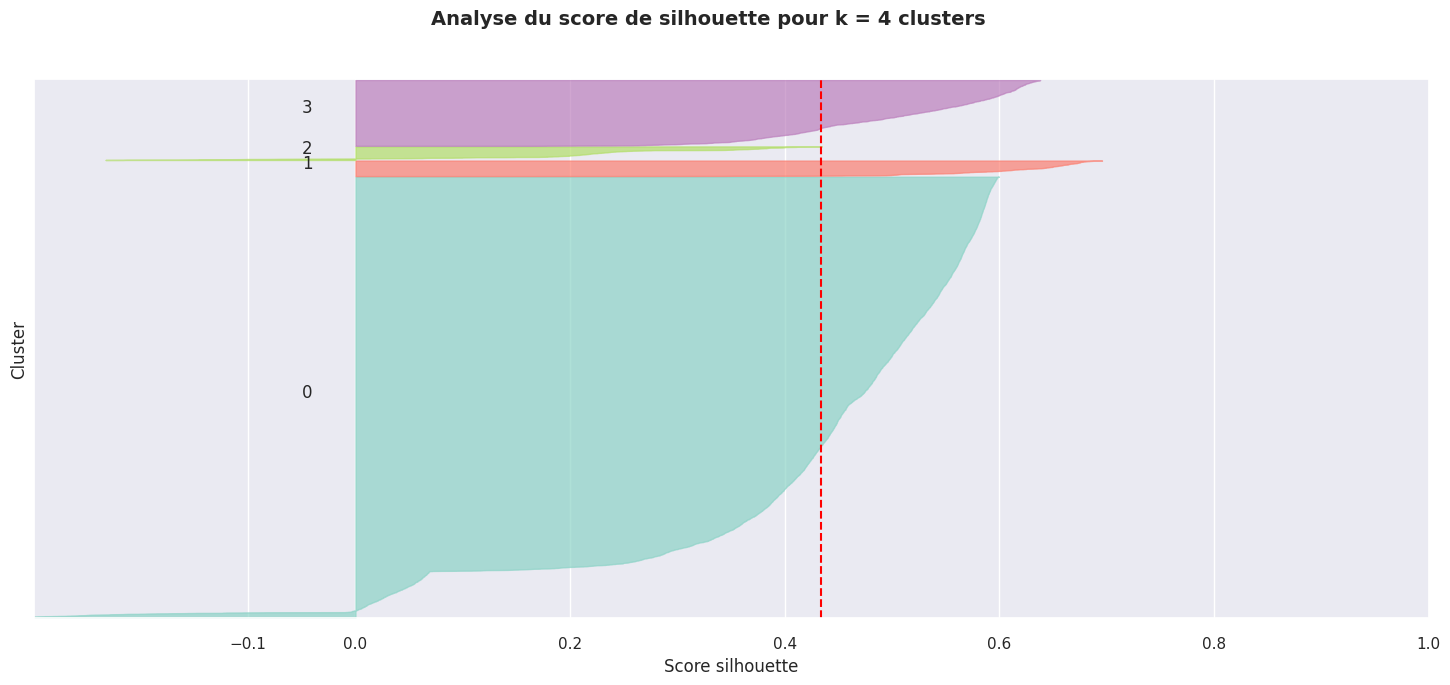

For n_clusters = 4 The average silhouette_score is : 0.7662979086067964


<Figure size 800x550 with 0 Axes>

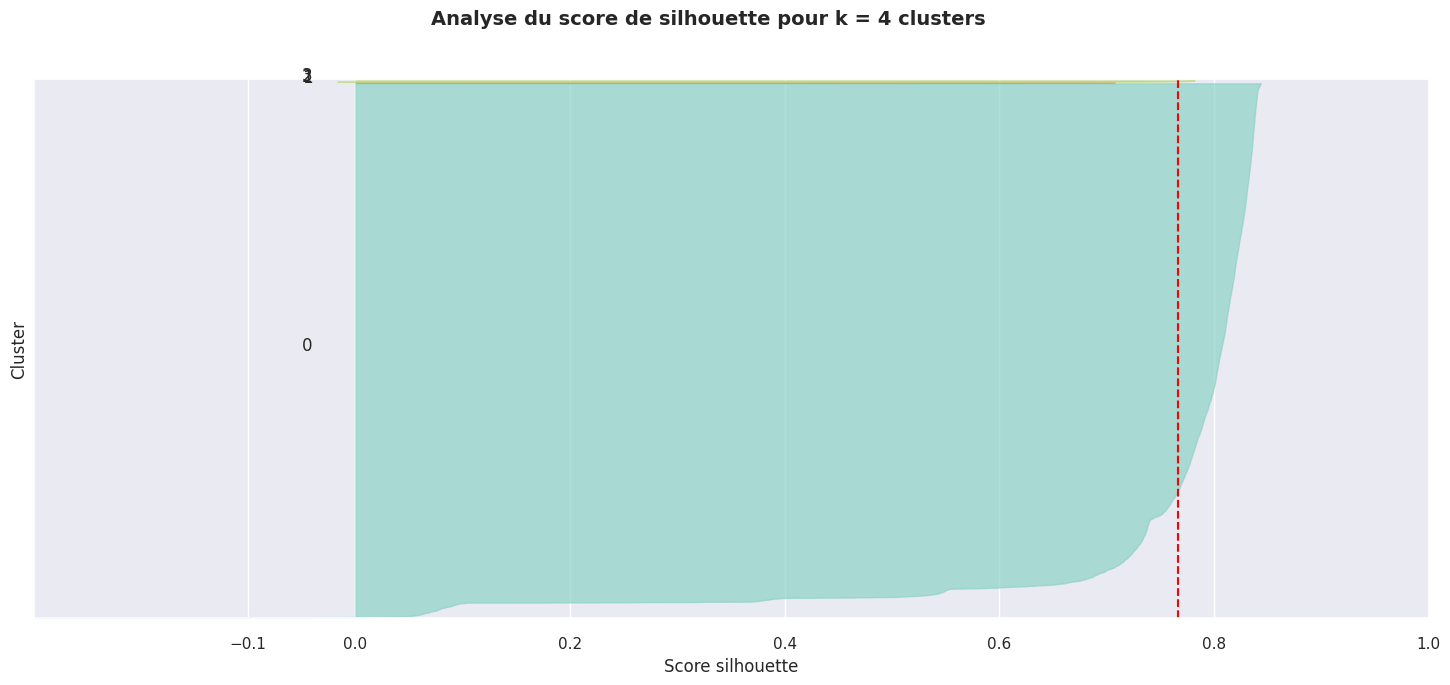

For n_clusters = 4 The average silhouette_score is : 0.7724196426836638


<Figure size 800x550 with 0 Axes>

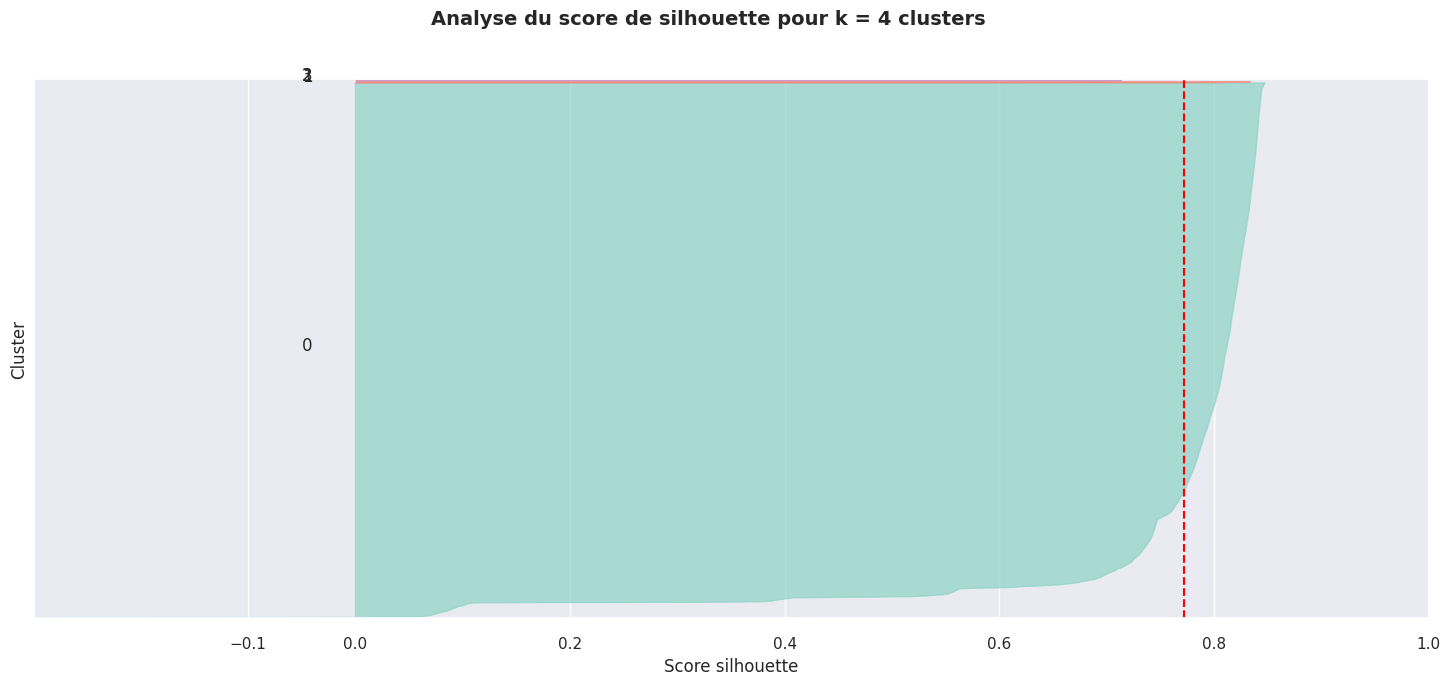

For n_clusters = 4 The average silhouette_score is : 0.7762646161393741


<Figure size 800x550 with 0 Axes>

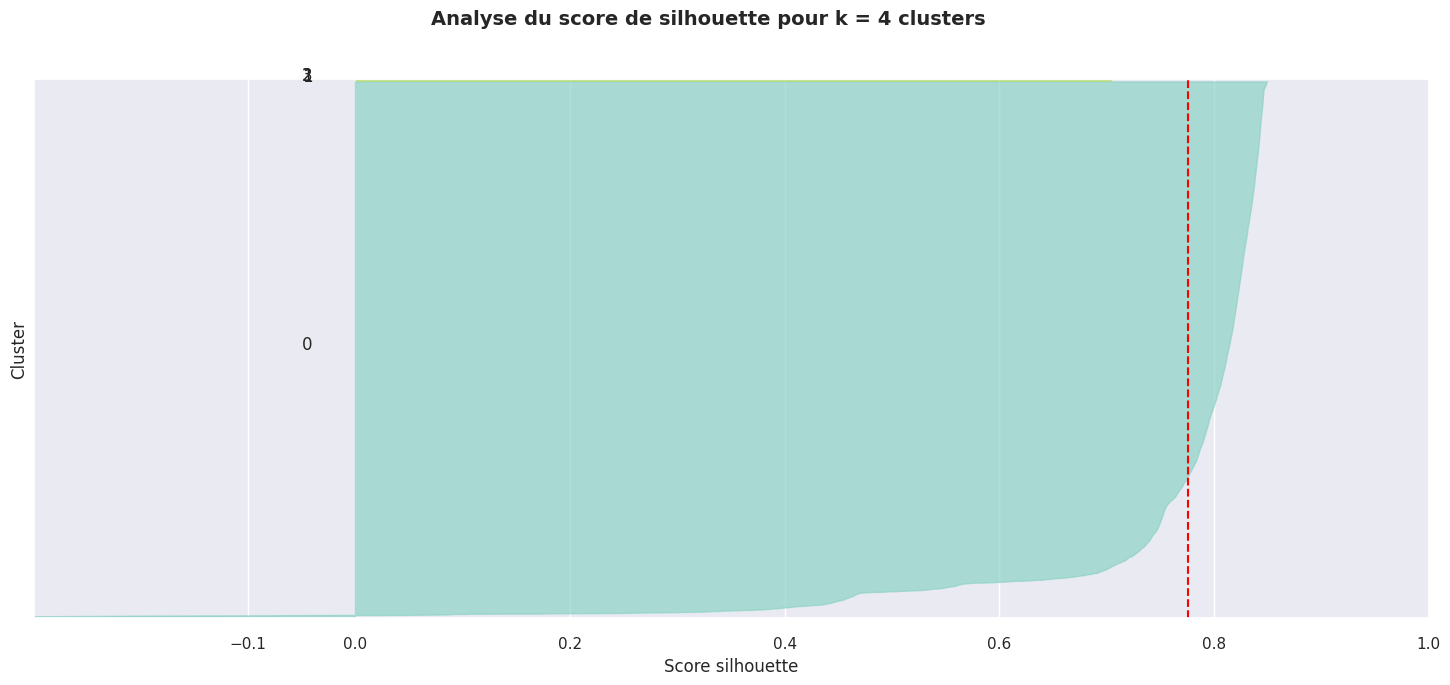

For n_clusters = 5 The average silhouette_score is : 0.35084072055078147


<Figure size 800x550 with 0 Axes>

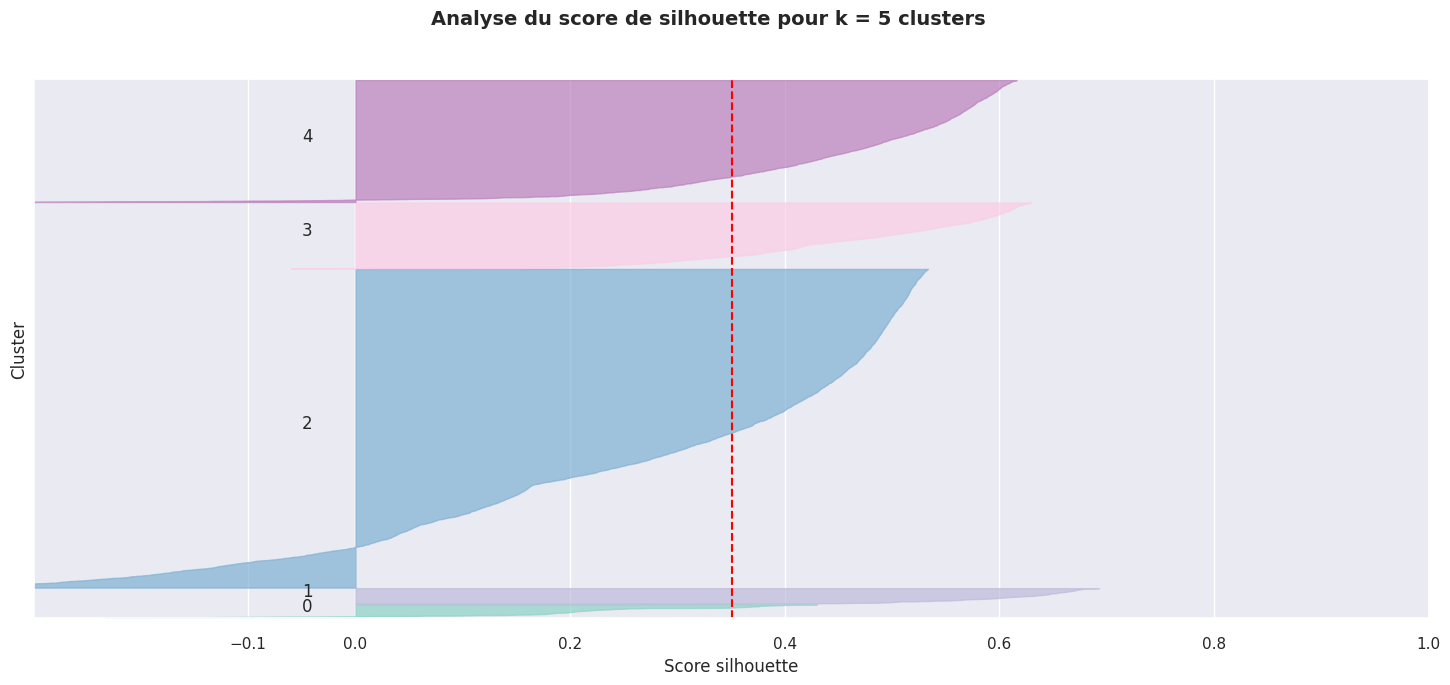

For n_clusters = 5 The average silhouette_score is : 0.5889045001256097


<Figure size 800x550 with 0 Axes>

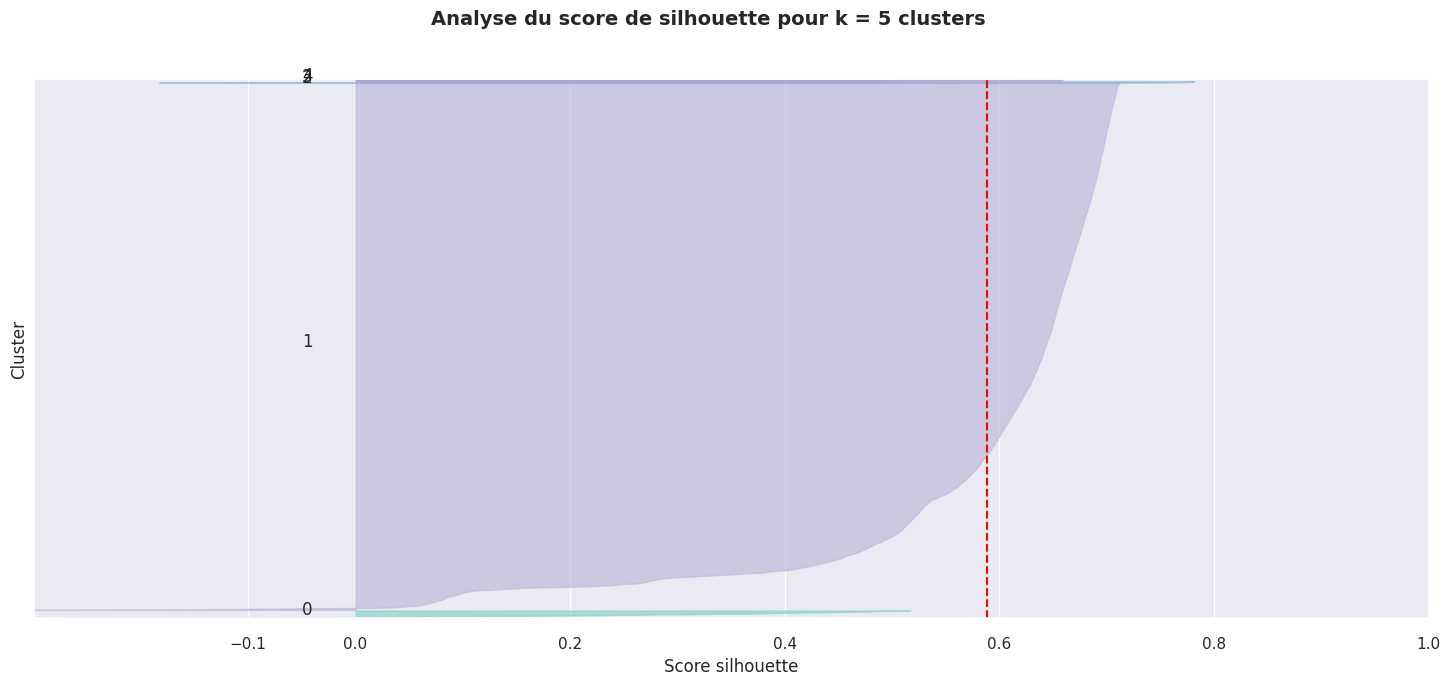

For n_clusters = 5 The average silhouette_score is : 0.7563025260633592


<Figure size 800x550 with 0 Axes>

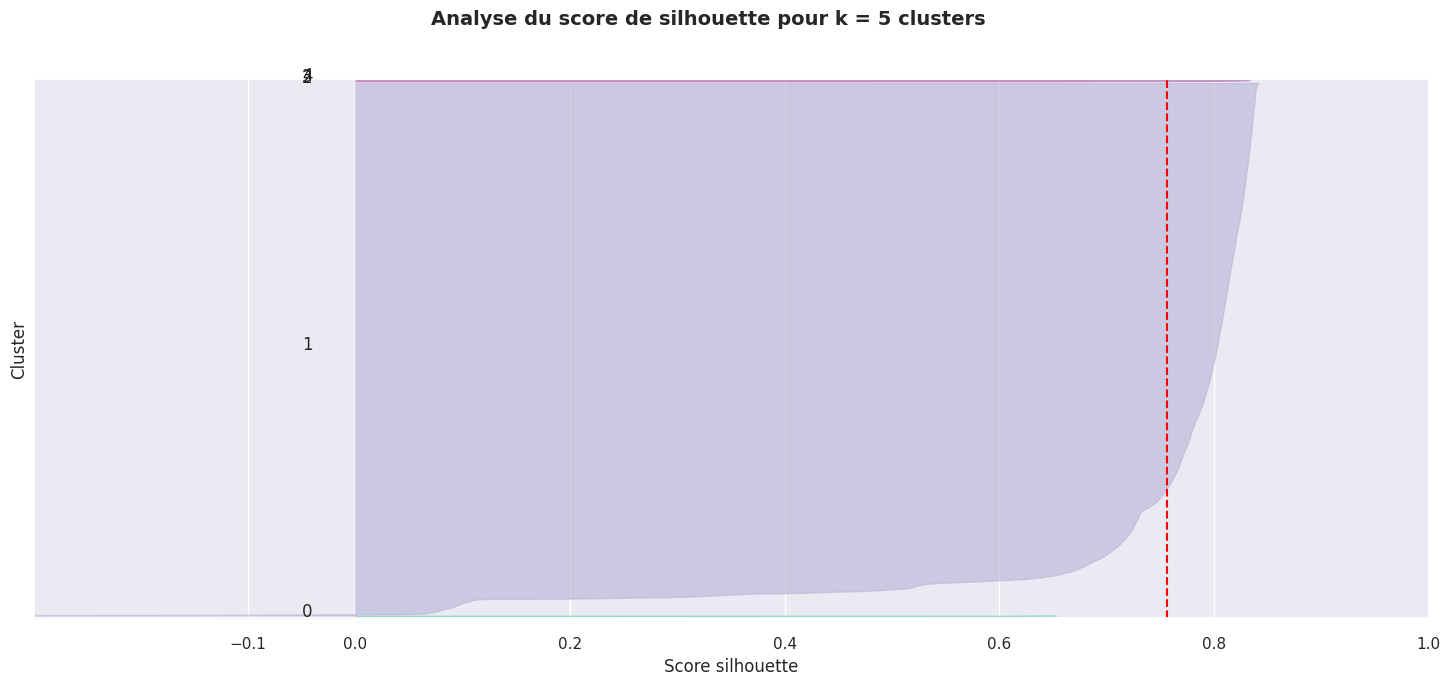

For n_clusters = 5 The average silhouette_score is : 0.7757067148619226


<Figure size 800x550 with 0 Axes>

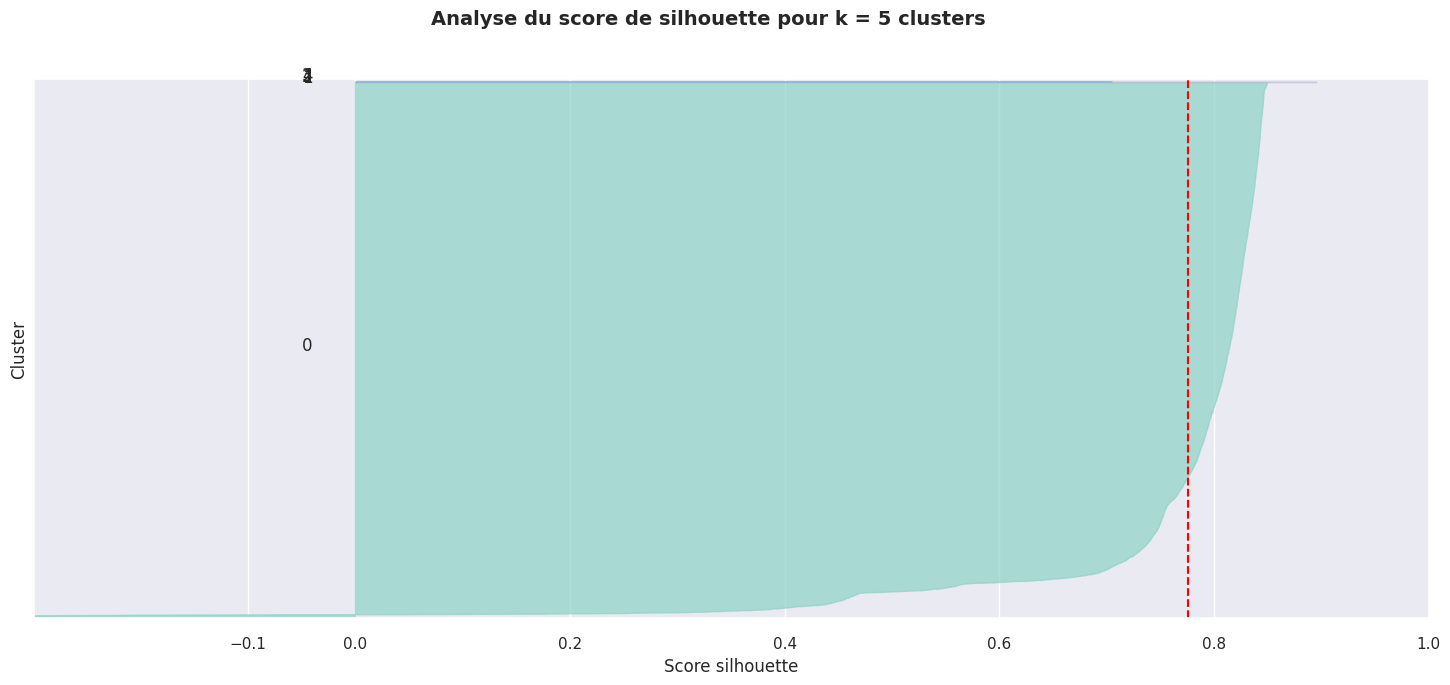

For n_clusters = 6 The average silhouette_score is : 0.3579207900190704


<Figure size 800x550 with 0 Axes>

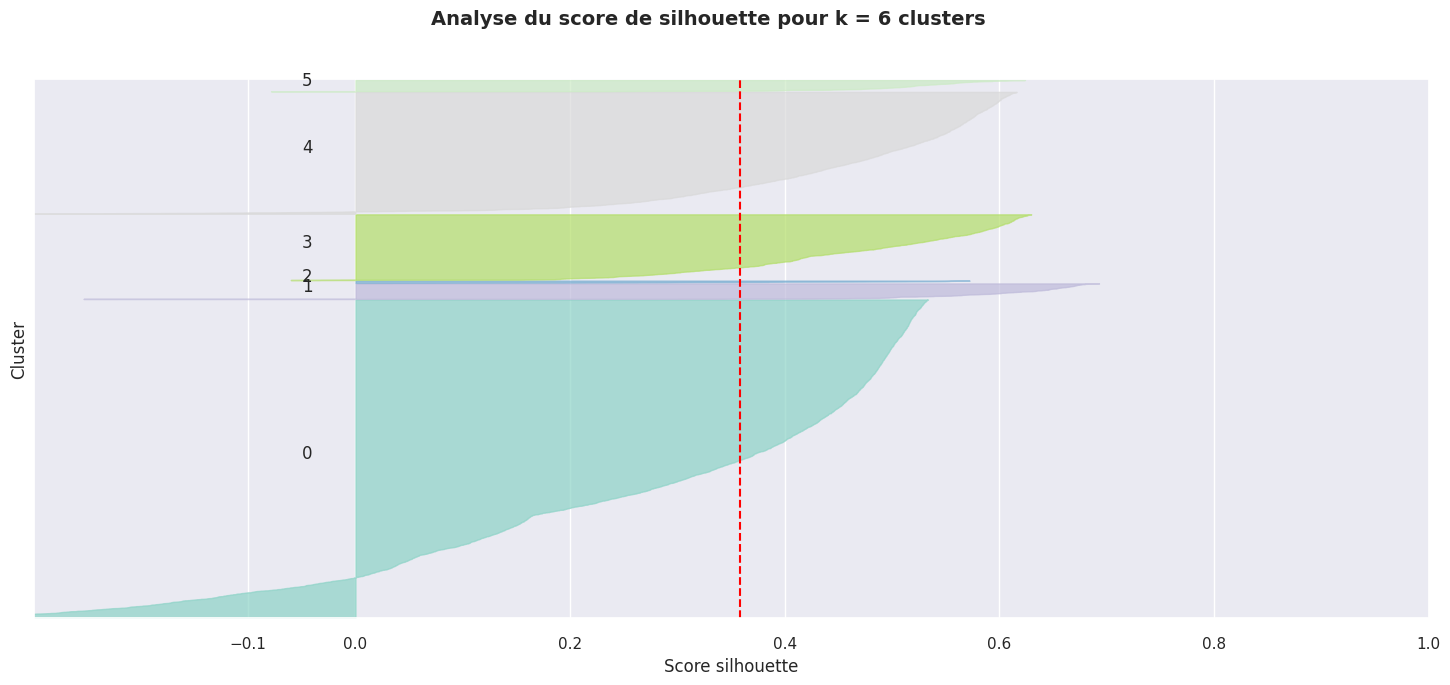

For n_clusters = 6 The average silhouette_score is : 0.5802357043187062


<Figure size 800x550 with 0 Axes>

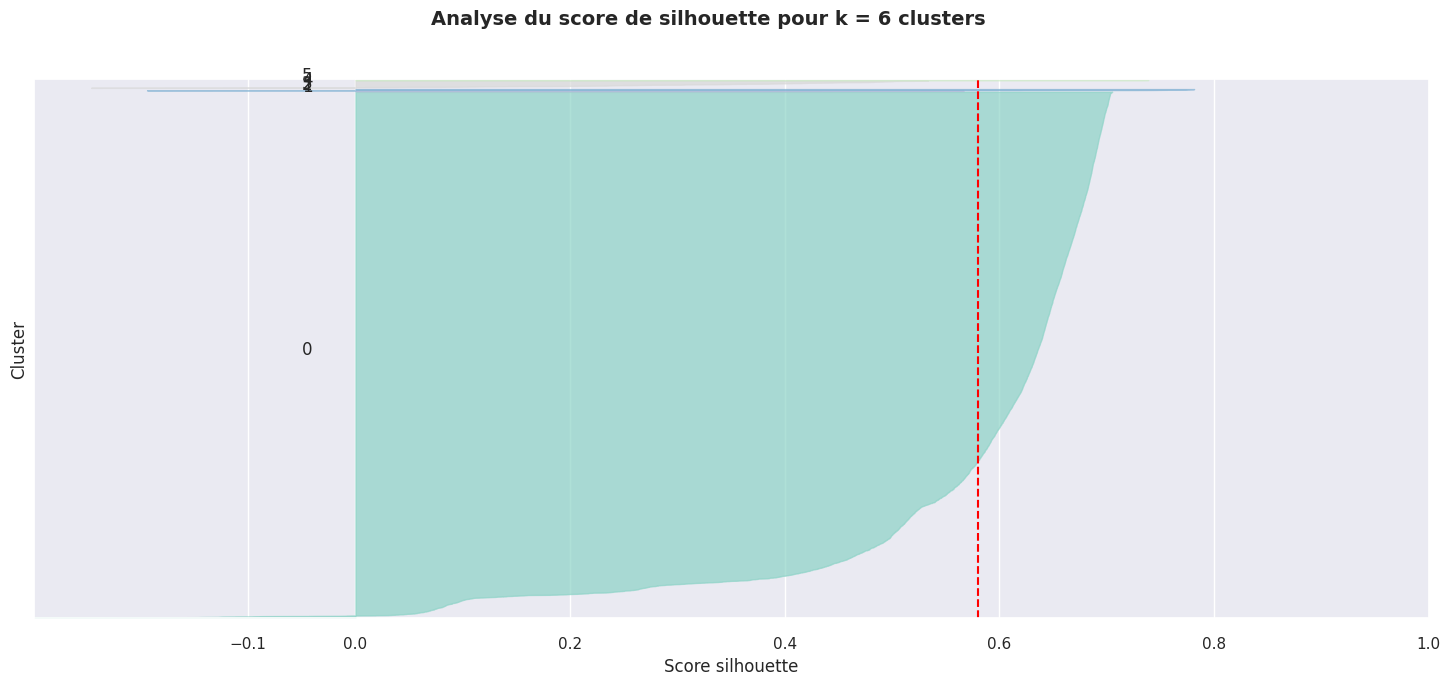

For n_clusters = 6 The average silhouette_score is : 0.7509411531077308


<Figure size 800x550 with 0 Axes>

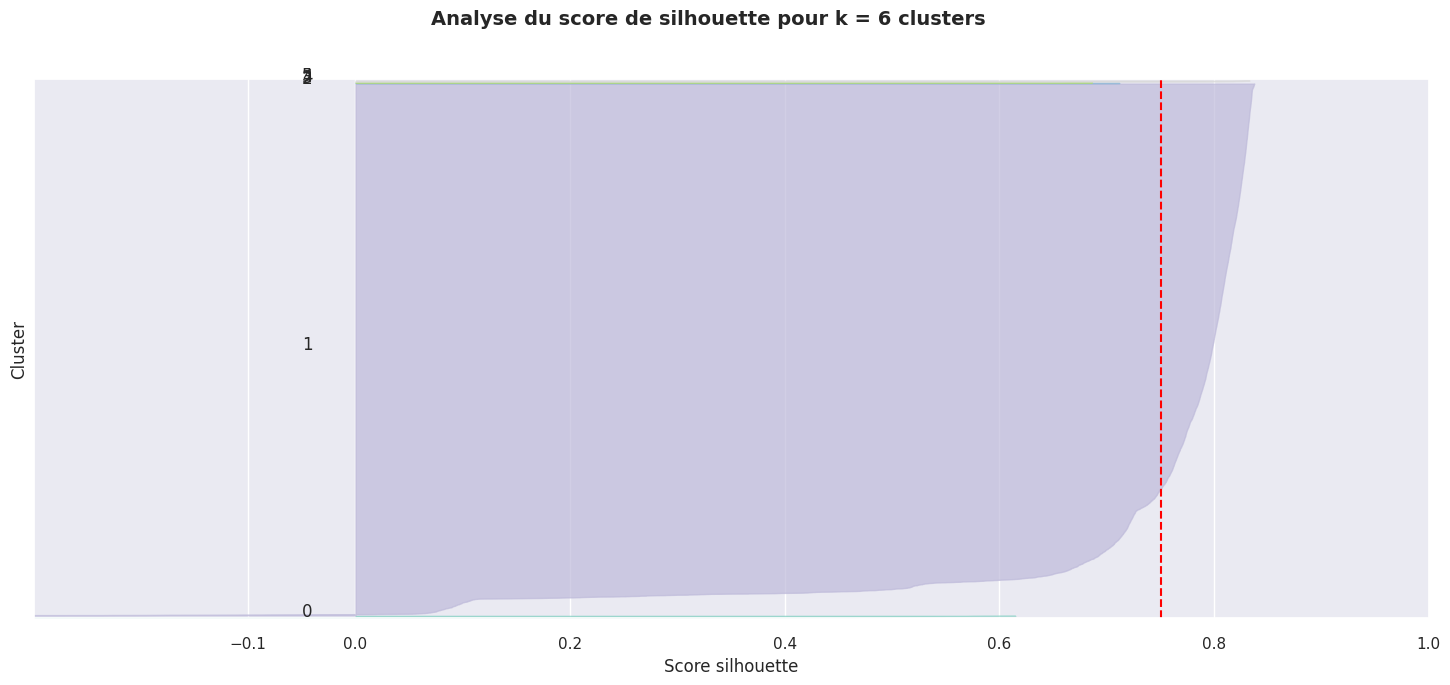

For n_clusters = 6 The average silhouette_score is : 0.7556127105329199


<Figure size 800x550 with 0 Axes>

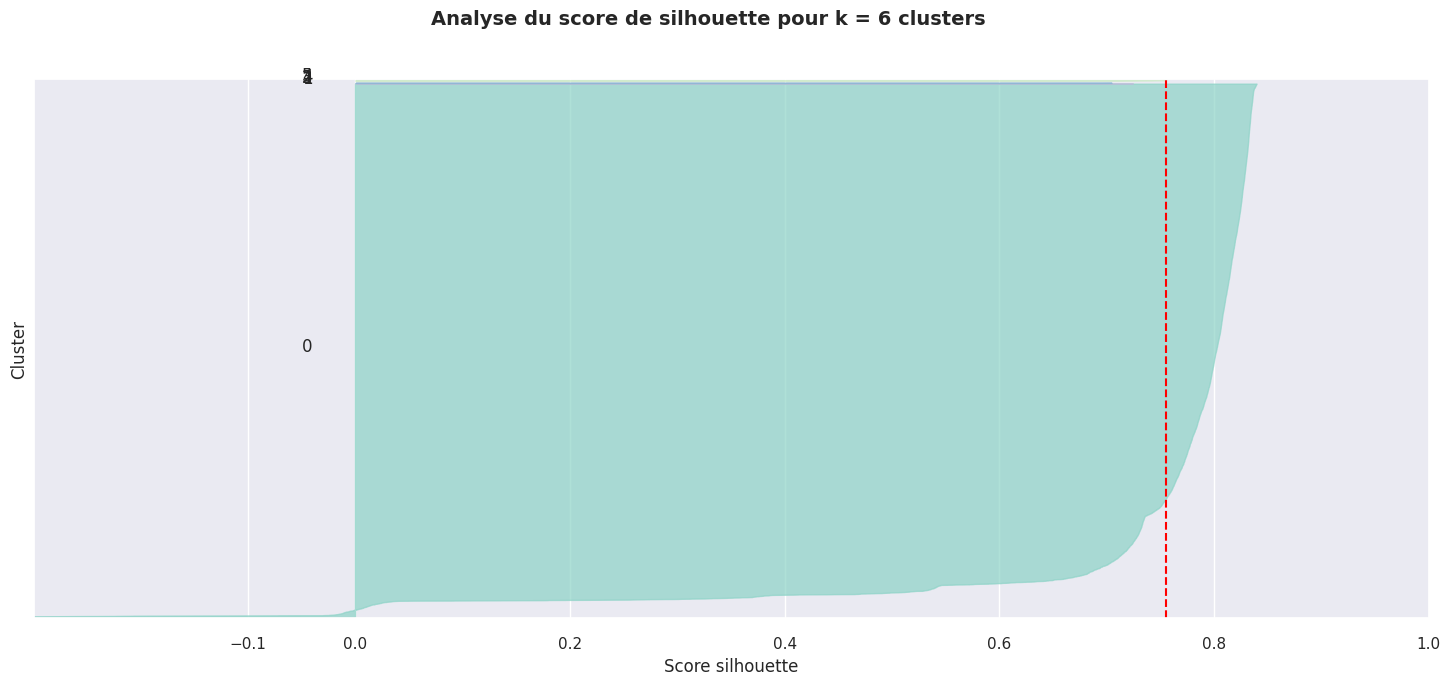

<Figure size 800x550 with 0 Axes>

In [68]:
score_grid = pd.DataFrame(columns = ['param', 'score'])
columns = ['k='+str(i) for i in ls_nb_clusters] #défnition nom de colonnes de score_sil
score_sil = pd.DataFrame(columns = columns) #Dataframe comprenant pour chaque observation les scores silhouette 
cluster_df = pd.DataFrame(columns = columns)
for comb in param:
  score_grid.loc[len(score_grid), 'param'] = comb 
  CAH_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('CAH', sklearn.cluster.AgglomerativeClustering(
                                             n_clusters=comb[0],
                                             linkage = comb[1],
                                             ))])
  CAH_pipe.fit(df)
  clusters = CAH_pipe.named_steps.CAH.labels_
  sil = metrics.silhouette_score(X_scaled, clusters, metric = 'euclidean')      
  score_grid.loc[score_grid['param'] == comb, 'score'] = sil
    ### Plot de silhouette 
  plot_.plot_silhouette(X_scaled,clusters,comb[0],'/content/Fichier_N2/P5_N2_31_set_+'+str(set_)+'.png')


In [69]:
score_grid

param     score
0       (3, ward)  0.657054
1   (3, complete)    0.7665
2    (3, average)  0.894201
3     (3, single)  0.894201
4       (4, ward)  0.433465
5   (4, complete)  0.766298
6    (4, average)   0.77242
7     (4, single)  0.776265
8       (5, ward)  0.350841
9   (5, complete)  0.588905
10   (5, average)  0.756303
11    (5, single)  0.775707
12      (6, ward)  0.357921
13  (6, complete)  0.580236
14   (6, average)  0.750941
15    (6, single)  0.755613

set_ == 1 

Le meilleur set de paramètre est :


*  k = 4
*  distance = 'ward'



---

set_ == 2

Le meilleur set de paramètre est :


*  k = 4
*  distance = 'ward'

---

set_ == 3

Le meilleur set de paramètre est :


*  k = 4
*  distance = 'ward'

## <a name="C32"> 3.2 Résultats </a>

In [70]:
#df = df.drop(columns = ['clusters'])

In [71]:
if set_==1:
  best_param = score_grid.loc[4,'param']
elif set_==2:
  #best_param = score_grid.loc[4,'param']
  best_param = (4, 'ward')
elif set_==3:
  best_param = score_grid.loc[4,'param']
  best_param = (4, 'ward')

In [72]:
best_param

(4, 'ward')

In [73]:
score_sil = pd.DataFrame(columns = ['k='+str(best_param[0])])
cluster_df = pd.DataFrame(columns = ['k='+str(best_param[0])])
sil = 0
CAH_pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('CAH', sklearn.cluster.AgglomerativeClustering(n_clusters=best_param[0],
                                             linkage = best_param[1]
                                     ))])
start_time = time.time()
CAH_pipe.fit(df)
end_time = time.time()
fit_time = end_time-start_time
clusters = CAH_pipe.named_steps.CAH.labels_
sil+= metrics.silhouette_score(X_scaled, clusters, metric = 'euclidean')
df['clusters'] = clusters
score_model.loc['CAH', 'Silhouette'] = sil
score_model.loc['CAH','Temps_calcul'] = fit_time
cluster_df['k='+str(best_param[0])] = clusters
score_sil['k='+str(best_param[0])] = metrics.silhouette_samples(X_scaled, clusters)

For n_clusters = 4 The average silhouette_score is : 0.43346474298928606


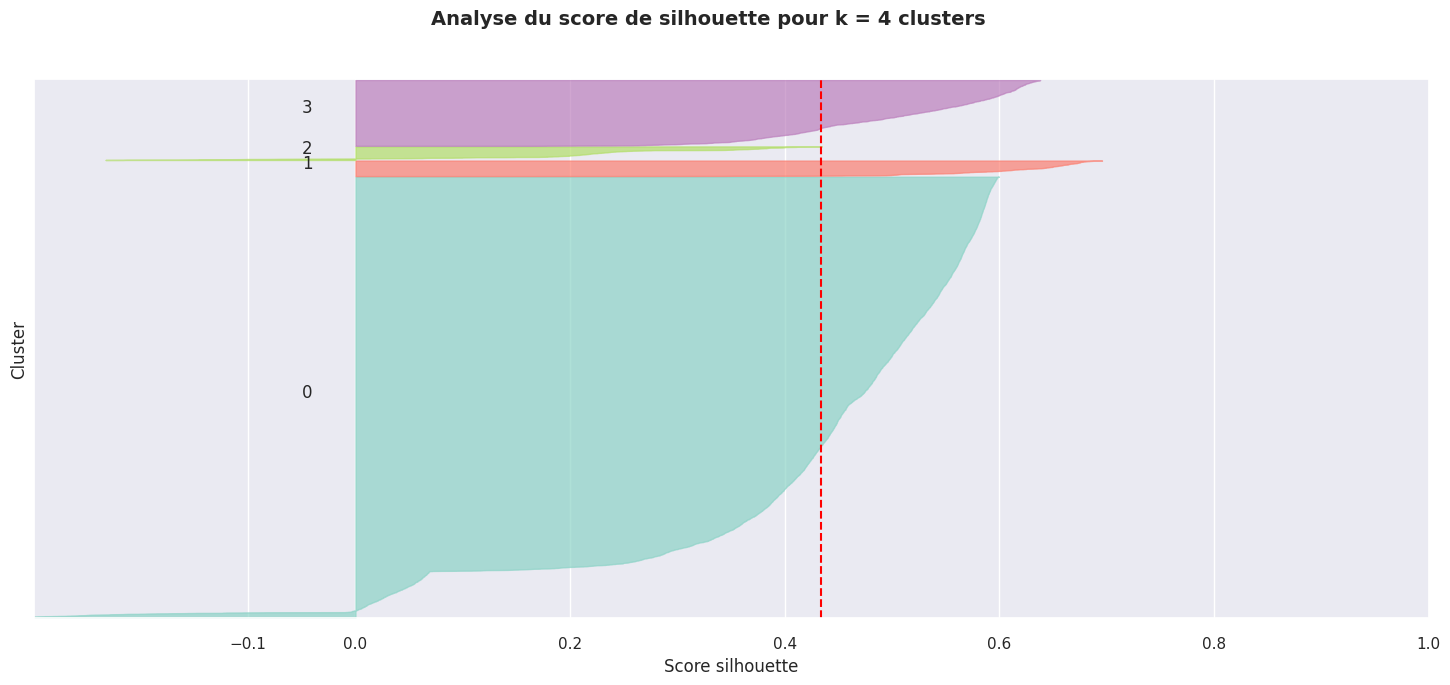

<Figure size 800x550 with 0 Axes>

In [74]:
k = best_param[0]
plot_.plot_silhouette(X_scaled,clusters,k,'/content/Fichier_N2/P5_N2_32_0_set_'+str(set_)+'.png')

In [75]:
df['clusters'].value_counts()

0    7851
3    1172
1     277
2     242
Name: clusters, dtype: int64

In [76]:
df[df['clusters']==3].describe()

fréquence    récence_j  montant_moy  critique_note    categorie  \
count     1172.0  1172.000000  1172.000000    1172.000000  1172.000000   
mean         1.0   341.113481   177.074855       1.113481   197.903695   
std          0.0   171.881798   178.178410       0.460115    22.869288   
min          1.0    23.000000    18.920000       0.000000   131.030000   
25%          1.0   223.000000    67.500000       1.000000   181.280000   
50%          1.0   320.500000   119.100000       1.000000   199.650000   
75%          1.0   436.250000   202.595000       1.000000   205.130000   
max          1.0  1026.000000  1218.540000       2.000000   289.460000   

       clusters  
count    1172.0  
mean        3.0  
std         0.0  
min         3.0  
25%         3.0  
50%         3.0  
75%         3.0  
max         3.0

- ### Représentation univariée

In [77]:
df.columns

Index(['fréquence', 'récence_j', 'montant_moy', 'critique_note', 'categorie',
       'clusters'],
      dtype='object')

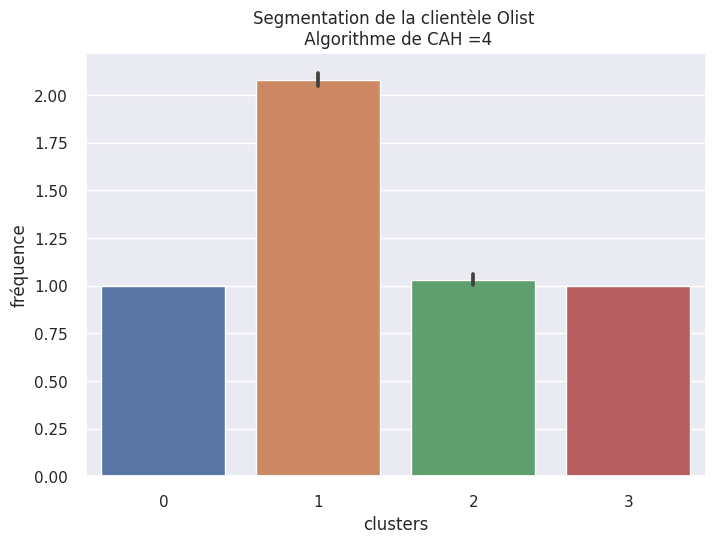

In [78]:
sns.set()
sns.barplot(data = df, x = 'clusters', y= 'fréquence')
plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH ='+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_32a_set'+str(set_)+'.png', bbox_inches = 'tight')


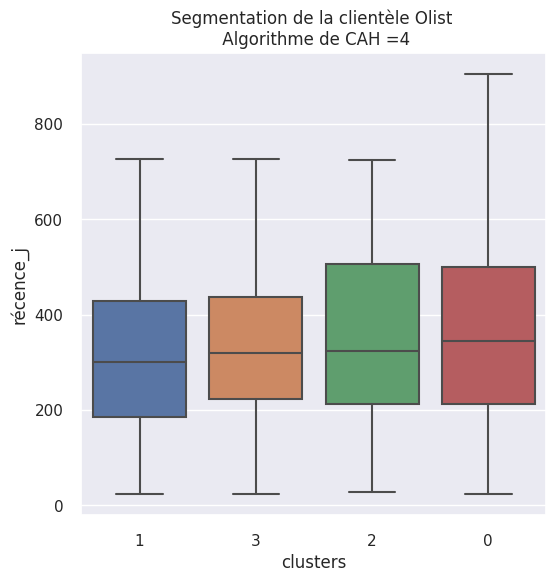

In [79]:
order_ = df.groupby('clusters')['récence_j'].median().sort_values().index
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(data = df, x = 'clusters', y= 'récence_j', showfliers = False, order = order_)
plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH ='+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_32b_set'+str(set_)+'.png', bbox_inches = 'tight')


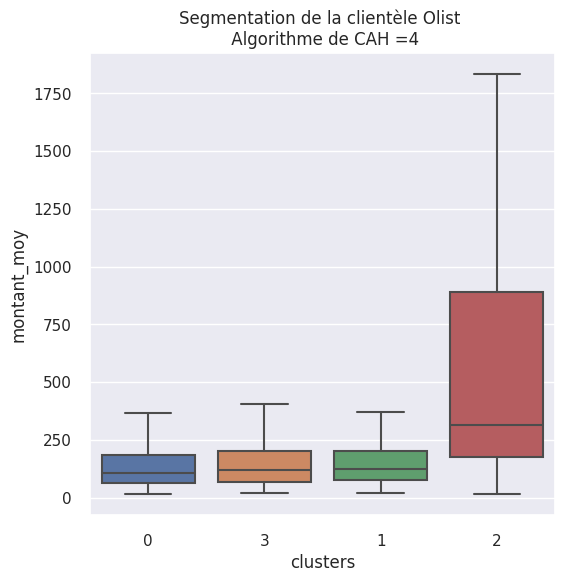

In [80]:
order_ = df.groupby('clusters')['montant_moy'].median().sort_values().index
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(data = df, x = 'clusters', y= 'montant_moy', showfliers = False, order = order_)
plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH ='+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_32c_set'+str(set_)+'.png', bbox_inches = 'tight')


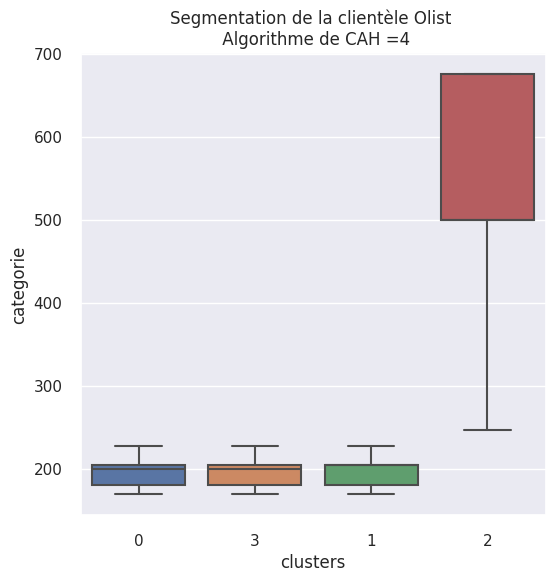

In [81]:
if set_ == 3:
  order_ = df.groupby('clusters')['categorie'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'categorie', showfliers = False, order = order_)
  plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_32d_set'+str(set_)+'.png', bbox_inches = 'tight')


In [82]:
if set_ ==2:
  order_ = df.groupby('clusters')['etat_client'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'etat_client', showfliers = False, order = order_)
  ax.set_ylabel('Revenus moyen mensuel par personne')
  plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_32d_set'+str(set_)+'.png', bbox_inches = 'tight')


In [83]:
if set_ == 2: 
  order_ = df.groupby('clusters')['reste_echeance_mois'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'reste_echeance_mois', showfliers = False,order = order_)
  ax.set_ylabel('Nombre d\'échéances de paiement restant') 
  plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_32e_set'+str(set_)+'.png', bbox_inches = 'tight')


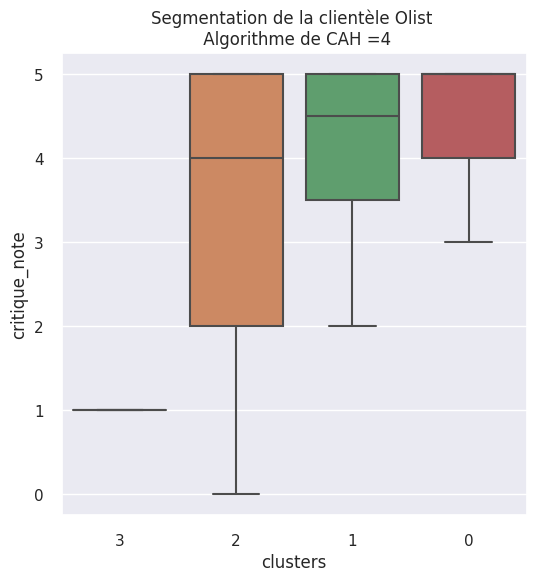

In [84]:
if set_ == 3:
  order_ = df.groupby('clusters')['critique_note'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'critique_note', showfliers = False, order = order_)
  plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_32e_set'+str(set_)+'.png', bbox_inches = 'tight')


In [85]:
df[df['clusters']== 0].describe()

fréquence    récence_j  montant_moy  critique_note    categorie  \
count     7851.0  7851.000000  7851.000000    7851.000000  7851.000000   
mean         1.0   359.334225   175.379684       4.544517   198.097363   
std          0.0   180.510170   234.547702       0.734170    24.947743   
min          1.0    23.000000    13.780000       0.000000   131.030000   
25%          1.0   212.000000    61.575000       4.000000   181.280000   
50%          1.0   344.000000   105.800000       5.000000   199.650000   
75%          1.0   499.000000   183.345000       5.000000   205.130000   
max          1.0   995.000000  2429.680000       5.000000   289.460000   

       clusters  
count    7851.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0

---
set_ ==1 

La répartition des clusters semble convenable : 
Les 282 individus du clusters 1, sont les individus qui passent commande fréquemment. La distinction est cohérente. Les 282/9500 représente bien 3% du dataset. 
```

```



---
set_ ==2 

```

```








- ### Représentation dans l'espace des composantes principales

In [86]:
df_cent = df.groupby('clusters')[num_features].mean()
centroids= df_cent.values

In [87]:
centroid_proj = pca.transform(centroids)
centroid_proj
if set_ ==1 :
  centroid_df = pd.DataFrame(data = centroid_proj, columns = ['F1', 'F2', 'F3'])
else:
  centroid_df = pd.DataFrame(data = centroid_proj, columns = ['F1', 'F2', 'F3','F4'])


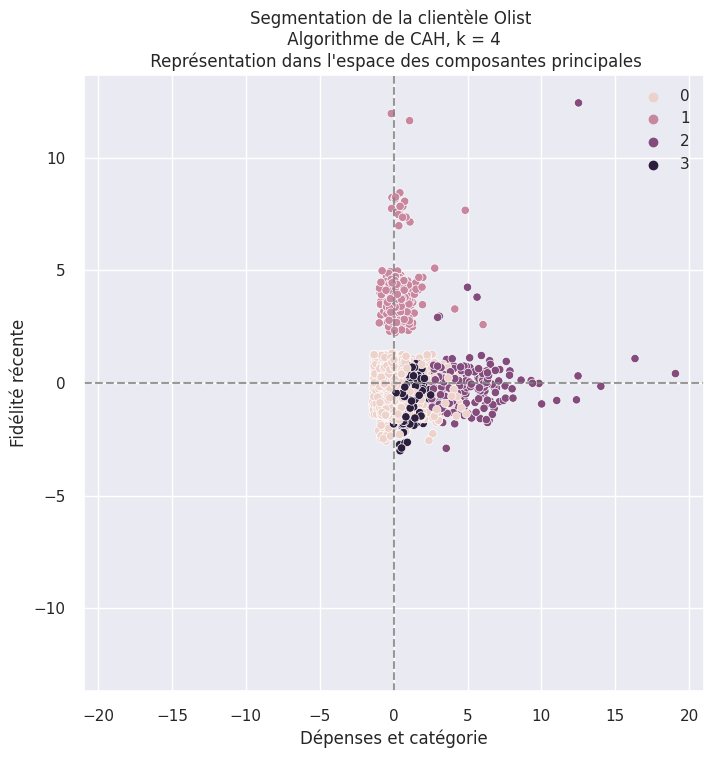

In [88]:
if set_ == 1:
  F1 = 'Fidélité récente' 
  F2 = 'Dépenses anciennes'
  F3 = 'Ancienneté clientèle'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3], index = ind)
elif set_== 2 :
  F1 = 'Trésorerie'
  F2 = '(-) Pouvoir d\'achat'
  F3 = 'Fréquence'
  F4 = 'Dépenses'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
elif set_==3:
  F1 = 'Dépenses et catégorie'
  F2 = 'Fidélité récente'
  F3 = 'Fidélité ancienne'
  F4 = 'Note'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
data_proj['clusters'] = df['clusters']
data_proj

fig, ax = plt.subplots(figsize=(8,8))
sns.set()
sns.scatterplot(data = data_proj,x = F1, y =  F2, hue = 'clusters')
sns.scatterplot(data = centroid_df, x = 'F1', y = 'F2', markers = '^')
# Valeur x max et y max
x_max = np.abs(data_proj[F1]).max() *1.1
y_max = np.abs(data_proj[F2]).max() *1.1

# On borne x et y 
ax.set_xlim(left=-x_max, right=x_max)
ax.set_ylim(bottom= -y_max, top=y_max)

# Affichage des lignes horizontales et verticales
plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')

plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH, k = '+str(k)+' \n Représentation dans l\'espace des composantes principales')

plt.savefig('/content/Fichier_N2/P5_N2_32_ACP1_set'+str(set_)+'.png', bbox_inches = 'tight')

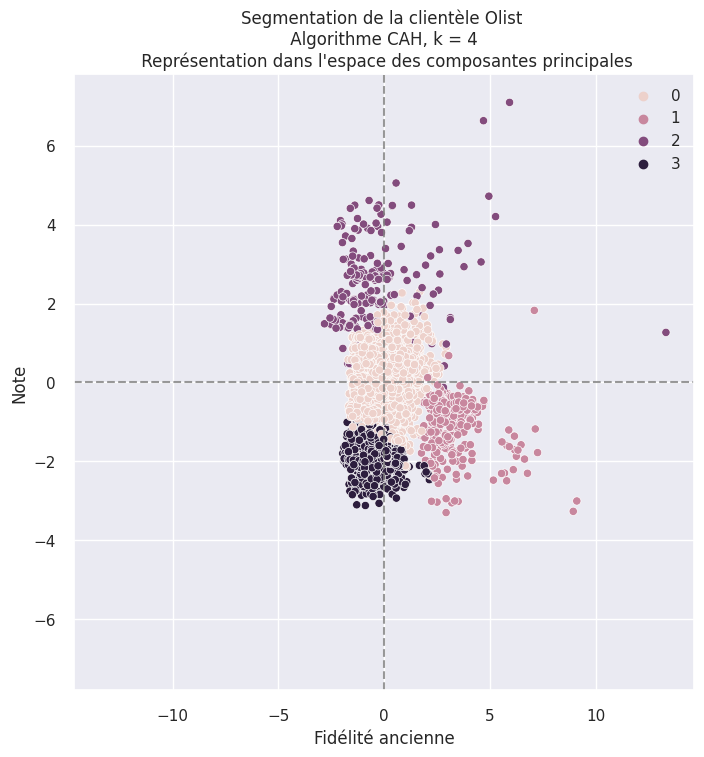

In [89]:
if set_ == 1:
  F1 = 'Fidélité récente' 
  F2 = 'Dépenses anciennes'
  F3 = 'Ancienneté clientèle'
  data_proj = pd.DataFrame(data = X_proj,  columns = [F1, F2, F3], index = ind)
  data_proj['clusters'] = df['clusters']
  fig, ax = plt.subplots(figsize=(8,8))
  sns.set()
  sns.scatterplot(data = data_proj,  x = F2, y = F3, hue = 'clusters')
  sns.scatterplot(data = centroid_df, x = 'F2', y = 'F3', markers = '^')
  # Valeur x max et y max
  x_max = np.abs(data_proj[F2]).max() *1.1
  y_max = np.abs(data_proj[F3]).max() *1.1

  # On borne x et y 
  ax.set_xlim(left=-x_max, right=x_max)
  ax.set_ylim(bottom= -y_max, top=y_max)

  # Affichage des lignes horizontales et verticales
  plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
  plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')
else:
  if set_ == 2:
    F1 = 'Trésorerie'
    F2 = '(-) Pouvoir d\'achat'
    F3 = 'Fréquence'
    F4 = 'Dépenses'
  elif set_==3:
    F1 = 'Dépenses et catégorie'
    F2 = 'Fidélité récente'
    F3 = 'Fidélité ancienne'
    F4 = 'Note'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
  data_proj['clusters'] = df['clusters']
  data_proj
  fig, ax = plt.subplots(figsize=(8,8))
  sns.set()
  data_proj['clusters'] = df['clusters']
  sns.scatterplot(data = data_proj, x = F3, y = F4, hue = 'clusters')
  sns.scatterplot(data = centroid_df, x = 'F3', y = 'F4', markers = '^')
  # Valeur x max et y max
  x_max = np.abs(data_proj[F3]).max() *1.1
  y_max = np.abs(data_proj[F4]).max() *1.1

  # On borne x et y 
  ax.set_xlim(left=-x_max, right=x_max)
  ax.set_ylim(bottom= -y_max, top=y_max)

  # Affichage des lignes horizontales et verticales
  plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
  plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')

plt.title('Segmentation de la clientèle Olist \n Algorithme CAH, k = '+str(k)+' \n Représentation dans l\'espace des composantes principales')
plt.savefig('/content/Fichier_N2/P5_N2_32_ACP2_set'+str(set_)+'.png', bbox_inches = 'tight')

- ### Représentation bivariées + 3D

In [90]:
df

fréquence  récence_j  montant_moy  critique_note  categorie  clusters
5054           1        160        80.31            5.0     205.13         0
37580          1        476       113.45            5.0     199.65         0
51563          1        565       105.89            1.0     227.55         3
81880          1        259       216.38            5.0     205.13         0
56353          1        557        71.14            2.0     181.28         0
...          ...        ...          ...            ...        ...       ...
34112          1        491        47.59            4.0     205.13         0
40015          1         54        30.13            3.0     183.83         0
67763          1        332        34.75            4.0     169.58         0
18137          1        723       135.92            5.0     198.68         0
42206          1         56       220.03            4.0     199.65         0

[9542 rows x 6 columns]

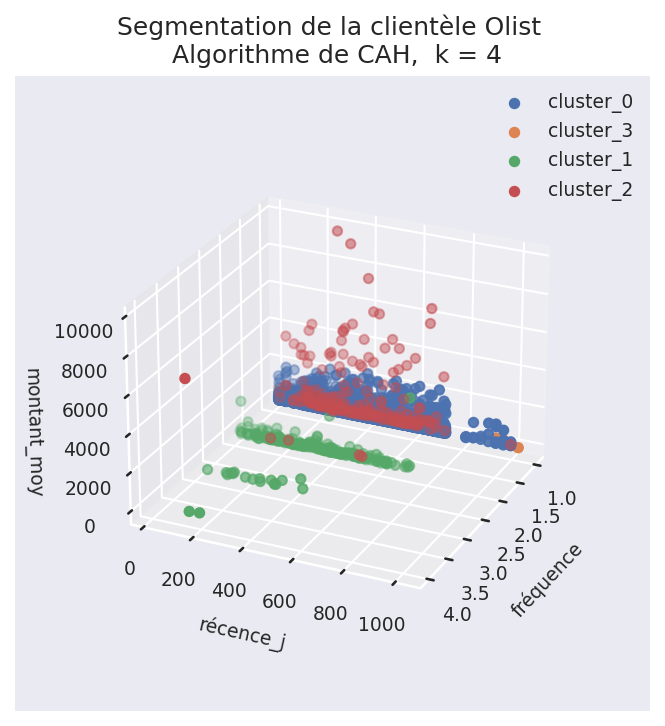

In [91]:
fig = plt.figure(dpi =150)
ax = fig.add_subplot(projection='3d')
ls_clust = df['clusters'].unique().tolist()
for clust in ls_clust:
    df_tamp = df[df['clusters']== clust]
    xs = df_tamp[num_features[0]]
    ys = df_tamp[num_features[1]]
    zs = df_tamp[num_features[2]]
    ax.scatter(xs, ys, zs, marker='o', label = 'cluster_'+str(clust))
ax.legend(fontsize = 9)
ax.set_xlabel(str(num_features[0]), labelpad = 14, fontsize = 9)
ax.set_ylabel(str(num_features[1]),labelpad = 14, fontsize = 9)
ax.set_zlabel(str(num_features[2]),labelpad = 14, fontsize = 9)
ax.tick_params(labelsize=9)
ax.view_init(elev=25., azim=25, roll=0)
ax.dist = 13
plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH,  k = '+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_32_3D_a_set'+str(set_)+'.png', bbox_inches = 'tight')

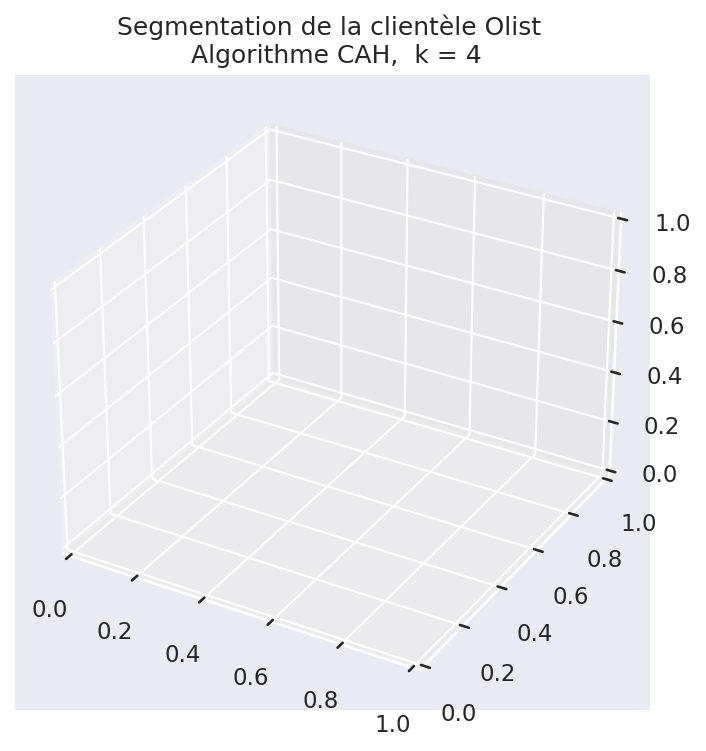

In [92]:
if set_!=1:
  fig = plt.figure(dpi =150)
  x = fig.add_subplot(projection='3d')
  ls_clust = df['clusters'].unique().tolist()
  for clust in ls_clust:
    df_tamp = df[df['clusters']== clust]
    xs = df_tamp['fréquence']
    ys = df_tamp[num_features[-1]]
    zs = df_tamp[num_features[-2]]
    ax.scatter(xs, ys, zs, marker='o', label = 'cluster_'+str(clust))
  ax.legend(fontsize = 9)
  ax.set_xlabel('Fréquence', labelpad = 14, fontsize = 9)
  ax.set_ylabel(str(num_features[-1]),labelpad = 14, fontsize = 9)
  ax.set_zlabel(str(num_features[-2]),labelpad = 14, fontsize = 9)
  ax.tick_params(labelsize=9)
  ax.view_init(elev=25., azim=20, roll=0)
  ax.dist = 13
  plt.title('Segmentation de la clientèle Olist \n Algorithme CAH,  k = '+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_32_3D_b_set'+str(set_)+'.png', bbox_inches = 'tight')

- ### Tableau comparatif

In [93]:
score_model

Silhouette Temps_calcul
K_means   0.405964      0.32703
CAH       0.433465     4.709551
DBSCAN         NaN          NaN
MIXTE          NaN          NaN

# <a name="C4"> 4. Essais 3 : DBSCAN</a>

## <a name="C41"> 4.1 Grille de recherche, des hyperparamètres optimaux </a>

In [94]:
df = df.drop(columns = ['clusters'])

In [95]:
df.head()

fréquence  récence_j  montant_moy  critique_note  categorie
5054           1        160        80.31            5.0     205.13
37580          1        476       113.45            5.0     199.65
51563          1        565       105.89            1.0     227.55
81880          1        259       216.38            5.0     205.13
56353          1        557        71.14            2.0     181.28

In [96]:
##Grille de paramamètre -- Définition par le produit caratésien des paramètres que l'on veut tester
import itertools
#ls_eps = np.arange(0.5,2.,0.2)
param_grid = {'eps' : [3], #ls_eps.tolist(),2.5 #4, 5
              'min_samples': [70], # autre valeurs testées : 50, 150,100,500,800, 1000, 1200,
              'p' :[2], #1 testé
              'leaf_size': [10, 20, 30],
              'algorithm' : ['auto']} #'ball_tree', 'kd_tree', 'brute']} 

param = [] 
for i in itertools.product(param_grid['eps'],param_grid['min_samples'], param_grid['p'], param_grid['leaf_size'], param_grid['algorithm']):
    param.append(i)

(3, 70, 2, 10, 'auto')
For n_clusters = 4 The average silhouette_score is : 0.6356643744480862


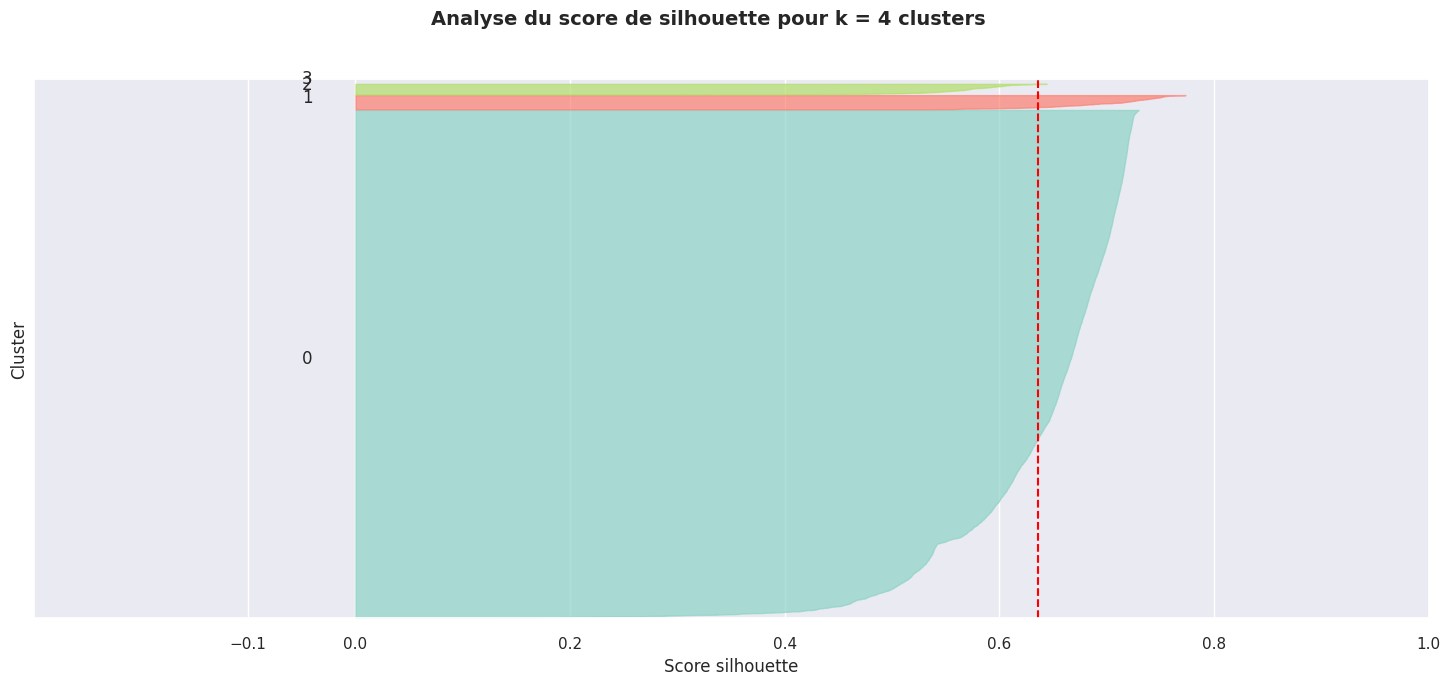

(3, 70, 2, 20, 'auto')
For n_clusters = 4 The average silhouette_score is : 0.6356643744480862


<Figure size 800x550 with 0 Axes>

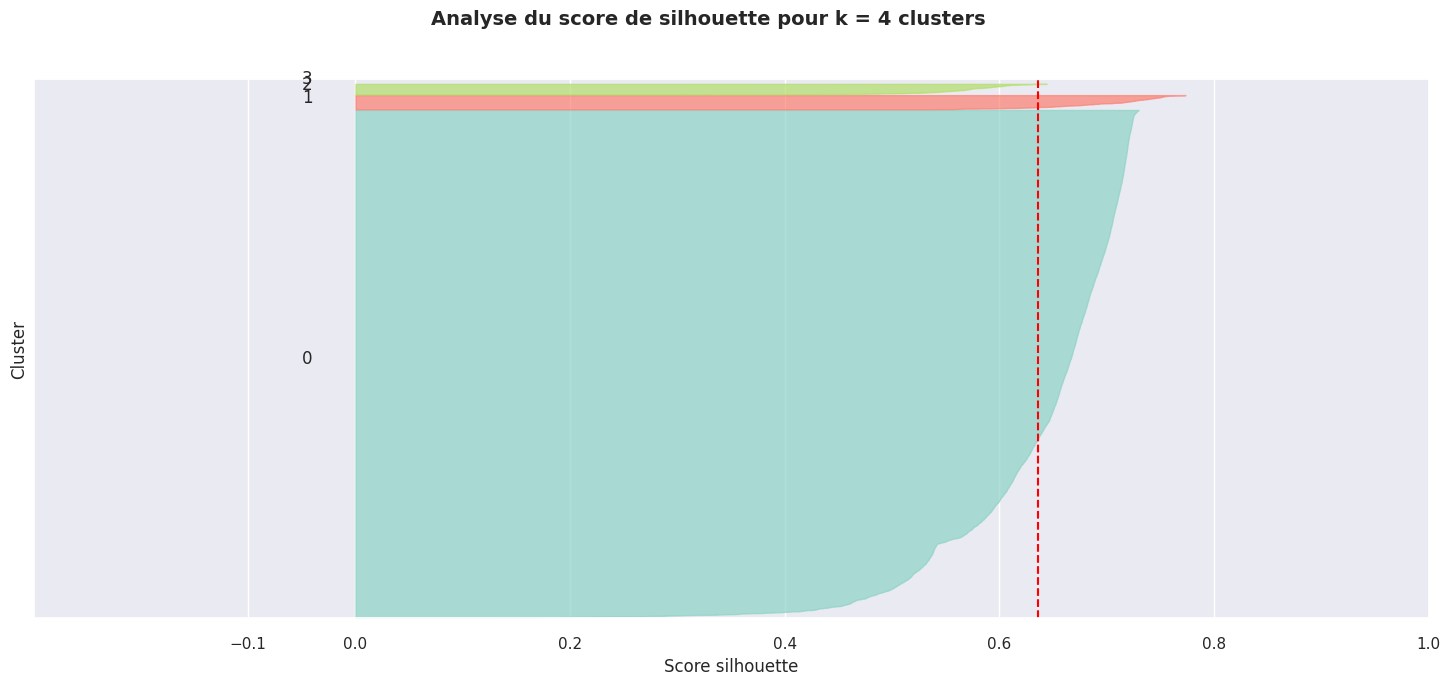

(3, 70, 2, 30, 'auto')
For n_clusters = 4 The average silhouette_score is : 0.6356643744480862


<Figure size 800x550 with 0 Axes>

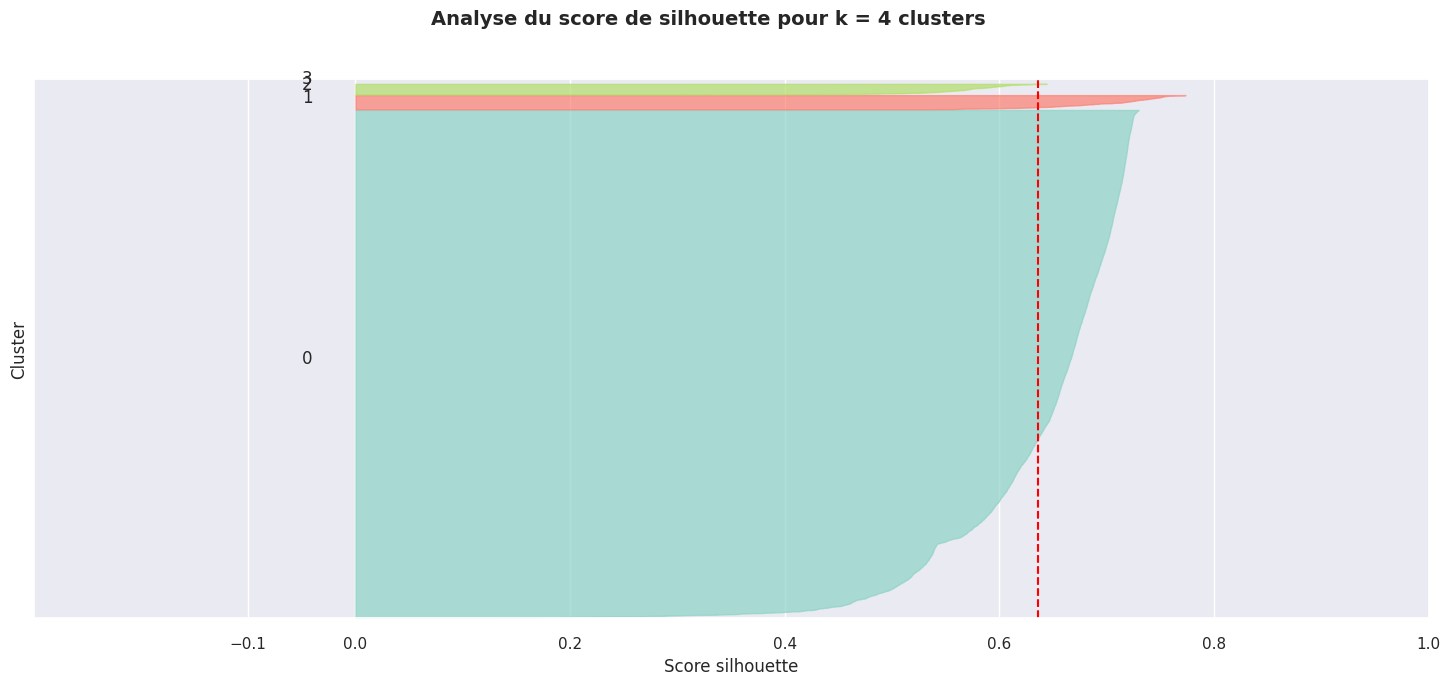

<Figure size 800x550 with 0 Axes>

In [97]:
state = 38
score_grid = pd.DataFrame(columns = ['param', 'score'])
for comb in param:
  print(comb)
  sil = 0
  score_grid.loc[len(score_grid), 'param'] = comb 
  DBSCAN_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('DBSCAN', sklearn.cluster.DBSCAN(eps= comb[0], 
                                          min_samples=comb[1],
                                          p= comb[2], leaf_size = comb[3],
                                          algorithm = comb[4]))])
  DBSCAN_pipe.fit(df)
    #centroids = DBSCAN_pipe.named_steps.DBSCAN.core_sample_indices_
  clusters = DBSCAN_pipe.named_steps.DBSCAN.labels_
  clus_test = pd.Series(clusters)
  if len(clus_test.unique()) != 1:
    sil += metrics.silhouette_score(X_scaled, clusters) 
    k = len(clus_test.unique())
      ### Plot de silhouette 
    plot_.plot_silhouette(X_scaled,clusters,k,'/content/Fichier_N2/P5_N2_TEST.png')
  else : 
    sil = 'erreur : 1 cluster identifié'    
  score_grid.loc[score_grid['param'] == comb, 'score'] = sil



In [98]:
score_grid.loc[:]

param     score
0  (3, 70, 2, 10, auto)  0.635664
1  (3, 70, 2, 20, auto)  0.635664
2  (3, 70, 2, 30, auto)  0.635664

## <a name="C42"> 4.2 Résultats </a>

In [99]:
if set_ == 1:
  best_param = score_grid.loc[0,'param']
elif set_ == 2:
  best_param = score_grid.loc[0,'param']
elif set_ == 3:
  best_param = score_grid.loc[0,'param']

For n_clusters = 4 The average silhouette_score is : 0.6356643744480862


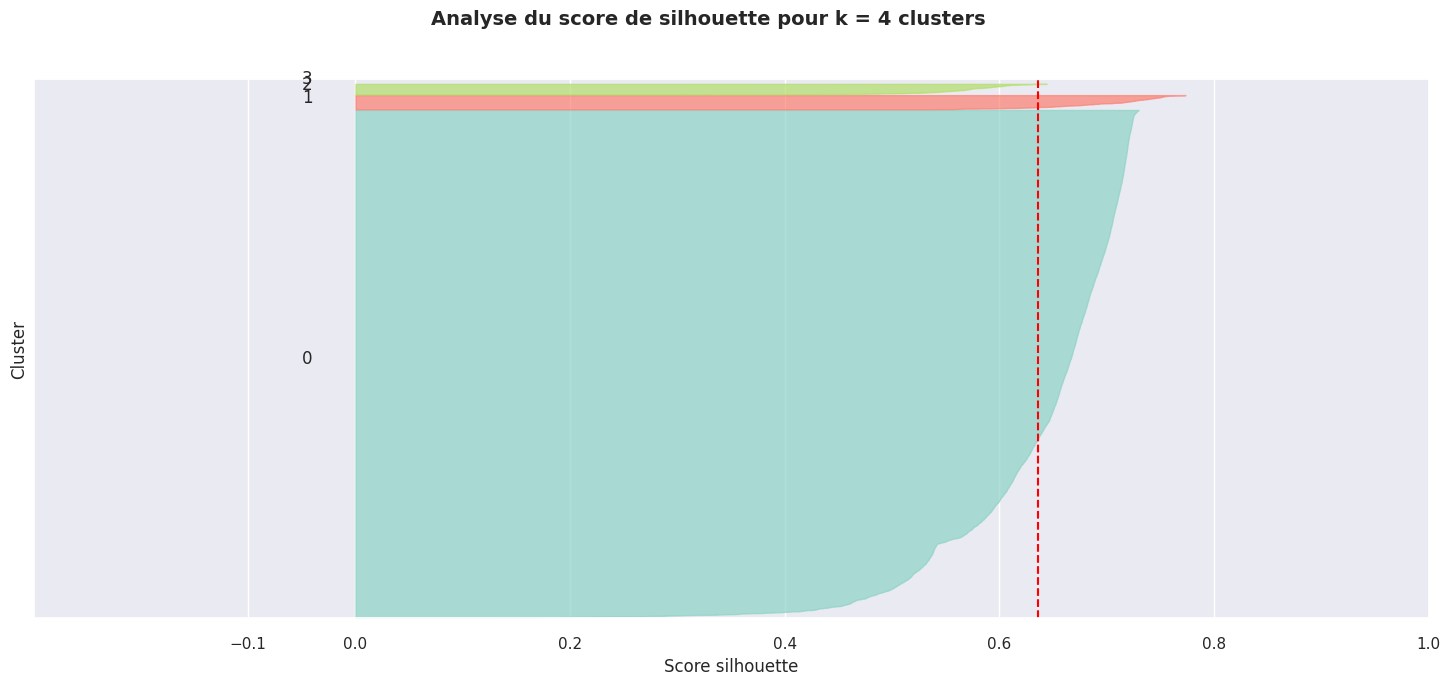

<Figure size 800x550 with 0 Axes>

In [100]:
DBSCAN_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('DBSCAN', sklearn.cluster.DBSCAN(eps= best_param[0], 
                                          min_samples=best_param[1],
                                          p=best_param[2], 
                                          leaf_size = best_param[3],
                                          algorithm = best_param[4]
                                          ))])
start_time = time.time()
DBSCAN_pipe.fit(df)
end_time = time.time()
fit_time = end_time-start_time
clusters = DBSCAN_pipe.named_steps.DBSCAN.labels_
df['clusters'] = clusters
k = len(df['clusters'].unique())
plot_.plot_silhouette(X_scaled,clusters,k,'/content/Fichier_N2/P5_N2_42_0_set'+str(set_)+'.png')

In [101]:
score_model.loc['DBSCAN', 'Silhouette'] = metrics.silhouette_score(X_scaled, clusters, metric = 'euclidean')
score_model.loc['DBSCAN','Temps_calcul'] = fit_time

In [102]:
df

fréquence  récence_j  montant_moy  critique_note  categorie  clusters
5054           1        160        80.31            5.0     205.13         0
37580          1        476       113.45            5.0     199.65         0
51563          1        565       105.89            1.0     227.55         0
81880          1        259       216.38            5.0     205.13         0
56353          1        557        71.14            2.0     181.28         0
...          ...        ...          ...            ...        ...       ...
34112          1        491        47.59            4.0     205.13         0
40015          1         54        30.13            3.0     183.83         0
67763          1        332        34.75            4.0     169.58         0
18137          1        723       135.92            5.0     198.68         0
42206          1         56       220.03            4.0     199.65         0

[9542 rows x 6 columns]

In [103]:
df['clusters'].value_counts()

 0    9039
 1     254
 2     190
-1      59
Name: clusters, dtype: int64

In [104]:
k

4

- ### Représentation univariée

In [105]:
df.columns

Index(['fréquence', 'récence_j', 'montant_moy', 'critique_note', 'categorie',
       'clusters'],
      dtype='object')

Text(0.5, 1.0, 'Segmentation de la clientèle Olist \n Algorithme de DBSCAN=4')

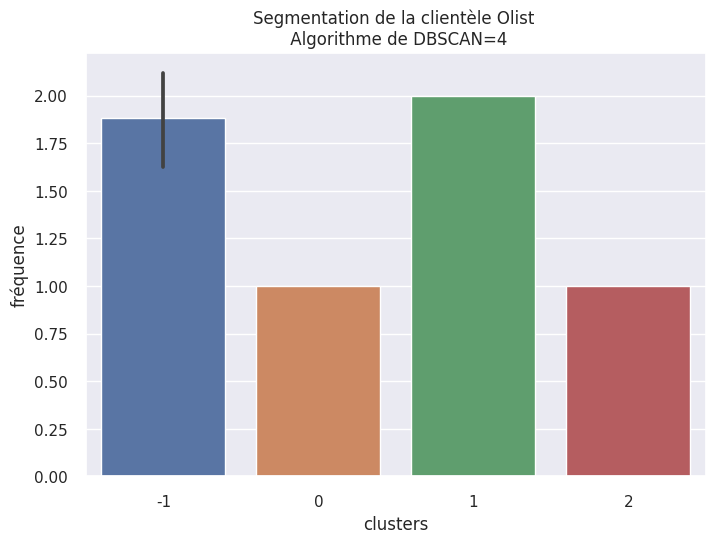

In [106]:
sns.set()
sns.barplot(data = df, x = 'clusters', y= 'fréquence')
plt.savefig('/content/Fichier_N2/P5_N2_42a_set'+str(set_)+'.png', bbox_inches = 'tight')
plt.title('Segmentation de la clientèle Olist \n Algorithme de DBSCAN='+str(k))

In [107]:
if set_ != 3: 
  order_ = df.groupby('clusters')['récence_j'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.boxplot(data = df, x = 'clusters', y= 'récence_j', showfliers = False, order = order_)
  plt.savefig('/content/Fichier_N2/P5_N2_42b_set'+str(set_)+'.png', bbox_inches = 'tight')
  plt.title('Segmentation de la clientèle Olist \n Algorithme de DBSCAN='+str(k))

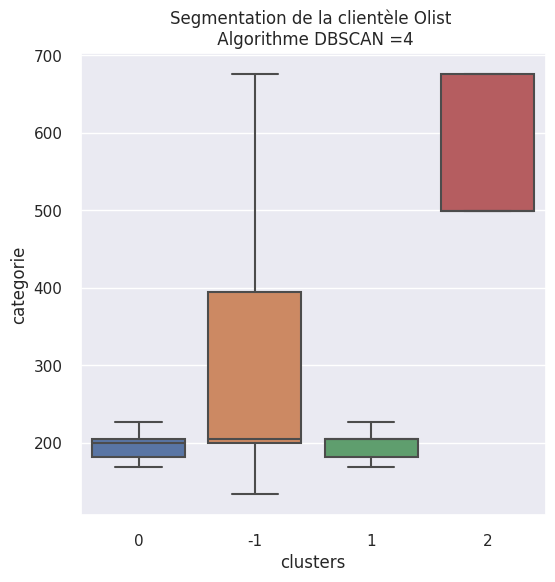

In [108]:
if set_ == 3:
  order_ = df.groupby('clusters')['categorie'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'categorie', showfliers = False, order = order_)
  plt.title('Segmentation de la clientèle Olist \n Algorithme DBSCAN ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_42b_set'+str(set_)+'.png', bbox_inches = 'tight')


In [109]:
if set_ != 3: 
  order_ = df.groupby('clusters')['montant_moy'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.boxplot(data = df, x = 'clusters', y= 'montant_moy', showfliers = False, order = order_)
  plt.savefig('/content/Fichier_N2/P5_N2_42c_set'+str(set_)+'.png', bbox_inches = 'tight')
  plt.title('Segmentation de la clientèle Olist \n Algorithme de DBSCAN, k='+str(k))

In [110]:
if set_ ==2:
  order_ = df.groupby('clusters')['etat_client'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'etat_client', showfliers = False, order = order_)
  ax.set_ylabel('Revenus moyen mensuel par personne')
  plt.savefig('/content/Fichier_N2/P5_N2_42d_set'+str(set_)+'.png', bbox_inches = 'tight')
  plt.title('Segmentation de la clientèle Olist \n Algorithme DBSCAN, k ='+str(k))

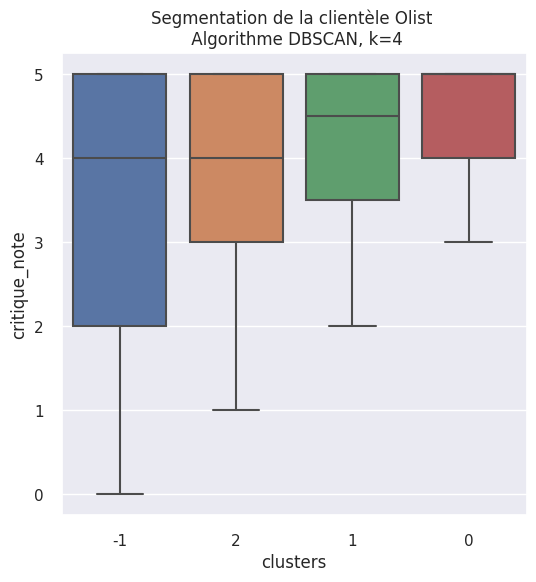

In [111]:
if set_ == 3:
  order_ = df.groupby('clusters')['critique_note'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'critique_note', showfliers = False, order = order_)
  plt.savefig('/content/Fichier_N2/P5_N2_42d_set'+str(set_)+'.png', bbox_inches = 'tight')
  plt.title('Segmentation de la clientèle Olist \n Algorithme DBSCAN, k='+str(k))

In [112]:
if set_ == 2: 
  order_ = df.groupby('clusters')['reste_echeance_mois'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'reste_echeance_mois', showfliers = False,order = order_)
  ax.set_ylabel('Nombre d\'échéances de paiement restant') 
  plt.savefig('/content/Fichier_N2/P5_N2_42e_set'+str(set_)+'.png', bbox_inches = 'tight')
  plt.title('Segmentation de la clientèle Olist \n Algorithme DBSCAN, k ='+str(k))

In [113]:
df[df['clusters']== 0].describe()

fréquence    récence_j  montant_moy  critique_note    categorie  \
count     9039.0  9039.000000  9039.000000    9039.000000  9039.000000   
mean         1.0   356.836929   180.439456       4.097688   198.077353   
std          0.0   179.456505   255.380916       1.352251    24.676537   
min          1.0    23.000000    13.780000       0.000000   131.030000   
25%          1.0   212.000000    62.355000       4.000000   181.280000   
50%          1.0   341.000000   107.410000       5.000000   199.650000   
75%          1.0   491.000000   187.605000       5.000000   205.130000   
max          1.0  1026.000000  3328.000000       5.000000   289.460000   

       clusters  
count    9039.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0

- ### Représentation dans l'espace des composantes principales

In [114]:
df_cent = df.groupby('clusters')[num_features].mean()
centroids= df_cent.values

In [115]:
centroid_proj = pca.transform(centroids)
centroid_proj
if set_ ==1 :
  centroid_df = pd.DataFrame(data = centroid_proj, columns = ['F1', 'F2', 'F3'])
else:
  centroid_df = pd.DataFrame(data = centroid_proj, columns = ['F1', 'F2', 'F3','F4'])


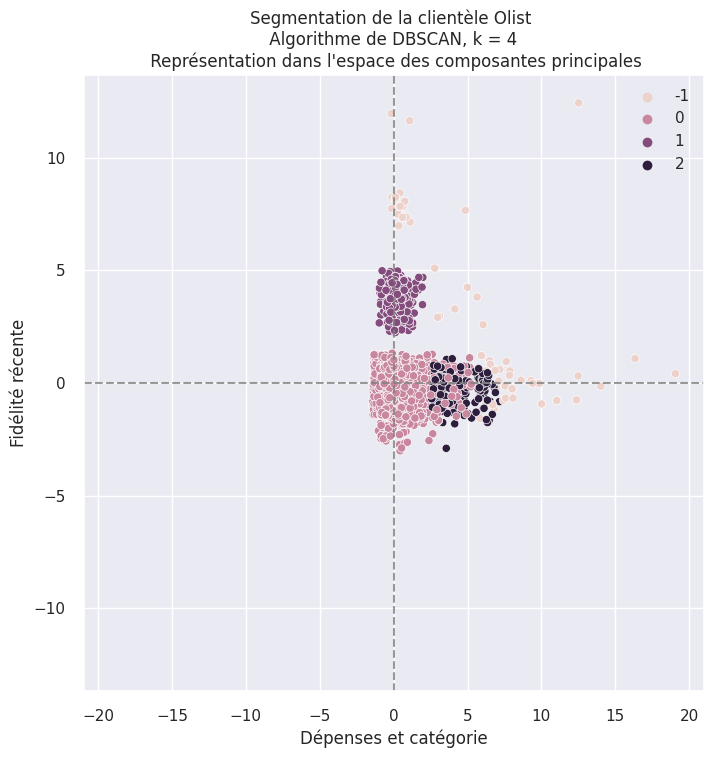

In [116]:
if set_ == 1:
  F1 = 'Fidélité récente' 
  F2 = 'Dépenses anciennes'
  F3 = 'Ancienneté clientèle'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3], index = ind)
elif set_== 2 :
  F1 = 'Trésorerie'
  F2 = '(-) Pouvoir d\'achat'
  F3 = 'Fréquence'
  F4 = 'Dépenses'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
elif set_==3:
  F1 = 'Dépenses et catégorie'
  F2 = 'Fidélité récente'
  F3 = 'Fidélité ancienne'
  F4 = 'Note'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
data_proj['clusters'] = df['clusters']
data_proj

fig, ax = plt.subplots(figsize=(8,8))
sns.set()
sns.scatterplot(data = data_proj,x = F1, y =  F2, hue = 'clusters')
sns.scatterplot(data = centroid_df, x = 'F1', y = 'F2', markers = '^')
# Valeur x max et y max
x_max = np.abs(data_proj[F1]).max() *1.1
y_max = np.abs(data_proj[F2]).max() *1.1

# On borne x et y 
ax.set_xlim(left=-x_max, right=x_max)
ax.set_ylim(bottom= -y_max, top=y_max)

# Affichage des lignes horizontales et verticales
plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')


plt.title('Segmentation de la clientèle Olist \n Algorithme de DBSCAN, k = '+str(k)+' \n Représentation dans l\'espace des composantes principales')

plt.savefig('/content/Fichier_N2/P5_N2_42_ACP1_set'+str(set_)+'.png', bbox_inches = 'tight')

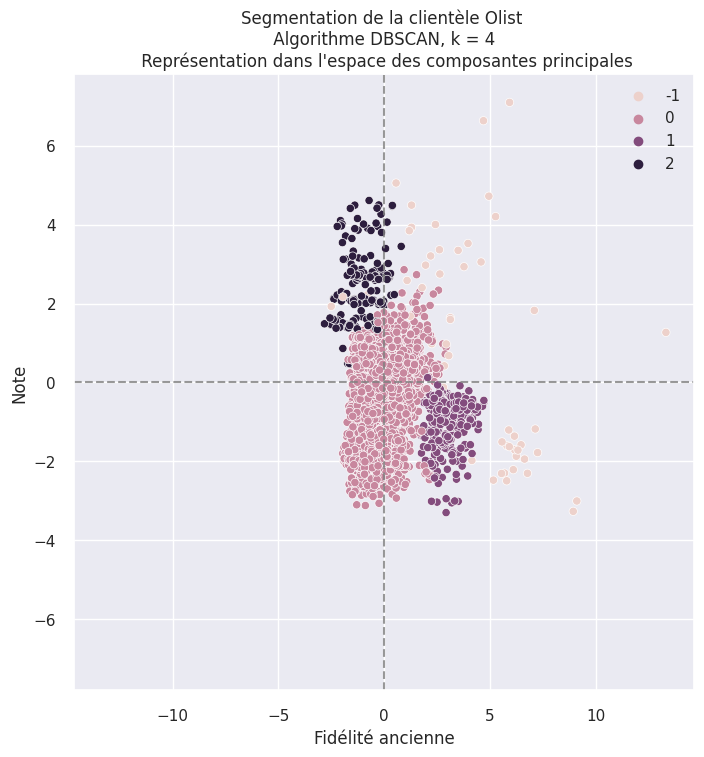

In [117]:
if set_ == 1:
  F1 = 'Fidélité récente' 
  F2 = 'Dépenses anciennes'
  F3 = 'Ancienneté clientèle'
  data_proj = pd.DataFrame(data = X_proj,  columns = [F1, F2, F3], index = ind)
  data_proj['clusters'] = df['clusters']
  fig, ax = plt.subplots(figsize=(8,8))
  sns.set()
  sns.scatterplot(data = data_proj,  x = F2, y = F3, hue = 'clusters')
  sns.scatterplot(data = centroid_df, x = 'F2', y = 'F3', markers = '^')
  # Valeur x max et y max
  x_max = np.abs(data_proj[F2]).max() *1.1
  y_max = np.abs(data_proj[F3]).max() *1.1

  # On borne x et y 
  ax.set_xlim(left=-x_max, right=x_max)
  ax.set_ylim(bottom= -y_max, top=y_max)

  # Affichage des lignes horizontales et verticales
  plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
  plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')
else:
  if set_ == 2:
    F1 = 'Trésorerie'
    F2 = '(-) Pouvoir d\'achat'
    F3 = 'Fréquence'
    F4 = 'Dépenses'
  elif set_==3:
    F1 = 'Dépenses et catégorie'
    F2 = 'Fidélité récente'
    F3 = 'Fidélité ancienne'
    F4 = 'Note'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
  data_proj['clusters'] = df['clusters']
  data_proj
  fig, ax = plt.subplots(figsize=(8,8))
  sns.set()
  data_proj['clusters'] = df['clusters']
  sns.scatterplot(data = data_proj, x = F3, y = F4, hue = 'clusters')
  sns.scatterplot(data = centroid_df, x = 'F3', y = 'F4', markers = '^')
  # Valeur x max et y max
  x_max = np.abs(data_proj[F3]).max() *1.1
  y_max = np.abs(data_proj[F4]).max() *1.1

  # On borne x et y 
  ax.set_xlim(left=-x_max, right=x_max)
  ax.set_ylim(bottom= -y_max, top=y_max)

  # Affichage des lignes horizontales et verticales
  plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
  plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')

plt.title('Segmentation de la clientèle Olist \n Algorithme DBSCAN, k = '+str(k)+' \n Représentation dans l\'espace des composantes principales')
plt.savefig('/content/Fichier_N2/P5_N2_42_ACP2_set'+str(set_)+'.png', bbox_inches = 'tight')

- ### Représentation bivariées + 3D

In [118]:
df.head()

fréquence  récence_j  montant_moy  critique_note  categorie  clusters
5054           1        160        80.31            5.0     205.13         0
37580          1        476       113.45            5.0     199.65         0
51563          1        565       105.89            1.0     227.55         0
81880          1        259       216.38            5.0     205.13         0
56353          1        557        71.14            2.0     181.28         0

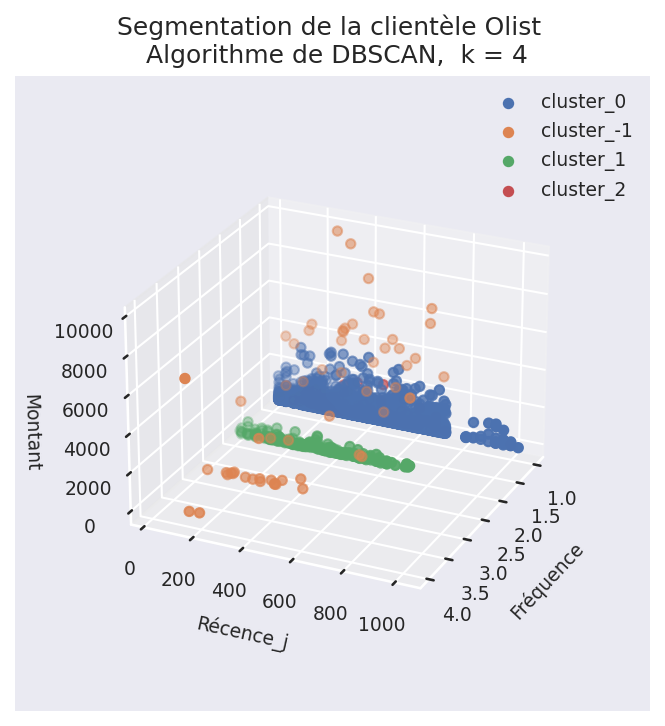

In [119]:
#Plot3D
fig = plt.figure(dpi =150)
ax = fig.add_subplot(projection='3d')
ls_clust = df['clusters'].unique().tolist()
for clust in ls_clust:
  df_tamp = df[df['clusters']== clust]
  xs = df_tamp['fréquence']
  ys = df_tamp['récence_j']
  zs = df_tamp['montant_moy']
  ax.scatter(xs, ys, zs, marker='o', label = 'cluster_'+str(clust))
ax.legend(fontsize = 9)
ax.set_xlabel('Fréquence', labelpad = 14, fontsize = 9)
ax.set_ylabel('Récence_j',labelpad = 14, fontsize = 9)
ax.set_zlabel('Montant',labelpad = 14, fontsize = 9)
ax.tick_params(labelsize=9)
ax.view_init(elev=25., azim=25, roll=0)
ax.dist = 13
plt.title('Segmentation de la clientèle Olist \n Algorithme de DBSCAN,  k = '+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_42_3D_set'+str(set_)+'.png', bbox_inches = 'tight')

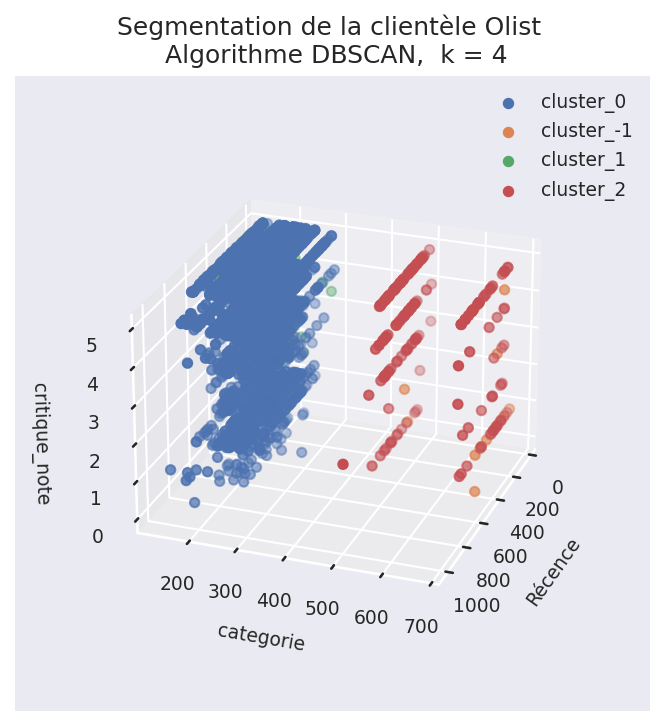

In [120]:
if set_!=1:
  fig = plt.figure(dpi =150)
  ax = fig.add_subplot(projection='3d')
  for clust in ls_clust:
    df_tamp = df[df['clusters']== clust]
    xs = df_tamp['récence_j']
    ys = df_tamp[num_features[-1]]
    zs = df_tamp[num_features[-2]]
    ax.scatter(xs, ys, zs, marker='o', label = 'cluster_'+str(clust))
  ax.legend(fontsize = 9)
  ax.set_xlabel('Récence', labelpad = 14, fontsize = 9)
  ax.set_ylabel(str(num_features[-1]),labelpad = 14, fontsize = 9)
  ax.set_zlabel(str(num_features[-2]),labelpad = 14, fontsize = 9)
  ax.tick_params(labelsize=9)
  ax.view_init(elev=25., azim=20, roll=0)
  ax.dist = 13
  plt.title('Segmentation de la clientèle Olist \n Algorithme DBSCAN,  k = '+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_42_3D_b_set'+str(set_)+'.png', bbox_inches = 'tight')

# <a name="C5"> 5. Bonus :  Méthode mixte (K_means x CAH) </a>

La classification ascendante hierarchique construit une matrice de distance de taillle *n x n*. Or, n = 95417, la table des distances serait constituée de plusieurs milliard de lignes. 


---



Stratégie : Combiner le K-means à la méthode de CAH. 


1.   K-means avec 10% des individus et avec un grand nombre de classe. Stocker les coordonnées des barycentres.
2.   Utiliser les barycentres pour appliquer la méthode CAH, et rechercher un nombre de classe *k* optimal
3.   Ré-employer l'algorithme K-means sur l'ensemble du jeu de données en fixant le nombre *k* classe optimal et en renseignant les centroïdes dès l'initialisation.



## <a name="C51"> 5.1 K_means sur un échantillon </a>

In [121]:
df = df.drop(columns = ['clusters'])

In [122]:
state = 38
k = 1000
K_means_pipe_bonus = Pipeline([
        ('preprocessor', preprocessor),
        ('K_means_bonus', sklearn.cluster.KMeans(n_clusters=k,random_state = state))])
K_means_pipe_bonus.fit(df)
centroids = K_means_pipe_bonus.named_steps.K_means_bonus.cluster_centers_
clusters = K_means_pipe_bonus.named_steps.K_means_bonus.labels_

In [123]:
centroids

array([[-1.67398566e-01,  1.01601797e+00, -6.19552517e-02,
        -6.15453202e-02,  1.71134702e-01],
       [-1.67398566e-01, -5.98671910e-01, -3.70036522e-01,
        -6.15453202e-02, -4.18401821e-01],
       [ 5.05259201e+00,  3.37087407e-01, -2.12561814e-04,
         6.16092349e-01, -6.45879432e-02],
       ...,
       [ 5.05259201e+00, -1.50692154e+00,  6.76766967e-01,
        -1.54002751e+00, -1.27627969e-02],
       [-1.67398566e-01, -1.04647809e+00,  3.67997982e-01,
        -8.00786413e-01,  1.75736369e-01],
       [ 5.05259201e+00,  1.66142110e+00, -1.00570185e-01,
        -8.00786413e-01, -1.05472852e-01]])

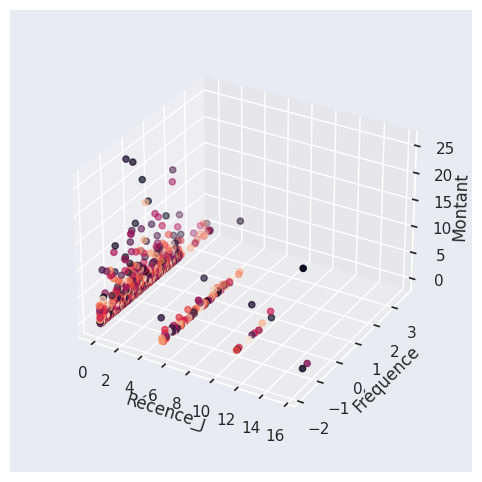

In [124]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')

#x = df['fréquence'].values
x = centroids[:,0]
#y = df['récence_j'].values
y = centroids[:,1]
#z = df['montant_moy'].values
z = centroids[:,2]
c = np.arange(k)

# plot
sc = ax.scatter(x,y,z, c = c)
ax.set_xlabel('Récence_j')
ax.set_ylabel('Fréquence')
ax.set_zlabel('Montant')
ax.dist = 12

#for clust in c:
  #ax.text(centroids[clust][0], centroids[clust][1], centroids[clust][2],
          #"Cluster_"+str(clust), color='red')

## <a name="C52">5.2 Classification ascendante hierarchique </a>

In [125]:
df_centroid = pd.DataFrame(data = centroids, 
                           columns = num_features)

In [126]:
#### Initialisation des variables et dataframe de sortie 
inertie = pd.DataFrame(columns = ['k','Inertie totale'])
ls_nb_clusters = np.arange(2, 15)
columns = ['k='+str(i) for i in ls_nb_clusters] #défnition nom de colonnes de score_sil
score_sil = pd.DataFrame(columns = columns) #Dataframe comprenant pour chaque observation les scores silhouette 
cluster_df = pd.DataFrame(columns = columns)
scaler_bonus = StandardScaler()
X_scaled_centroid = scaler_bonus.fit_transform(df_centroid)
####------------------------------------
#### Boucles sur le nombre de classes k
for count, k in enumerate(ls_nb_clusters):
  inertie.loc[len(inertie), 'k'] = k
  ######------------ Feature Engineering set_ 1 / Variable RFM uniquement. 
  CAH_pipe_bonus = Pipeline([
      ('preprocessor', preprocessor),
      ('CAH', sklearn.cluster.AgglomerativeClustering(n_clusters=k))])
  CAH_pipe_bonus.fit(df_centroid)
  clusters = CAH_pipe_bonus.named_steps.CAH.labels_ 
  inertia_ = cal_inertia(clusters,df_centroid,X_scaled_centroid)
  inertie.loc[count, 'Inertie totale'] = inertia_

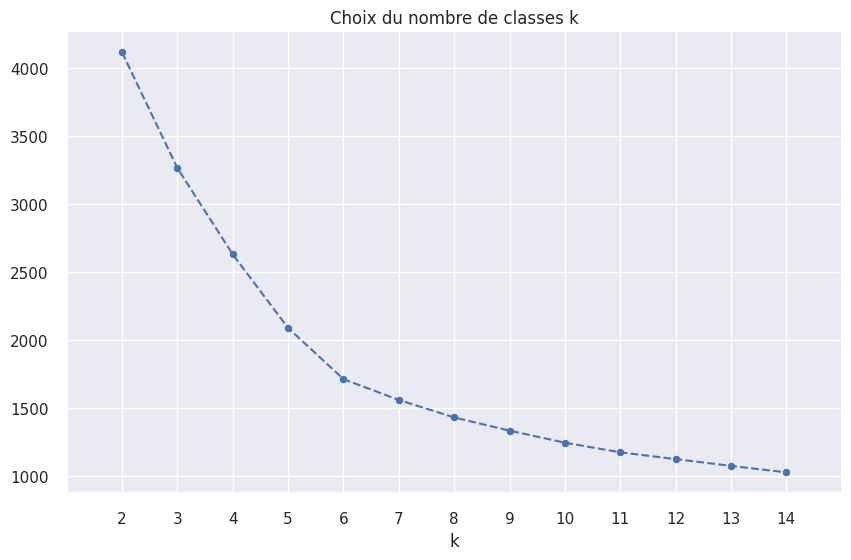

In [127]:
sns.set()
g, ax = plt.subplots(figsize=(10,6))
g = sns.lineplot(data = inertie, x = 'k', y = 'Inertie totale',ls = '--')
h = sns.scatterplot(data = inertie, x = 'k', y = 'Inertie totale')
g.set(xlim=(1,15),xticks=ls_nb_clusters)
ax.set_ylabel('')
plt.title("Choix du nombre de classes k")
plt.savefig('/content/Fichier_N2/P5_N2_520_set_'+str(set_)+'.png', bbox_inches = 'tight')



---


set_1 : Le nombre de cluster *k=4* semble optimal.

---



## <a name="C53"> 5.3 K-means avec les *k* centroïdes départ </a>

In [128]:
num_features

['fréquence', 'récence_j', 'montant_moy', 'critique_note', 'categorie']

In [129]:
if set_==1 :
  k=4
elif set_==2:
  k=5
elif set_==3:
  k=4

In [130]:
df_centroid

fréquence  récence_j  montant_moy  critique_note  categorie
0    -0.167399   1.016018    -0.061955      -0.061545   0.171135
1    -0.167399  -0.598672    -0.370037      -0.061545  -0.418402
2     5.052592   0.337087    -0.000213       0.616092  -0.064588
3    -0.167399  -0.556978    -0.044541       0.677696   4.973110
4    -0.167399   1.365262     9.567607      -1.540028  -0.012763
..         ...        ...          ...            ...        ...
995  -0.167399   0.169450     1.388765       0.677696   4.973110
996  -0.167399   1.058859    -0.152514      -0.800786   4.973110
997   5.052592  -1.506922     0.676767      -1.540028  -0.012763
998  -0.167399  -1.046478     0.367998      -0.800786   0.175736
999   5.052592   1.661421    -0.100570      -0.800786  -0.105473

[1000 rows x 5 columns]

In [131]:
#Récupération des centroïdes 
CAH_pipe_bonus = Pipeline([
      ('preprocessor', preprocessor),
      ('CAH', sklearn.cluster.AgglomerativeClustering(n_clusters=k))])
start_time = time.time()
CAH_pipe_bonus.fit(df_centroid)
end_time = time.time()
fit_time_mixte = end_time-start_time
clusters = CAH_pipe_bonus.named_steps.CAH.labels_ 
inertia_ = cal_inertia(clusters,df_centroid,X_scaled_centroid)
df_centroid['clusters'] = clusters

In [132]:
df_centroid

fréquence  récence_j  montant_moy  critique_note  categorie  clusters
0    -0.167399   1.016018    -0.061955      -0.061545   0.171135         1
1    -0.167399  -0.598672    -0.370037      -0.061545  -0.418402         1
2     5.052592   0.337087    -0.000213       0.616092  -0.064588         2
3    -0.167399  -0.556978    -0.044541       0.677696   4.973110         3
4    -0.167399   1.365262     9.567607      -1.540028  -0.012763         0
..         ...        ...          ...            ...        ...       ...
995  -0.167399   0.169450     1.388765       0.677696   4.973110         3
996  -0.167399   1.058859    -0.152514      -0.800786   4.973110         3
997   5.052592  -1.506922     0.676767      -1.540028  -0.012763         2
998  -0.167399  -1.046478     0.367998      -0.800786   0.175736         1
999   5.052592   1.661421    -0.100570      -0.800786  -0.105473         2

[1000 rows x 6 columns]

In [133]:
df_centroid = df_centroid.groupby('clusters')[num_features].mean()
df_centroid 

fréquence  récence_j  montant_moy  critique_note  categorie
clusters                                                             
0         -0.149643   0.257226     1.852056      -1.700951  -0.085182
1         -0.167399   0.041413     0.491286       0.312407  -0.070882
2          5.964823  -0.227665     0.358286      -0.133769  -0.123613
3          0.004689   0.129224     1.301633      -0.658625   6.376566

In [134]:
df_centroid.to_csv('/content/Fichier_N2/centroid_mixte_set'+str(set_)+'.csv')

In [135]:
df_centroid.values

array([[-1.49643496e-01,  2.57226154e-01,  1.85205577e+00,
        -1.70095074e+00, -8.51824633e-02],
       [-1.67398566e-01,  4.14134496e-02,  4.91286261e-01,
         3.12406717e-01, -7.08823611e-02],
       [ 5.96482338e+00, -2.27665359e-01,  3.58286440e-01,
        -1.33769141e-01, -1.23612607e-01],
       [ 4.68903546e-03,  1.29224472e-01,  1.30163286e+00,
        -6.58624665e-01,  6.37656588e+00]])

In [136]:
startpts = df_centroid.values
K_means_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('K_means_1', sklearn.cluster.KMeans(n_clusters=k,
                                             init=startpts, 
                                             n_init = 1,
                                             algorithm = 'lloyd') )])
start_time = time.time()
K_means_pipe.fit(df)
end_time = time.time()
fit_time_mixte += end_time-start_time
centroids = K_means_pipe.named_steps.K_means_1.cluster_centers_
clusters = K_means_pipe.named_steps.K_means_1.labels_
sil = metrics.silhouette_score(X_scaled, clusters, metric = 'euclidean')

In [137]:
score_model.loc['MIXTE','Silhouette'] = sil
score_model.loc['MIXTE','Temps_calcul'] = fit_time_mixte

In [138]:
score_model

Silhouette Temps_calcul
K_means   0.405964      0.32703
CAH       0.433465     4.709551
DBSCAN    0.635664     4.058813
MIXTE     0.461622     0.081671

For n_clusters = 4 The average silhouette_score is : 0.46162235949099073


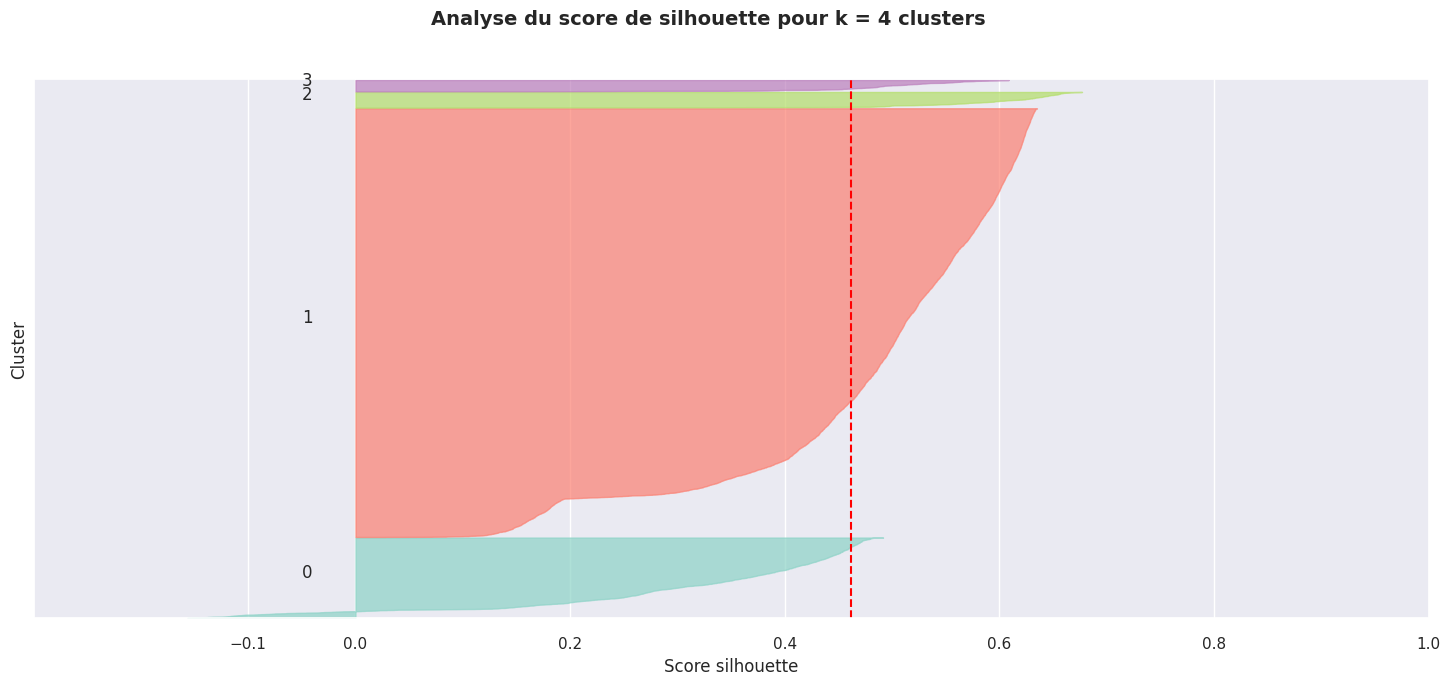

<Figure size 800x550 with 0 Axes>

In [139]:
plot_.plot_silhouette(X_scaled, clusters, k,'/content/Fichier_N2/P5_N2_53_bonus_set_'+str(set_)+'.png')

In [140]:
df['clusters'] = clusters
df

fréquence  récence_j  montant_moy  critique_note  categorie  clusters
5054           1        160        80.31            5.0     205.13         1
37580          1        476       113.45            5.0     199.65         1
51563          1        565       105.89            1.0     227.55         0
81880          1        259       216.38            5.0     205.13         1
56353          1        557        71.14            2.0     181.28         0
...          ...        ...          ...            ...        ...       ...
34112          1        491        47.59            4.0     205.13         1
40015          1         54        30.13            3.0     183.83         1
67763          1        332        34.75            4.0     169.58         1
18137          1        723       135.92            5.0     198.68         1
42206          1         56       220.03            4.0     199.65         1

[9542 rows x 6 columns]

In [141]:
df['clusters'].value_counts()

1    7630
0    1429
2     280
3     203
Name: clusters, dtype: int64

- ### Représentation univariée

In [142]:
df.columns

Index(['fréquence', 'récence_j', 'montant_moy', 'critique_note', 'categorie',
       'clusters'],
      dtype='object')

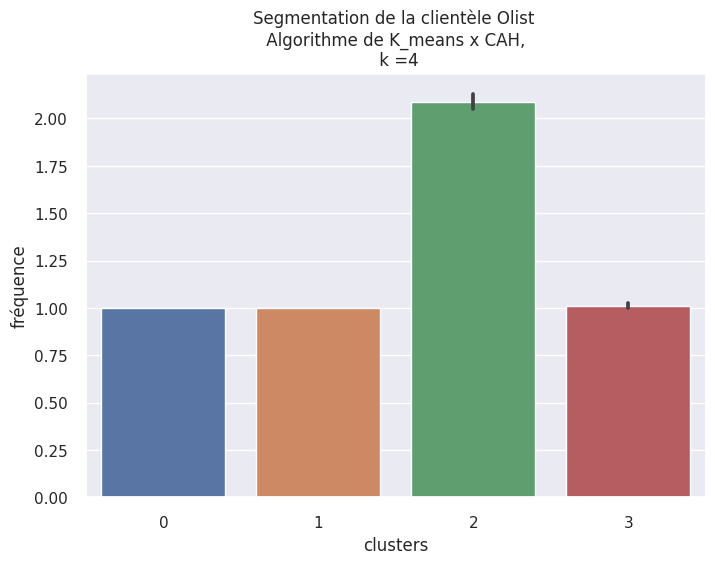

In [143]:
sns.set()
sns.barplot(data = df, x = 'clusters', y= 'fréquence')
plt.title('Segmentation de la clientèle Olist \n Algorithme de K_means x CAH, \n k ='+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_53a_set'+str(set_)+'.png', bbox_inches = 'tight')


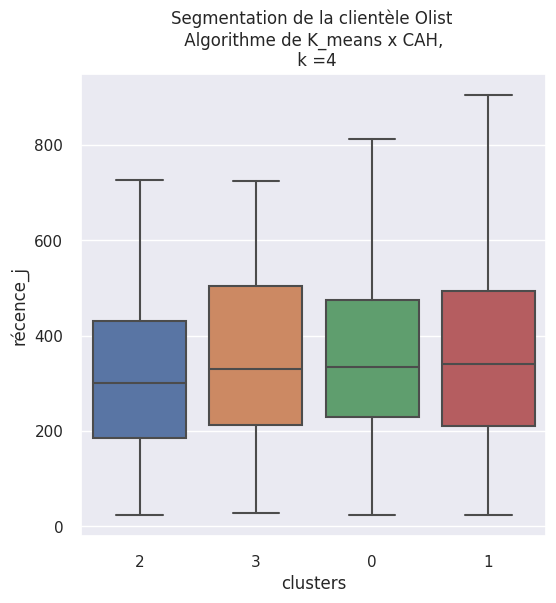

In [144]:
order_ = df.groupby('clusters')['récence_j'].median().sort_values().index
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(data = df, x = 'clusters', y= 'récence_j', showfliers = False, order = order_)
plt.title('Segmentation de la clientèle Olist \n Algorithme de K_means x CAH, \n k ='+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_52b_set'+str(set_)+'.png', bbox_inches = 'tight')


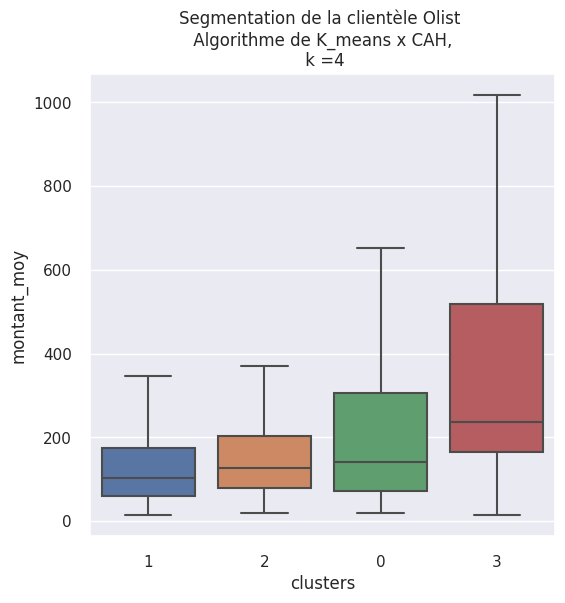

In [145]:
order_ = df.groupby('clusters')['montant_moy'].median().sort_values().index
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(data = df, x = 'clusters', y= 'montant_moy', showfliers = False, order = order_)
plt.title('Segmentation de la clientèle Olist \n Algorithme de K_means x CAH, \n k ='+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_52c_set'+str(set_)+'.png', bbox_inches = 'tight')


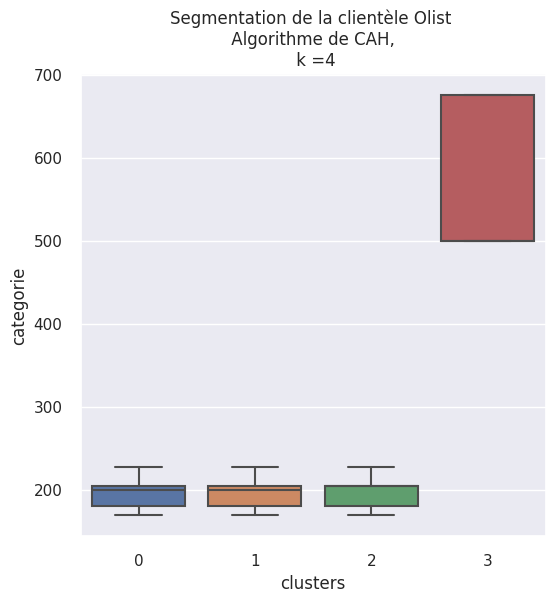

In [146]:
if set_ == 3:
  order_ = df.groupby('clusters')['categorie'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'categorie', showfliers = False, order = order_)
  plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH, \n k ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_52d_set'+str(set_)+'.png', bbox_inches = 'tight')


In [147]:
if set_ ==2:
  order_ = df.groupby('clusters')['etat_client'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'etat_client', showfliers = False, order = order_)
  ax.set_ylabel('Revenus moyen mensuel par personne')
  plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH,  \n k ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_52d_set'+str(set_)+'.png', bbox_inches = 'tight')


In [148]:
if set_ == 2: 
  order_ = df.groupby('clusters')['reste_echeance_mois'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'reste_echeance_mois', showfliers = False,order = order_)
  ax.set_ylabel('Nombre d\'échéances de paiement restant') 
  plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH,  \n k ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_52e_set'+str(set_)+'.png', bbox_inches = 'tight')


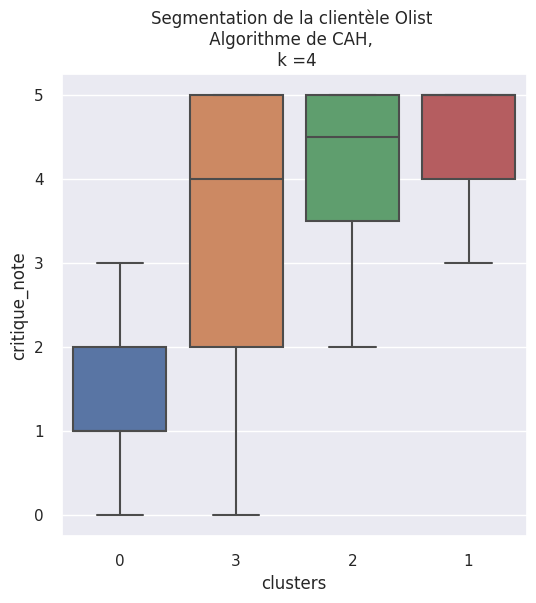

In [149]:
if set_ == 3:
  order_ = df.groupby('clusters')['critique_note'].median().sort_values().index
  fig, ax = plt.subplots(figsize=(6,6))
  sns.set()
  sns.boxplot(data = df, x = 'clusters', y= 'critique_note', showfliers = False, order = order_)
  plt.title('Segmentation de la clientèle Olist \n Algorithme de CAH,  \n k ='+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_52e_set'+str(set_)+'.png', bbox_inches = 'tight')


In [150]:
df[df['clusters']== 0].describe()

fréquence    récence_j  montant_moy  critique_note   categorie  \
count     1429.0  1429.000000  1429.000000    1429.000000  1429.00000   
mean         1.0   358.211337   345.336361       1.369489   198.56895   
std          0.0   179.682260   713.856581       0.804796    23.49760   
min          1.0    23.000000    18.920000       0.000000   131.03000   
25%          1.0   230.000000    72.900000       1.000000   181.28000   
50%          1.0   335.000000   141.230000       1.000000   199.65000   
75%          1.0   474.000000   305.310000       2.000000   205.13000   
max          1.0  1026.000000  9759.750000       5.000000   289.46000   

       clusters  
count    1429.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0

In [151]:
df.groupby('clusters').count()

fréquence  récence_j  montant_moy  critique_note  categorie
clusters                                                             
0              1429       1429         1429           1429       1429
1              7630       7630         7630           7630       7630
2               280        280          280            280        280
3               203        203          203            203        203

- ### Représentation dans l'espace des composantes principales

In [152]:
centroids = df_centroid.values

In [153]:
centroid_proj = pca.transform(centroids)
centroid_proj
if set_ ==1 :
  centroid_df = pd.DataFrame(data = centroid_proj, columns = ['F1', 'F2', 'F3'])
else:
  centroid_df = pd.DataFrame(data = centroid_proj, columns = ['F1', 'F2', 'F3','F4'])


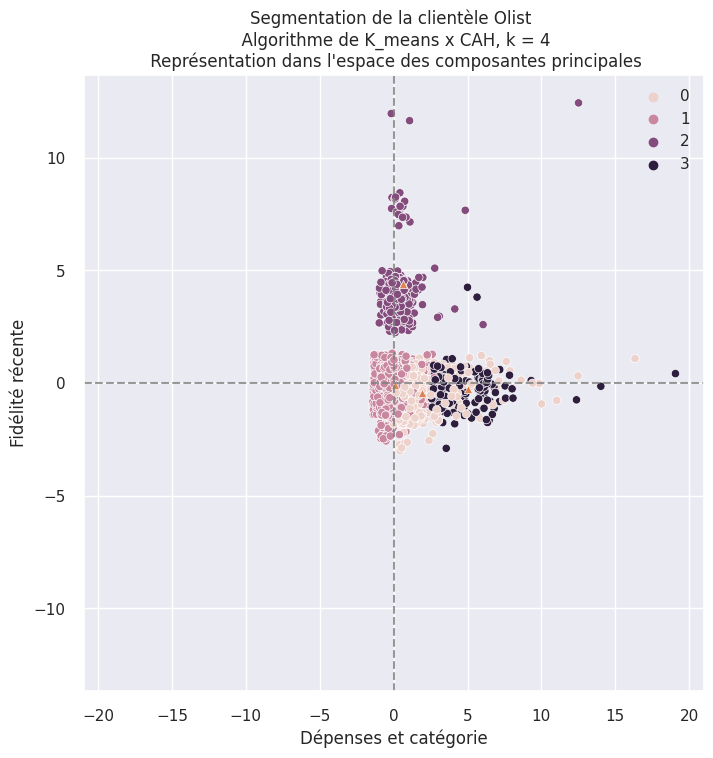

In [154]:
if set_ == 1:
  F1 = 'Fidélité récente' 
  F2 = 'Dépenses anciennes'
  F3 = 'Ancienneté clientèle'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3], index = ind)
elif set_== 2 :
  F1 = 'Trésorerie'
  F2 = '(-) Pouvoir d\'achat'
  F3 = 'Fréquence'
  F4 = 'Dépenses'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
elif set_==3:
  F1 = 'Dépenses et catégorie'
  F2 = 'Fidélité récente'
  F3 = 'Fidélité ancienne'
  F4 = 'Note'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
data_proj['clusters'] = df['clusters']
data_proj

fig, ax = plt.subplots(figsize=(8,8))
sns.set()
sns.scatterplot(data = data_proj,x = F1, y =  F2, hue = 'clusters')
sns.scatterplot(data = centroid_df, x = 'F1', y = 'F2', marker = '^')
# Valeur x max et y max
x_max = np.abs(data_proj[F1]).max() *1.1
y_max = np.abs(data_proj[F2]).max() *1.1

# On borne x et y 
ax.set_xlim(left=-x_max, right=x_max)
ax.set_ylim(bottom= -y_max, top=y_max)

# Affichage des lignes horizontales et verticales
plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')

plt.title('Segmentation de la clientèle Olist \n  Algorithme de K_means x CAH, k = '+str(k)+' \n Représentation dans l\'espace des composantes principales')

plt.savefig('/content/Fichier_N2/P5_N2_32_ACP1_set'+str(set_)+'.png', bbox_inches = 'tight')

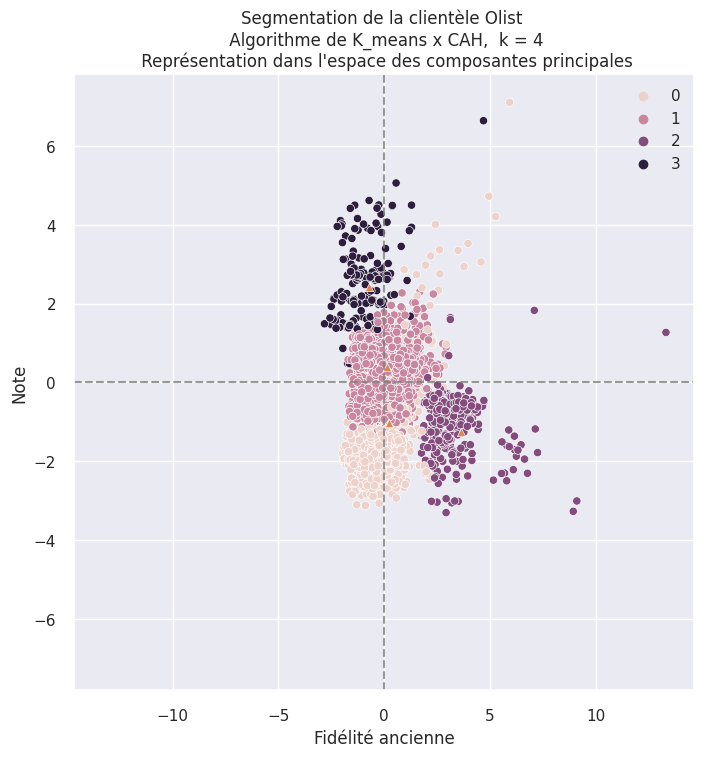

In [155]:
if set_ == 1:
  F1 = 'Fidélité récente' 
  F2 = 'Dépenses anciennes'
  F3 = 'Ancienneté clientèle'
  data_proj = pd.DataFrame(data = X_proj,  columns = [F1, F2, F3], index = ind)
  data_proj['clusters'] = df['clusters']
  fig, ax = plt.subplots(figsize=(8,8))
  sns.set()
  sns.scatterplot(data = data_proj,  x = F2, y = F3, hue = 'clusters')
  sns.scatterplot(data = centroid_df, x = 'F2', y = 'F3', marker ='^')
  # Valeur x max et y max
  x_max = np.abs(data_proj[F2]).max() *1.1
  y_max = np.abs(data_proj[F3]).max() *1.1

  # On borne x et y 
  ax.set_xlim(left=-x_max, right=x_max)
  ax.set_ylim(bottom= -y_max, top=y_max)

  # Affichage des lignes horizontales et verticales
  plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
  plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')
else:
  if set_ == 2:
    F1 = 'Trésorerie'
    F2 = '(-) Pouvoir d\'achat'
    F3 = 'Fréquence'
    F4 = 'Dépenses'
  elif set_==3:
    F1 = 'Dépenses et catégorie'
    F2 = 'Fidélité récente'
    F3 = 'Fidélité ancienne'
    F4 = 'Note'
  data_proj = pd.DataFrame(data = X_proj, columns = [F1, F2, F3, F4], index = ind)
  data_proj['clusters'] = df['clusters']
  data_proj
  fig, ax = plt.subplots(figsize=(8,8))
  sns.set()
  data_proj['clusters'] = df['clusters']
  sns.scatterplot(data = data_proj, x = F3, y = F4, hue = 'clusters')
  sns.scatterplot(data = centroid_df, x = 'F3', y = 'F4', marker ='^')
  # Valeur x max et y max
  x_max = np.abs(data_proj[F3]).max() *1.1
  y_max = np.abs(data_proj[F4]).max() *1.1

  # On borne x et y 
  ax.set_xlim(left=-x_max, right=x_max)
  ax.set_ylim(bottom= -y_max, top=y_max)

  # Affichage des lignes horizontales et verticales
  plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8, ls = '--')
  plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8, ls = '--')

plt.title('Segmentation de la clientèle Olist \n Algorithme de K_means x CAH,  k = '+str(k)+'\n Représentation dans l\'espace des composantes principales')
plt.savefig('/content/Fichier_N2/P5_N2_52_ACP2_set'+str(set_)+'.png', bbox_inches = 'tight')

- ### Représentation bivariées + 3D

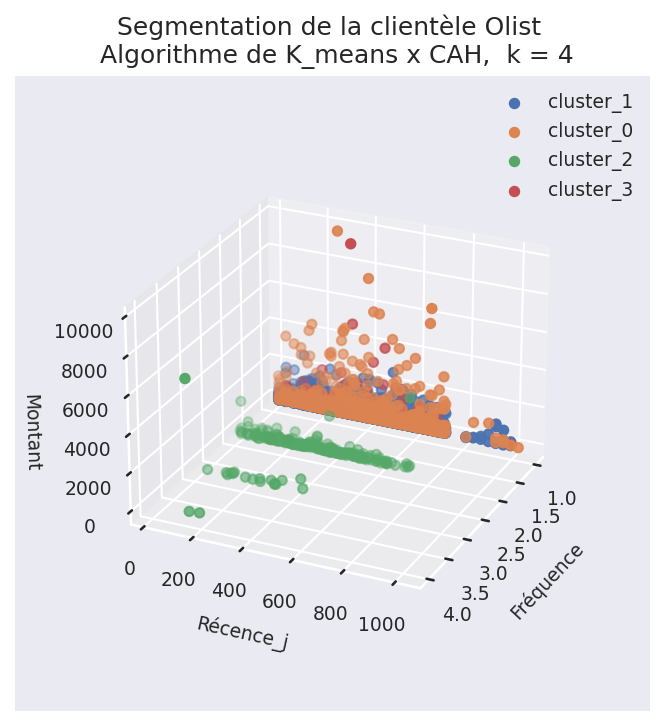

In [156]:
fig = plt.figure(dpi =150)
ax = fig.add_subplot(projection='3d')
ls_clust = df['clusters'].unique().tolist()
for clust in ls_clust :
    df_tamp = df[df['clusters']== clust]
    xs = df_tamp['fréquence']
    ys = df_tamp['récence_j']
    zs = df_tamp['montant_moy']
    ax.scatter(xs, ys, zs, marker='o', label = 'cluster_'+str(clust))
ax.legend(fontsize = 9)
ax.set_xlabel('Fréquence', labelpad = 14, fontsize = 9)
ax.set_ylabel('Récence_j',labelpad = 14, fontsize = 9)
ax.set_zlabel('Montant',labelpad = 14, fontsize = 9)
ax.tick_params(labelsize=9)
ax.view_init(elev=25., azim=25, roll=0)
ax.dist = 13
plt.title('Segmentation de la clientèle Olist \n Algorithme de K_means x CAH,  k = '+str(k))
plt.savefig('/content/Fichier_N2/P5_N2_52_3D_a_set'+str(set_)+'.png', bbox_inches = 'tight')

In [157]:
num_features

['fréquence', 'récence_j', 'montant_moy', 'critique_note', 'categorie']

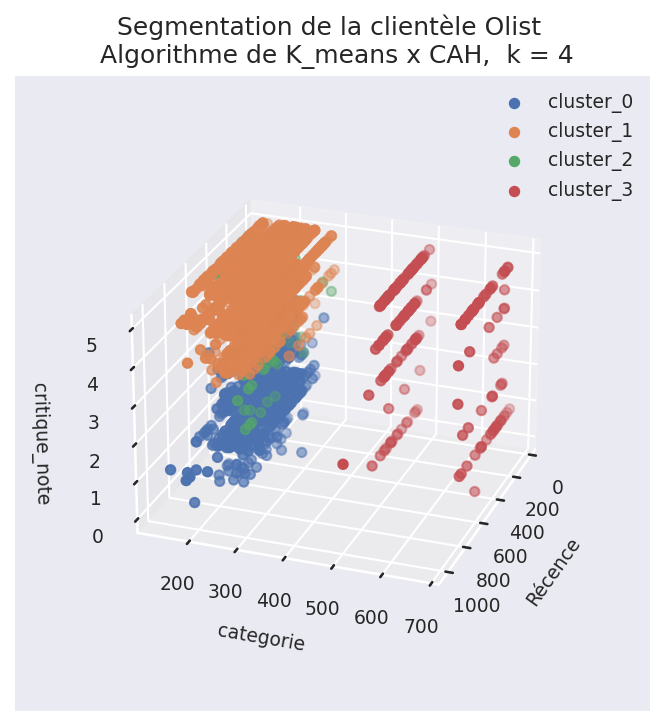

In [158]:
if set_ != 1:
  fig = plt.figure(dpi =150)
  ax = fig.add_subplot(projection='3d')
  for clust in range(k):
    df_tamp = df[df['clusters']== clust]
    xs = df_tamp['récence_j']
    ys = df_tamp[num_features[-1]]
    zs = df_tamp[num_features[-2]]
    ax.scatter(xs, ys, zs, marker='o', label = 'cluster_'+str(clust))
  ax.legend(fontsize = 9)
  ax.set_xlabel('Récence', labelpad = 14, fontsize = 9)
  ax.set_ylabel(str(num_features[-1]),labelpad = 14, fontsize = 9)
  ax.set_zlabel(str(num_features[-2]),labelpad = 14, fontsize = 9)
  ax.tick_params(labelsize=9)
  ax.view_init(elev=25., azim=20, roll=0)
  ax.dist = 13
  plt.title('Segmentation de la clientèle Olist \n Algorithme de K_means x CAH,  k = '+str(k))
  plt.savefig('/content/Fichier_N2/P5_N2_52_3D_b_set'+str(set_)+'.png', bbox_inches = 'tight')

- ### Tableau comparatif

In [159]:
score_model

Silhouette Temps_calcul
K_means   0.405964      0.32703
CAH       0.433465     4.709551
DBSCAN    0.635664     4.058813
MIXTE     0.461622     0.081671

# Téléchargement du dossier Fichier_N2

- ### Tableau comparatif

In [160]:
score_model.to_csv('/content/Fichier_N2/Comparaison_modele_set'+str(set_)+'.csv')

In [161]:
from google.colab import files
!zip -r Fichier_N2.zip Fichier_N2
files.download('Fichier_N2.zip')

updating: Fichier_N2/ (stored 0%)
updating: Fichier_N2/P5_N2_42a_set1.png (deflated 21%)
updating: Fichier_N2/P5_N2_32_ACP1_set1.png (deflated 7%)
updating: Fichier_N2/P5_N2_32_0_set_1.png (deflated 93%)
updating: Fichier_N2/P5_N2_52c_set1.png (deflated 18%)
updating: Fichier_N2/P5_N2_520_set_1.png (deflated 13%)
updating: Fichier_N2/P5_N2_42_3D_set1.png (deflated 4%)
updating: Fichier_N2/Comparaison_modele_set1.csv (deflated 24%)
updating: Fichier_N2/P5_N2_42_0_set1.png (deflated 93%)
updating: Fichier_N2/P5_N2_42b_set1.png (deflated 22%)
updating: Fichier_N2/P5_N2_42c_set1.png (deflated 22%)
updating: Fichier_N2/P5_N2_32c_set1.png (deflated 18%)
updating: Fichier_N2/centroid_mixte_set1.csv (deflated 36%)
updating: Fichier_N2/P5_N2_22_ACP1_set1.png (deflated 8%)
updating: Fichier_N2/P5_N2_20b_set_1.png (deflated 13%)
updating: Fichier_N2/P5_N2_52_ACP2_set1.png (deflated 6%)
updating: Fichier_N2/P5_N2_32b_set1.png (deflated 18%)
updating: Fichier_N2/P5_N2_30a_set_1.png (deflated 13%)
u

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>